# Proyecto Mundi.

## Librerias.
Primero vamos a importar todas las librerias que vamos a utilizar a lo largo del proyecto: 
- Pandas para la carga y modificacion de bases de datos.
- Numpy para el manejo de distintos arrays.
- Matplotlib y sns para la realizacion de diversos graficos.
- Sklearn para todo lo que requiera machine learning.
- Datetime y Calendar para la realizacion de distintas funciones en base a la variable tiempo.
- La libreria stats models para todo lo que es serie de tiempos.
- Pmdarima para correcr el autoarima.
- Warning para graficar.
- Prophet para hacer time series forecasting.

In [118]:
# Importamos las librerias necesarias.
import pandas as pd
# from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import squarify
from scipy import stats
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.tree import DecisionTreeRegressor
import datetime
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# import warnings
from fbprophet import Prophet


In [2]:
# register_matplotlib_converters()
sns.set()

## Base de Datos.
Vamos a cargar la base de datos con la que vamos a trabajar, como es un csv la funcion de pandas "read_csv" nos va a servir perfectamente para esta tarea, para estar seguros de que sea una carga segura vamos a establecer algunas variables opcionales: 
- El separador sera ',' ;
- Las columnas del mismo vienen con headers, asi que seteamos esta opcion = 0 ;

Opcional: 
- El encoding 'latin1' seria importante considerar por si a futuro tenemos acentos especiales del latin como la ñ para que pueda leer correctamente el csv la funcion. Como en este caso no pasa eso, lo dejamos por defecto.
- Podriamos fijar index_col=0 y fijariamos TAX_ID como el indice. 
- Tambien podriamos establecer Date como index column y activar la funcion parse_date, y ya tendriamos un indice fijado segun la fecha.

Pero primero prefiero analizar la base de datos antes de setear un indice.

### Carga.

Cargaremos el CSV brindado desde Mundi, para hacer distintos analisis en base al mismo y ver que conclusiones podemos obtener.

In [3]:
# Cargamos el csv de mundi.
Exportaciones = pd.read_csv('/Users/cfontana/Downloads/Proyecto Mundi/mundi_data_challenge_2022.csv', sep=',', header=0)

# Esto hara que al llamar al dataframe, nos muestre todas las columnas.
pd.set_option("display.max_columns", None)

#Revisamos las primeras 5 filas.
Exportaciones.head()

TAX_ID        DATE  \
0  949d5fa4ec6782418fda5a841e1479c8  2021-09-03   
1  49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30   
2  abe1b325d14500ddc774f2141d46637b  2021-09-30   
3  bec208a809498df9383f33067c6afbc3  2021-09-01   
4  abe1b325d14500ddc774f2141d46637b  2021-09-06   

                      PRODUCT_DESCRIPTION  AMOUNT_USD  \
0  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                      PALETA DE PLASTICO           1   
2                     CIRCUITOS MODULARES         216   
3          CONEXIONES AISLADAS - ROSCADAS          23   
4                CAJA DE CARTON CORRUGADO          59   

        DESTINATION_COUNTRY  
0                    MEXICO  
1  UNITED STATES OF AMERICA  
2  UNITED STATES OF AMERICA  
3  UNITED STATES OF AMERICA  
4                    MEXICO

In [4]:
#Revisamos las ultimas 5 filas.
Exportaciones.tail()

TAX_ID        DATE     PRODUCT_DESCRIPTION  \
74556  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-08       VALVULA SOLENOIDE   
74557  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-15       VALVULA SOLENOIDE   
74558  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-25  SPOOL VALVE R70 VCM FR   
74559  bec208a809498df9383f33067c6afbc3  2019-01-29      HERRAJES METALICOS   
74560  abe1b325d14500ddc774f2141d46637b  2019-01-14         TUERCA DE ACERO   

       AMOUNT_USD       DESTINATION_COUNTRY  
74556       10260  UNITED STATES OF AMERICA  
74557        8469  UNITED STATES OF AMERICA  
74558       11385  UNITED STATES OF AMERICA  
74559         219  UNITED STATES OF AMERICA  
74560          18                    MEXICO

### Revision.

Ahora que ya tenemos la base de datos cargada, primero que nada vamos a corroborar """la fiabilidad y confianza de la misma""" buscando nulls, errores, outliers y cualquier otro elemento que nos pueda llamar la atencion.

#### Shape

Observamos que nuestro CSV posee 74561 filas y 5 columnas.

In [5]:
# Obtenemos el shape del df.
print(f"Esta base de datos tiene {Exportaciones.shape[0]} filas y {Exportaciones.shape[1]} columnas.")

Esta base de datos tiene 74561 filas y 5 columnas.


#### Periodo
No tenemos fechas fuera del rango 1ro de enero de 2019 al 30 de Septiembre de 2021, lo cual era lo esperado, asi que las fechas estan dentro del rango.

In [6]:
# Vemos el periodo que comprende el df.
print(f"Esta base de datos cubre el periodo desde {Exportaciones['DATE'].min()} al {Exportaciones['DATE'].max()}")

Esta base de datos cubre el periodo desde 2019-01-02 al 2021-09-30


#### Valores Nulos

Nuestro CSV no tiene valores nulos para ninguna variable. En caso de poseer deberiamos analizar a que se deben estos y tratar de solucionarlo, es un paso fundamental antes de continuar con el analisis de cualquier dataset. Aqui podriamos segun el caso realizar lo siguiente: llenar con el ultimo o el siguiente valor, con la media, una media movil, la mediana, dropear esas filas(cuando hay pocos datos es un trade-off muy fuerte hacer esto), preguntarle al cliente o al dataengineer a que se deben estos huecos y si tienen alguna solucion para el mismo. Cada solucion depende segun el caso, y siempre hay que tratar de entender y crear una historia para esos datos faltantes.

In [7]:
# Observamos si tenemos algun valor nulo.
if Exportaciones.isnull().sum().any() == False:
    print("No hay valores nulos")
else:
    print("Existen valores nulos")

No hay valores nulos


#### Valores Unicos

Tenemos 6 empresas (TAX_ID), 789 dias con datos, 3139 distintas descripcion de productos, 18081 distinos valores numericos para los montos de facturacion (AMOUNT_USD) y 25 paises de destino diferentes (DESTINATION_COUNTRY).
- Tener 6 empresas es un numero manejable, sin embargo siempre es de interes hacer analisis tambien agrupados cuando sea posible. Supongamos que 2 empresas sean petroleras y el resto no, teniendo en cuenta que esas van a tener un mercado en comun y van a compartir muchos comportamientos es un analisis interesante el agruparlas para hacer distintos razonamientos. A esta variable la modificaremos para aumentarle legibilidad unicamente.
- Que tengamos 789 dias con datos, en un periodo de 1003 dias, significa que para 214 dias no tiene datos. Esto no significa un error, simplemente que posiblemente nuestro dataset tenga dias sin datos, como pueden ser feriados, fin de semanas, o simplemente dias que no se registraron ventas por distintos motivos.
- Que tengamos 3139 descripciones distintas de productos para una variable categorica la hace muy dificil de trabajar, sobretodo para un dataset de ~70.000 valores. Como posibles teorias seria interesante analizar si capaz el mismo product esta ingresado de distintas maneras, si esta demasiado categorizado (por ejemplo que tengamos tornillo rojo y azul, a fines practicos podriamos ver si es lo mismo). Si nada de esto funcionara tambien podriamos intentar categorizarlos en segmentos mas grandes, por ejemplo si tuvieramos sillas y mesas estas podrian pertenecer a la categoria muebles.
- Tener 25 paises de destino no es un problema, es un numero manejable, sin embargo siempre es interesante ver si los podemos agrupar. En este caso luego los agruparemos en Estados Unidos, Mexico y Resto del mundo, ya que los otros 23 paises tienen una significancia individual menor al 1%. Ojo esto no es una regla fija, puede ser que por mas que sea bajo % nos interese saber que ventas representan, por ejemplo hoy en dia seria interesante saber que % de las ventas van a rusia, porque es muy probable que luego de los bloqueos todas esas ventas bajen drasticamente o sean 0.
- La variable montos de facturacion (AMOUNT_USD) vamos a trabajarla como variable continua, pero tambien podriamos discretizarla para distintos analisis. Supongamos que hagamos cadena de markov o queramos probar algunos analisis de variables categoricas, podriamos ver la posibilidad de que nuestro modelo prediga que caeremos en 'x' cateogria de monto de facturacion. Para cadenas de markov nos facilitaria bastante el proceso en vez de tratarlo como variable continua, discretizarla y plantear las probabilidades de que caiga en las distintas categorias.

In [8]:
# Observamos cuantos valores unicos existen para cada variable.
Exportaciones.nunique()

TAX_ID                     6
DATE                     789
PRODUCT_DESCRIPTION     3139
AMOUNT_USD             18081
DESTINATION_COUNTRY       25
dtype: int64

In [9]:
# Vamos a calcular la diferencia entre los dias que tenemos valores, y la cantidad de dias que tiene el periodo analizado.
print('El periodo que va desde 2019-01-01 al 2021-09-30 posee:', (datetime.date(2021,9,30) - datetime.date(2019,1,1)).days, 'dias.')
print('Sin embargo nuestro dataset tiene valores para: 789 dias.')
print('Es decir que no hay datos para:', (datetime.date(2021,9,30)-datetime.date(2019,1,1) - datetime.timedelta(789)).days, 'dias.')

El periodo que va desde 2019-01-01 al 2021-09-30 posee: 1003 dias.
Sin embargo nuestro dataset tiene valores para: 789 dias.
Es decir que no hay datos para: 214 dias.


#### Filas duplicadas

In [10]:
# Veamos si tenemos filas duplicadas.
print("Numero de filas duplicadas: ", Exportaciones.duplicated().sum())

# Revisar no me convence.

Numero de filas duplicadas:  12472


#### Analisis Descriptivo

Es interesante siempre ver como se comportan las variables en su analisis descriptivo. Por ejemplo si bien el QR de 75% es 6.264, podemos ver que el valor maximo es 703.010 claramente superior a la mayoria de los valores.

In [11]:
# Datos numericos.
Exportaciones.describe().T

count          mean           std  min   25%    50%     75%  \
AMOUNT_USD  74561.0  12698.453307  37574.427536  0.0  34.0  666.0  6264.0   

                 max  
AMOUNT_USD  703010.0

In [12]:
# Datos categoricos.
Exportaciones.describe(include = "O").T

count unique  \
TAX_ID               74561      6   
DATE                 74561    789   
PRODUCT_DESCRIPTION  74561   3139   
DESTINATION_COUNTRY  74561     25   

                                                                   top   freq  
TAX_ID                                49000cb3c9325f7cdba66c5062ce3ccc  17142  
DATE                                                        2019-05-21    524  
PRODUCT_DESCRIPTION  MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACC...   3808  
DESTINATION_COUNTRY                           UNITED STATES OF AMERICA  57031

#### Paises

Podemos observar que los paises estan cargados correctamente, no hay ningun pais introducido dos veces con diferentes nombres, ni nada por el estilo.
Es importante ver con el value_counts, que cuenta cuantas ordenes fueron a cada pais, que luego de Mexico, el tercer pais es 14 veces inferior y mas de 60 veces inferior a USA en cantidad de ordenes.

In [13]:
# Cantidad de veces que aparece cada pais.
Exportaciones.DESTINATION_COUNTRY.value_counts()

UNITED STATES OF AMERICA                                57031
MEXICO                                                  13786
FRANCE                                                    960
SAUDI ARABIA                                              749
CANADA                                                    557
GERMANY                                                   333
JAPAN                                                     217
POLAND                                                    191
BRAZIL                                                    174
CHINA                                                     153
CZECH REPUBLIC                                            132
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND       90
THAILAND                                                   66
SPAIN                                                      32
REPUBLIC OF KOREA                                          25
PORTUGAL                                                   19
ITALY   

#### Productos

Tenemos demasiados valores unicos de productos, seria interesante intentar ver como podemos trabajar esta variable:
- La primer tarea seria tratar de limpiar por diferencia en mayusculas, guiones o espacios y ver si se reduce la cantidad de variables.
- Luego ver si podemos agrupar productos semejantes introducidos con nombres similares con NLP. 
- Ademas seria interesante hacer Clustering tambien.

In [14]:
# Vemos cuantos valores tiene cada PRODUCT_DESCRIPTION.
Exportaciones.PRODUCT_DESCRIPTION.value_counts()

MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS                      3808
TERMISTOR                                                                  3131
CONTENEDOR DE PLASTICO                                                     2891
VALVULA SOLENOIDE                                                          2522
CHAROLA DE PLASTICO                                                        2248
                                                                           ... 
SENSOR FOTOELECTRICO MARCA:BANNER                                             1
CILINDROS NEUMATICOS MARCA:AURORA SERIE:123130                                1
DESPERDICIOS DE PLASTICO                                                      1
CARRETILLA DE MANIPULACION MARCA:RAYMOND MODELO:RJ-50N SERIE:5114817-14       1
ETIQUETAS ID: 70-1526                                                         1
Name: PRODUCT_DESCRIPTION, Length: 3139, dtype: int64

#### Montos

Seria interesante ver si la variable montos posee errores de carga. Para esto necesitariamos contar con la variable cantidad, para cada producto armaria una columna, del resultado de la division entre monto y cantidad. Luego armaria un array por producto, incluyendo 2 desvios a la izquierda y a la derecha de la media para intentar encontrar outliers e indagar mas sobre los mismos. Otra opcion seria  buscar el precio de los productos en el mercado y ver si corresponde con el analisis de Facturacion / cantidad.

#### Tipos de Variables 
Observamos que de origen teniamos 4 variables object (es decir texto) y una numerica (int64). Las variables de texto siempre se pueden intentar hacer distintos analisis utilizandolas como variable dummies, agrupandolas, entre otros posibles ejercicios.
Podriamos intentar ver como predicen las distintas categorias de productos, pais de destino y empresas a la variable facturacion. Tambien ver la distinta correlacion que tienen entre ellas.

In [15]:
# Los tipos de variables que tenemos en nuestro dataset.
Exportaciones.dtypes

TAX_ID                 object
DATE                   object
PRODUCT_DESCRIPTION    object
AMOUNT_USD              int64
DESTINATION_COUNTRY    object
dtype: object

#### Conclusion, Revision.
Hay 74561 filas, 5 columnas y 6 empresas como nos planteaba el ejercicio, podemos suponer que la base base de datos esta bien cargada en primera instancia. No hay valores nulos.

## Creacion de nuevas columnas.

Crearemos nuevas columnas para distintos ejercicios que realizaremos luego.


In [16]:
# La cantidad de operaciones por cada empresa.
Exportaciones.TAX_ID.value_counts()

49000cb3c9325f7cdba66c5062ce3ccc    17142
6267a77b57d89f4ef110da432722e173    14664
abe1b325d14500ddc774f2141d46637b    13612
949d5fa4ec6782418fda5a841e1479c8    11570
bec208a809498df9383f33067c6afbc3    11344
1aaee72da104ac87925950c847797890     6229
Name: TAX_ID, dtype: int64

### Creacion Columna EMPRESAS.
La misma se basa en las 6 empresas que se encuentran en 'TAX_ID' dandoles una numeracion del 1 al 6, para facilitar la lectura. Como esta sera una variable ya existente, solo cambiar los labels vamos a hacerlo en el dataframe original Exportaciones.

In [17]:
# Renombramos las empresas, enumerandolas del 1 al 6.
Exportaciones['EMPRESAS'] = Exportaciones.TAX_ID.map(
    {'49000cb3c9325f7cdba66c5062ce3ccc':1,
     '6267a77b57d89f4ef110da432722e173':2,
     'abe1b325d14500ddc774f2141d46637b':3,
     '949d5fa4ec6782418fda5a841e1479c8':4,
     'bec208a809498df9383f33067c6afbc3':5,
     '1aaee72da104ac87925950c847797890':6})
Exportaciones.head()

# Aqui podria haber hecho un for loop in range(1,7), me parecio que quedaba mas claro de esta forma como se renombraba cada variable por las dudas.

TAX_ID        DATE  \
0  949d5fa4ec6782418fda5a841e1479c8  2021-09-03   
1  49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30   
2  abe1b325d14500ddc774f2141d46637b  2021-09-30   
3  bec208a809498df9383f33067c6afbc3  2021-09-01   
4  abe1b325d14500ddc774f2141d46637b  2021-09-06   

                      PRODUCT_DESCRIPTION  AMOUNT_USD  \
0  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                      PALETA DE PLASTICO           1   
2                     CIRCUITOS MODULARES         216   
3          CONEXIONES AISLADAS - ROSCADAS          23   
4                CAJA DE CARTON CORRUGADO          59   

        DESTINATION_COUNTRY  EMPRESAS  
0                    MEXICO         4  
1  UNITED STATES OF AMERICA         1  
2  UNITED STATES OF AMERICA         3  
3  UNITED STATES OF AMERICA         5  
4                    MEXICO         3

In [18]:
# Chequeemos que posea 74561 valores.
Exportaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74561 entries, 0 to 74560
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TAX_ID               74561 non-null  object
 1   DATE                 74561 non-null  object
 2   PRODUCT_DESCRIPTION  74561 non-null  object
 3   AMOUNT_USD           74561 non-null  int64 
 4   DESTINATION_COUNTRY  74561 non-null  object
 5   EMPRESAS             74561 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


### Creacion columna WEEKDAY.

Esta variable la utilizaremos para ver como se coportaron las ventas segun el dia de la semana. Crearemos un dataframe nuevo para esta columna, el cual sera una copia de Exportaciones, lo denominaremos Exportaciones_Weekday.
- Conclusion: Podemos observar que si bien hay diferencia a lo largo de los dias de la semana, claramente la venta los fin de semanas son un evento menos frecuente, especialmene los domingos.

In [122]:
# Creamos la columna WEEKDAY basados en el dataframe Exportaciones, a este nuevo le atribuiremos una columna con el nombre del dia obtenido de la columna DATE.
Exportaciones_Weekday = Exportaciones.copy()

# Convertimos DATE a variable datetime.
Exportaciones_Weekday.DATE = pd.to_datetime(Exportaciones_Weekday.DATE)

# Creamos la variable WEEKDAY basados en el nombre del dia.
Exportaciones_Weekday['WEEKDAY'] = Exportaciones_Weekday['DATE'].dt.day_name()

# Chequeemos que posea 74561 filas.
Exportaciones_Weekday.head()

TAX_ID       DATE  \
0  949d5fa4ec6782418fda5a841e1479c8 2021-09-03   
1  49000cb3c9325f7cdba66c5062ce3ccc 2021-09-30   
2  abe1b325d14500ddc774f2141d46637b 2021-09-30   
3  bec208a809498df9383f33067c6afbc3 2021-09-01   
4  abe1b325d14500ddc774f2141d46637b 2021-09-06   

                      PRODUCT_DESCRIPTION  AMOUNT_USD  \
0  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                      PALETA DE PLASTICO           1   
2                     CIRCUITOS MODULARES         216   
3          CONEXIONES AISLADAS - ROSCADAS          23   
4                CAJA DE CARTON CORRUGADO          59   

        DESTINATION_COUNTRY  EMPRESAS    WEEKDAY  
0                    MEXICO         4     Friday  
1  UNITED STATES OF AMERICA         1   Thursday  
2  UNITED STATES OF AMERICA         3   Thursday  
3  UNITED STATES OF AMERICA         5  Wednesday  
4                    MEXICO         3     Monday

In [123]:
# Contabilizamos los valores para cada variable.
Exportaciones_Weekday.WEEKDAY.value_counts()

array([19821, 18858, 14270, 13670,  6576,  1358,     8])

In [124]:
fig = px.pie(Exportaciones_Weekday, values=np.array(Exportaciones_Weekday.WEEKDAY.value_counts()), names='WEEKDAY', title='Population of European continent')
fig.show()

ValueError: All arguments should have the same length. The length of argument `values` is 7, whereas the length of  previously-processed arguments ['WEEKDAY'] is 74561

In [22]:
# Chequeemos que posea 74561 filas.
Exportaciones_Weekday.shape

(74561, 7)

### Creacion columna MONTHLY.
Esta columna servira como indicador de mes y año. Crearemos un dataframe nuevo para esta columna, el cual sera una copia de Exportaciones, lo denominaremos Exportaciones_Monthly.

In [23]:
# Creamos la columna MONTHLY, basado en el mes y año de DATE. Se lo aplicamos al nuevo dataframe Exportaciones_Monthly.
# Creamos el dataframe basado en el original.
Exportaciones_Monthly = Exportaciones.copy()

# Convertimos la variable DATE to datetime.
Exportaciones_Monthly.DATE = pd.to_datetime(Exportaciones_Monthly.DATE)

# Obtenemos la variable MONTHLY basados en el mes y año de DATE.
Exportaciones_Monthly['MONTHLY'] = Exportaciones_Monthly.DATE.dt.strftime('%Y-%b')

# Observamos las primeras 5 filas
Exportaciones_Monthly.head()

TAX_ID       DATE  \
0  949d5fa4ec6782418fda5a841e1479c8 2021-09-03   
1  49000cb3c9325f7cdba66c5062ce3ccc 2021-09-30   
2  abe1b325d14500ddc774f2141d46637b 2021-09-30   
3  bec208a809498df9383f33067c6afbc3 2021-09-01   
4  abe1b325d14500ddc774f2141d46637b 2021-09-06   

                      PRODUCT_DESCRIPTION  AMOUNT_USD  \
0  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                      PALETA DE PLASTICO           1   
2                     CIRCUITOS MODULARES         216   
3          CONEXIONES AISLADAS - ROSCADAS          23   
4                CAJA DE CARTON CORRUGADO          59   

        DESTINATION_COUNTRY  EMPRESAS   MONTHLY  
0                    MEXICO         4  2021-Sep  
1  UNITED STATES OF AMERICA         1  2021-Sep  
2  UNITED STATES OF AMERICA         3  2021-Sep  
3  UNITED STATES OF AMERICA         5  2021-Sep  
4                    MEXICO         3  2021-Sep

In [24]:
# Chequeemos el periodo que comprende el nuevo df.
print(f"Esta base de datos cubre el periodo desde {Exportaciones_Monthly['DATE'].min()} al {Exportaciones_Monthly['DATE'].max()}")

Esta base de datos cubre el periodo desde 2019-01-02 00:00:00 al 2021-09-30 00:00:00


In [25]:
# Chequeemos que posea 74561 valores.
Exportaciones_Monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74561 entries, 0 to 74560
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TAX_ID               74561 non-null  object        
 1   DATE                 74561 non-null  datetime64[ns]
 2   PRODUCT_DESCRIPTION  74561 non-null  object        
 3   AMOUNT_USD           74561 non-null  int64         
 4   DESTINATION_COUNTRY  74561 non-null  object        
 5   EMPRESAS             74561 non-null  int64         
 6   MONTHLY              74561 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 4.0+ MB


### Variacion columna INDEX.

Modificaremos la columna date, primero le cambiaremos el dtype a datetime, y luego la fijaremos como el index de nuestro nuevo DataFrame Exportaciones_index. Esto lo haremos para todo el trabajo que haremos luego con series de tiempo.

In [26]:
# Creamos un nuevo DataFrame basado en Exportaciones, al cual le atribuiremos un indice.
Exportaciones_index = Exportaciones.copy()

# Previamente, nos aseguramos que la variable DATE, sea formato datetime.
Exportaciones_index['DATE'] = pd.to_datetime(Exportaciones_index['DATE'])

# Seteamos el indice para el DataFrame Exportaciones_index.
Exportaciones_index = Exportaciones_index.set_index('DATE')

# Observemos nuestro nuevo DataFrame.
Exportaciones_index.head()

TAX_ID  \
DATE                                           
2021-09-03  949d5fa4ec6782418fda5a841e1479c8   
2021-09-30  49000cb3c9325f7cdba66c5062ce3ccc   
2021-09-30  abe1b325d14500ddc774f2141d46637b   
2021-09-01  bec208a809498df9383f33067c6afbc3   
2021-09-06  abe1b325d14500ddc774f2141d46637b   

                               PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   

                 DESTINATION_COUNTRY  EMPRESAS  
DATE                                            
2021-09-03                    MEXICO         4  
2021-09-30  UNITED STATES OF AMERICA         1  
2021-09-30  UNITED STATES OF AMERICA         3  
2021-09-01  UNITED STATES OF AMERICA         5  
2021-09-06                    MEXICO         3

In [27]:
# Dropeamos para nuestro DataFrame la columna TAX_ID ya que tenemos Empresas.
Exportaciones_index = Exportaciones_index.drop('TAX_ID', axis=1, errors='ignore')

# Traemos el DataFrame.
Exportaciones_index.head()

PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   

                 DESTINATION_COUNTRY  EMPRESAS  
DATE                                            
2021-09-03                    MEXICO         4  
2021-09-30  UNITED STATES OF AMERICA         1  
2021-09-30  UNITED STATES OF AMERICA         3  
2021-09-01  UNITED STATES OF AMERICA         5  
2021-09-06                    MEXICO         3

In [28]:
# Chequeemos que posea 74561 valores.
Exportaciones_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74561 entries, 2021-09-03 to 2019-01-14
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT_DESCRIPTION  74561 non-null  object
 1   AMOUNT_USD           74561 non-null  int64 
 2   DESTINATION_COUNTRY  74561 non-null  object
 3   EMPRESAS             74561 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.8+ MB


In [29]:
# Chequeamos las columnas de nuestro dataframe.
Exportaciones_index.columns

Index(['PRODUCT_DESCRIPTION', 'AMOUNT_USD', 'DESTINATION_COUNTRY', 'EMPRESAS'], dtype='object')

## Grafico de las variables contra el tiempo.

Analizaremos como se comportaron las variables AMOUNT_USD, CANTIDAD_DE_ORDENES (variable creada en base a las distintas ordenes) y COUNTRY_DESTINATION, contra la variable tiempo para distintas frecuencias temporales.

### AMOUNT_USD, RESAMPLING DAILY, WEEKLY Y MONTHLY.

Analizaremos la facturacion contra la variable tiempo, para las frecuencias temporales diarias, semanales y mensuales.

In [30]:
# Creamos un nuevo DataFrame basado en Exportaciones_index, el cual utilizaremos para graficar.
Exportaciones_graph = Exportaciones_index.copy()

# Dropeamos la columna empresas.
Exportaciones_graph = Exportaciones_graph.drop('EMPRESAS', axis=1)

# Chequeemos que posea 74561 valores.
Exportaciones_graph.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74561 entries, 2021-09-03 to 2019-01-14
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT_DESCRIPTION  74561 non-null  object
 1   AMOUNT_USD           74561 non-null  int64 
 2   DESTINATION_COUNTRY  74561 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


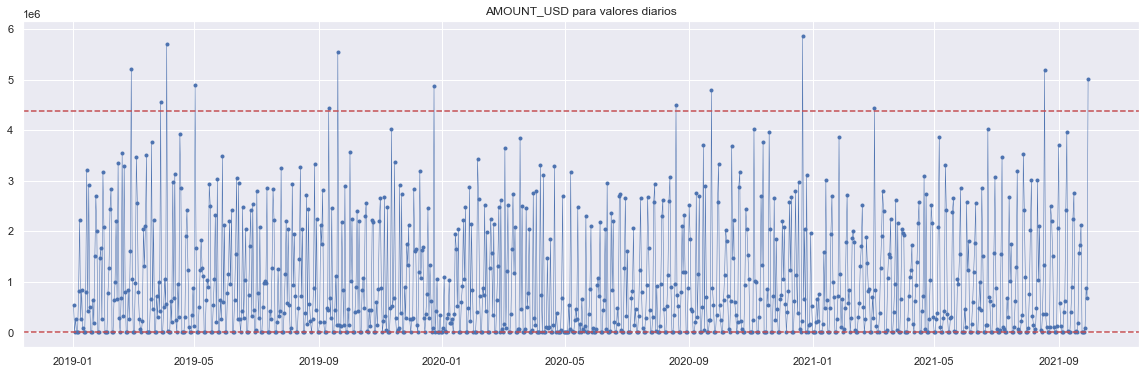

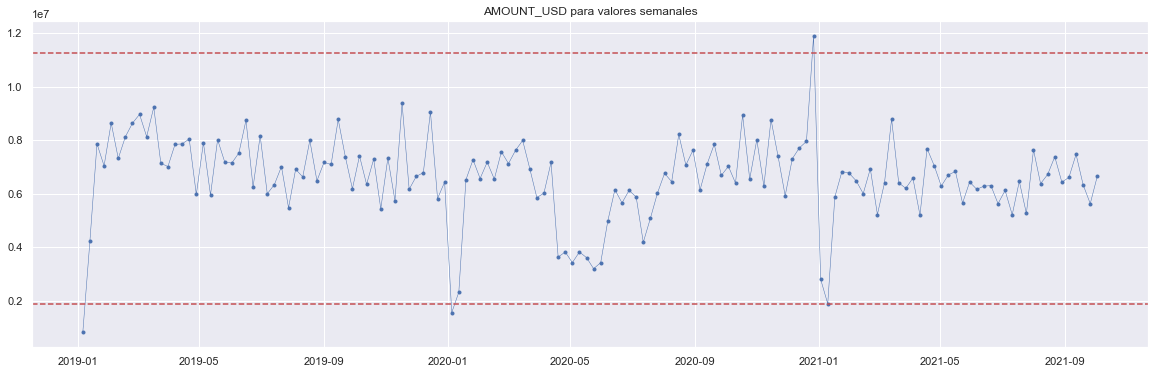

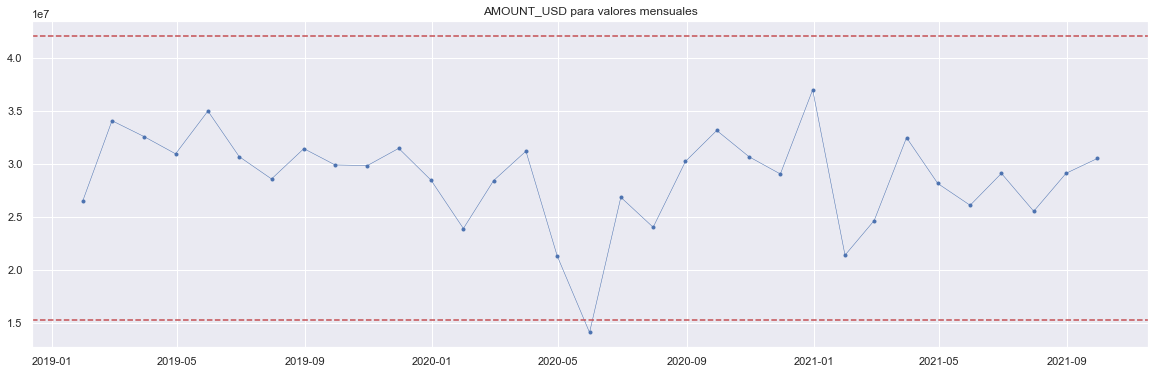

In [31]:
freqs =['D','W','M']
title_amount_usd = ['AMOUNT_USD para valores diarios','AMOUNT_USD para valores semanales','AMOUNT_USD para valores mensuales']

# Iteraremos sobre freqs para las frecuencias y sobre title_exp para los titulos de los graficos.
for freq, title in zip(freqs, title_amount_usd):
    
    # Vamos a plotear nuestra variable AMOUNT_USD contra la variable tiempo=[dia,semana y mes]
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(Exportaciones_graph.resample(freq).sum(),marker='.', linestyle='-', linewidth=0.5)
    ax.set_title(label=title)
    
    # Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3.
    ax.axhline(np.mean(Exportaciones_graph.resample(freq).sum())[0] + Exportaciones_graph.resample(freq).sum().std()[0] * 3.0, ls='--', c='r')

    # El np.where aparece como condicional para que en el grafico de frequencia diaria, la franja inferior no aparezca en valores negativos lo cual no tiene sentido.
    ax.axhline(np.where(
                        (Exportaciones_graph.resample(freq).sum().mean()[0] - Exportaciones_graph.resample(freq).sum().std()[0] * 3) > 0,   # La condicion
                         Exportaciones_graph.resample(freq).sum().mean()[0] - Exportaciones_graph.resample(freq).sum().std()[0] * 3,        # Nos devuelve nuestra ecuacion cuando se cumple.
                         0),                                                                                                                # Cuando la franja inferior no sea mayor a 0, nos devuelve 0.
                         ls='--', c='r')
    plt.show()


In [32]:
"""Para varios dias el valor es 0, vamos a intentar ve si el grafico mejora sacando los null values"""

'Para varios dias el valor es 0, vamos a intentar ve si el grafico mejora sacando los null values'

In [33]:
# Creamos un nuevo dataframe basado en Exportaciones_graph, vamos a dropear los dias que tengan valores = 0.
df_sampled_D = Exportaciones_graph.resample('D').sum()

# Reemplazamos los valores 0 por NaN.
df_sampled_D = df_sampled_D[df_sampled_D.AMOUNT_USD != 0]

# Traigamos las primeras 5 filas del dataframe.
df_sampled_D.head()

AMOUNT_USD
DATE                  
2019-01-02      541028
2019-01-03        9792
2019-01-04      265432
2019-01-07      816034
2019-01-08     2225421

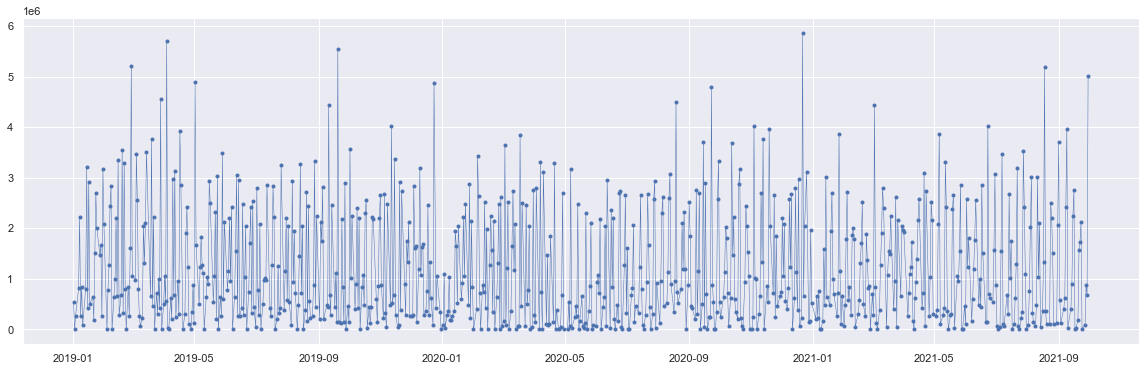

In [34]:
# Ploteamos el grafico diario de AMOUNT_USD sin null values.
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_sampled_D,marker='.', linestyle='-', linewidth=0.5)
plt.show()

In [35]:
"""Si bien mejora el aspecto un poco, creo que es muy dificil obtener algun insight a simple vista con los valores diarios. Vamos a probar como ultimo, valores diarios pero como promedio de los ultimos 7 dias."""

'Si bien mejora el aspecto un poco, creo que es muy dificil obtener algun insight a simple vista con los valores diarios. Vamos a probar como ultimo, valores diarios pero como promedio de los ultimos 7 dias.'

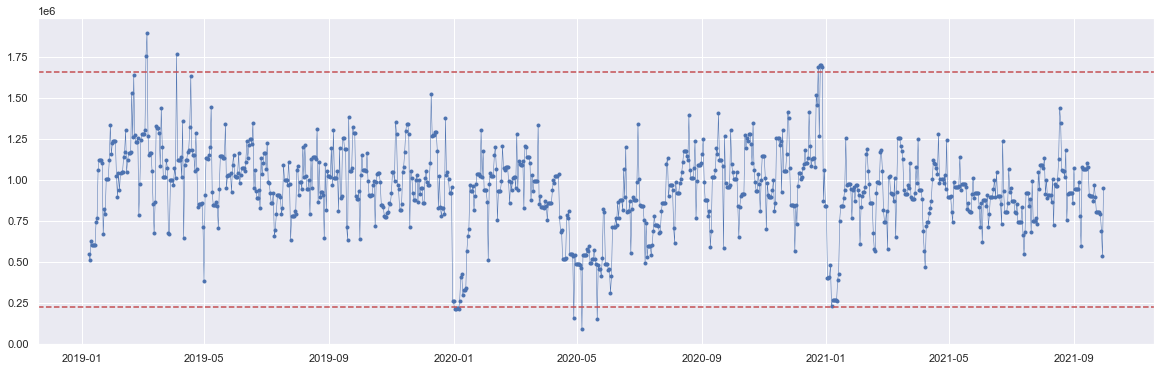

In [36]:
# Ploteamos el grafico diario de AMOUNT_USD, utilizando su promedio de los ultimos 7 dias.
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(Exportaciones_graph.resample('D').sum().rolling(window=7).mean(),marker='.', linestyle='-', linewidth=0.5)

# Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3.
ax.axhline(Exportaciones_graph.resample('D').sum().rolling(window=7).mean().mean()[0] + Exportaciones_graph.resample('D').sum().rolling(window=7).mean().std()[0] * 3.0, ls='--', c='r')
ax.axhline(Exportaciones_graph.resample('D').sum().rolling(window=7).mean().mean()[0] - Exportaciones_graph.resample('D').sum().rolling(window=7).mean().std()[0] * 3, ls='--', c='r')
plt.show()

In [37]:
"""Como usamos rolling=7, es parecido al semanal aunque obviamente no igual. Sin embargo es mas facil visualmente de entenderlo."""

'Como usamos rolling=7, es parecido al semanal aunque obviamente no igual. Sin embargo es mas facil visualmente de entenderlo.'

#### Conclusion, AMOUNT_USD, RESAMPLING DAILY, WEEKLY Y MONTHLY.

Aclaracion: Elegi 3 desvios estandar de la media como linea a graficar, como eje de referencia. Podria haber usado 2 y 2,5 que tambien se usan, pero me parecio mas acorde dado que los otros me dejaban muchos datos como posibles 'Outliers'.

Conclusiones extraidas del grafico con valores diarios (rolling = 7): 
En el diario podemos ver que a principio de año las ventas son bajas, si bien tenemos informacion continua solo para 2 años (ya que arranca en 2019 y no sabemos como venian en 2018). 
- Un supuesto que se me puede ocurrir es que son productos que los consimudores stackean pero no a gran medida, entonces las empresas capaz las compras tratan de stockearse un poco en la ultima semana de diciembre para que entre en ese ejercicio fiscal, en los graficos podemos ver que antes de la caida para la primera semana de enero se da una subida en las ultimas de diciembre, asi que seria una buena primer hipotesis para investigar, entre otras.
- Otra Hipotesis al porque las ventas bajan al principio de año y suben un poco los dias anteriores, puede venir por el lado de la cadena logistica de exportacion, menos personal a lo largo de la cadena haciendo que esta sea mas lenta y que los clientes eviten comprar a principio de año y se stockeen los dias anteriores.

Podemos observar que el valor diario del promedio de los ultimos 7 dias es estable, se encuentra en el rango entre 50.000 y 150.000 dolares mayormente, si sacamos los outliers de los principios de año y el que se da cercano a mayo 2020 (Posiblemente relacionado con el COVID y sus efectos), el rango lo respeta para casi todo el periodo.

Conclusiones extraidas del grafico con valores semanales: 
- Son parecidas al diario con rolling mean de 7 dias. Lo que si se diferencia que aqui la media se encuentra encerrada en general en un rango menor (menor varianza pareciera), y ese rango es inferior ya que va desde los 60.000 dolares a los 80.000 dolares, aunque no es tan respetado como el rango que habiamos fijado para el grafico diario, lo cual tiene sentido porque es un rango notablemente inferior.

Conclusiones extraidas del grafico con valores mensuales: 
- En este grafico ya no es visible aunque a simple vista que las ventas suben a fin de año y bajan a principio de año. Capaz si para 2021 pero no para 2020.
- Podemos observar una caida en Abril, Mayo y Junio 2020, esto muy probablemente este relacionado con el COVID-19.


Estos analisis a nivel agregado los dejaremos aqui, dado que a nivel agregado es una agrupacion de empresas que seguramente fueron respondiendo de distintas maneras a distintos estimulos, entonces puede ser que haya distinto shocks de fondo para cada empresa e incluso otros shocks que estan tapados al verlo a nivel general (Por ejemplo si 'x' empresa cayo pero 'y' empresa subio estos efectos pueden contrarestarse aunque sea parcialmente y a nivel agregado no haber cambios). Al mismo tiempo para entender estos puntos que fuimos marcando, me parece siempre mas productivo tratar de entender individualmente que le fue pasando a cada empresa.


### CANTIDAD_DE_ORDENES, RESAMPLING DAILY, WEEKLY Y MONTHLY.

Cantidad de Ordenes se refiere respecto a productos, y cada valor corresponde a una entrada. Es poseemos la informacion para asumir la cantidad de ordenes incluida en una misma orden, asi que todas seran = 1.
Estas las analizaremos en las frecuencias temporales diarias, semanales y mensuales.

In [38]:
# Vamos a crear un nuevo dataframe, en este contaremos la cantidad de ordenes.
Exportaciones_graph_2 = Exportaciones_index.copy()

# Como cada fila es una orden, simplemente todos nuestros valores seran = 1.
Exportaciones_graph_2['CANTIDAD_DE_ORDENES'] = 1

# Dropearemos las columnas que no utilizaremos.
Exportaciones_graph_2.drop(columns=['AMOUNT_USD','EMPRESAS'], inplace=True, errors='ignore')

# Observemos que nuestro dataframe tenga 74561 valores.
Exportaciones_graph_2.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74561 entries, 2021-09-03 to 2019-01-14
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT_DESCRIPTION  74561 non-null  object
 1   DESTINATION_COUNTRY  74561 non-null  object
 2   CANTIDAD_DE_ORDENES  74561 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


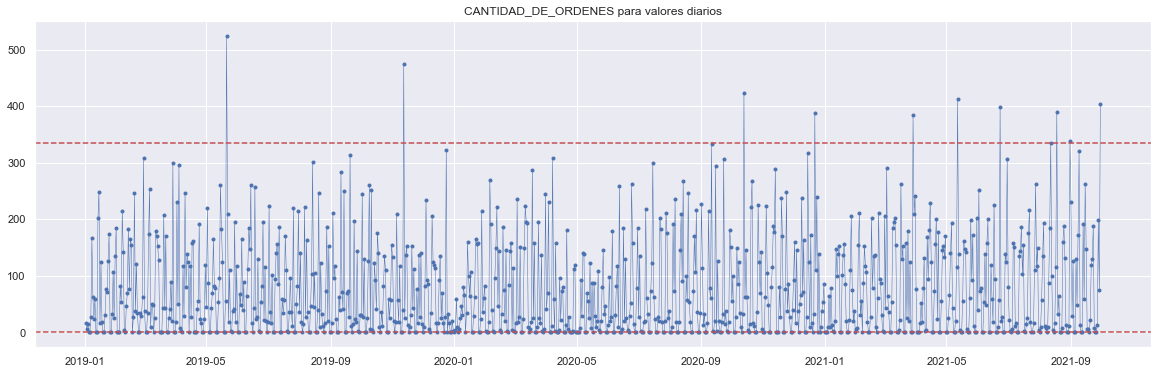

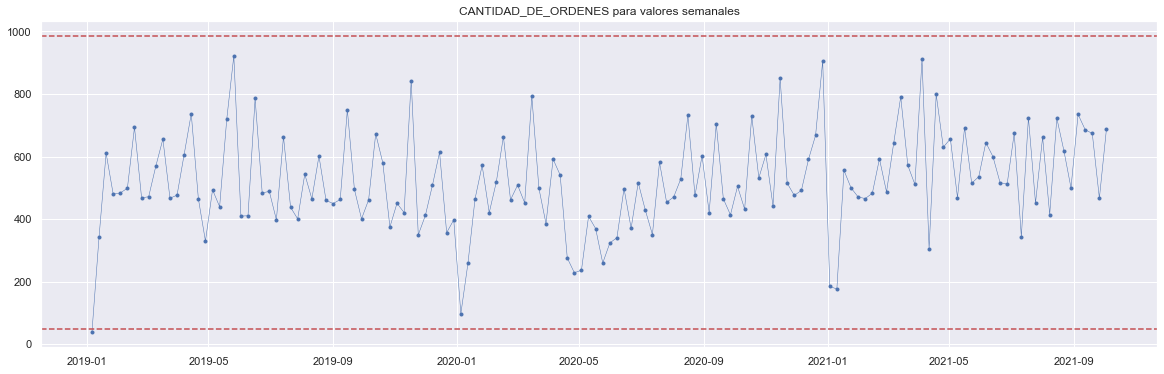

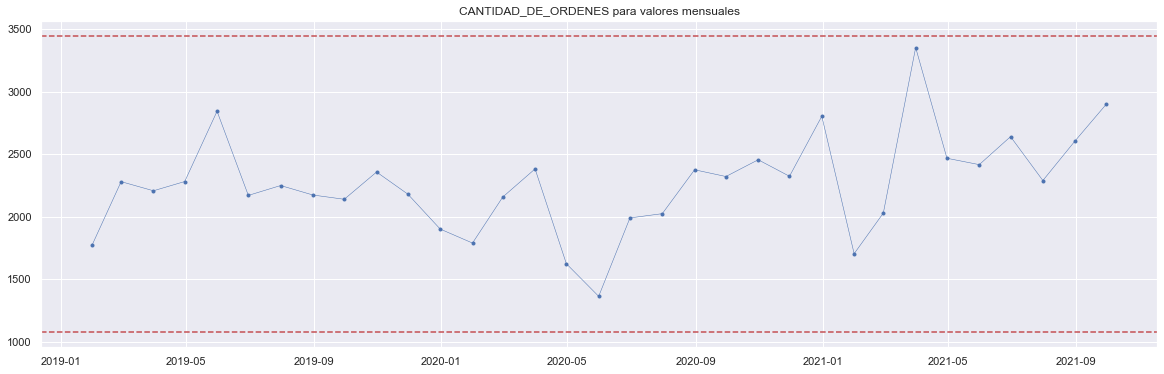

In [39]:
title_cantidad_de_ordenes = ['CANTIDAD_DE_ORDENES para valores diarios','CANTIDAD_DE_ORDENES para valores semanales','CANTIDAD_DE_ORDENES para valores mensuales']

# Iteraremos sobre freqs para las frecuencias y sobre title_exp para los titulos de los graficos.
for freq, title in zip(freqs, title_cantidad_de_ordenes):
    
    # Vamos a plotear nuestra variable AMOUNT_USD contra la variable tiempo=[dia,semana y mes]
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(Exportaciones_graph_2.resample(freq).sum(),marker='.', linestyle='-', linewidth=0.5)
    ax.set_title(label=title)

    # Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3.
    ax.axhline(np.mean(Exportaciones_graph_2.resample(freq).sum())[0] + Exportaciones_graph_2.resample(freq).sum().std()[0] * 3.0, ls='--', c='r')

    # El np.where aparece como condicional para que en el grafico de frequencia diaria, la franja inferior no aparezca en valores negativos lo cual no tiene sentido.
    ax.axhline(np.where(
                        (Exportaciones_graph_2.resample(freq).sum().mean()[0] - Exportaciones_graph_2.resample(freq).sum().std()[0] * 3) > 0,   # La condicion
                         Exportaciones_graph_2.resample(freq).sum().mean()[0] - Exportaciones_graph_2.resample(freq).sum().std()[0] * 3,        # Nos devuelve nuestra ecuacion cuando se cumple.
                         0),                                                                                                                # Cuando la franja inferior no sea mayor a 0, nos devuelve 0.
                         ls='--', c='r')
    
    plt.show()

In [40]:
"""Seguiremos un procedimiento parecido al que hicimos en AMOUNT_USD dado que el grafico con valores diarios es dificil de interpretar.
    Primero eliminare los null values vere como queda y sino utilizare una media semanal movil."""

'Seguiremos un procedimiento parecido al que hicimos en AMOUNT_USD dado que el grafico con valores diarios es dificil de interpretar.\n    Primero eliminare los null values vere como queda y sino utilizare una media semanal movil.'

In [41]:
# Creamos un nuevo dataframe, en el cual dropearemos los valores nulos.
Cantidad_de_ordenes_D = Exportaciones_graph_2.resample('D').sum()

# Filtramos nuestro dataframe por valores distintos a 0.
Cantidad_de_ordenes_D = Cantidad_de_ordenes_D[Cantidad_de_ordenes_D.CANTIDAD_DE_ORDENES != 0]

# Traigamos las primeras 5 filas del dataframe.
Cantidad_de_ordenes_D.head()

CANTIDAD_DE_ORDENES
DATE                           
2019-01-02                   16
2019-01-03                    7
2019-01-04                   15
2019-01-07                   28
2019-01-08                  167

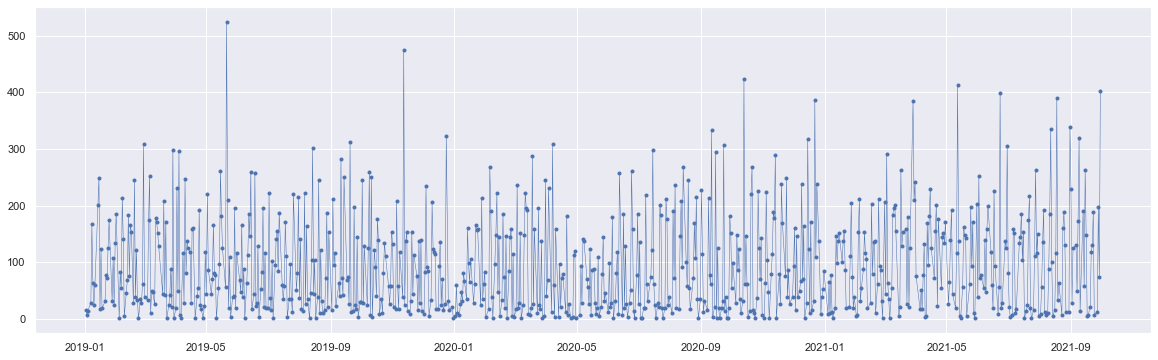

In [42]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(Cantidad_de_ordenes_D,marker='.', linestyle='-', linewidth=0.5)
plt.show()

In [43]:
"""Sigue sin ser claro ninguna tendencia, patrones o cualquier insight que se pueda sacar a simple vista."""

'Sigue sin ser claro ninguna tendencia, patrones o cualquier insight que se pueda sacar a simple vista.'

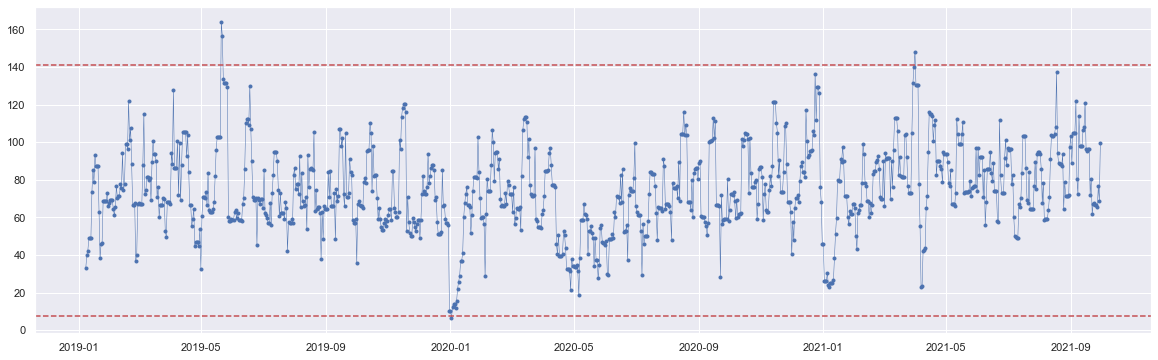

In [44]:
# Ploteamos el grafico diario de CANTIDAD_DE_ORDENES, utilizando su promedio de los ultimos 7 dias.
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(Exportaciones_graph_2.resample('D').sum().rolling(window=7).mean(),marker='.', linestyle='-', linewidth=0.5)

# Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3.
ax.axhline(Exportaciones_graph_2.resample('D').sum().rolling(window=7).mean().mean()[0] + Exportaciones_graph_2.resample('D').sum().rolling(window=7).mean().std()[0] * 3.0, ls='--', c='r')
ax.axhline(Exportaciones_graph_2.resample('D').sum().rolling(window=7).mean().mean()[0] - Exportaciones_graph_2.resample('D').sum().rolling(window=7).mean().std()[0] * 3, ls='--', c='r')
plt.show()

#### Conclusion, CANTIDAD_DE_ORDENES, RESAMPLING DAILY, WEEKLY Y MONTHLY.

Aclaracion: Elegi 3 desvios estandar de la media como linea a graficar, como eje de referencia. Aqui segui usando 3 para seguir la misma linea de los graficos anteriores.

Conclusiones extraidas del grafico con valores diarios (rolling = 7): 
En el diario podemos ver que a principio de año las ventas son bajas, si bien tenemos informacion continua solo para 2 años (ya que arranca en 2019 y no sabemos como venian en 2018). 
- Un supuesto que se me puede ocurrir es que son productos que los consimudores stackean pero no a gran medida, entonces las empresas capaz las compras tratan de stockearse un poco en la ultima semana de diciembre para que entre en ese ejercicio fiscal, en los graficos podemos ver que antes de la caida para la primera semana de enero se da una subida en las ultimas de diciembre, asi que seria una buena primer hipotesis para investigar, entre otras.
- Otra Hipotesis al porque las ventas bajan al principio de año y suben un poco los dias anteriores, puede venir por el lado de la cadena logistica de exportacion, menos personal a lo largo de la cadena haciendo que esta sea mas lenta y que los clientes eviten comprar a principio de año y se stockeen los dias anteriores.

Podemos observar que el valor diario del promedio de los ultimos 7 dias es estable, se encuentra en el rango entre 50.000 y 150.000 dolares mayormente, si sacamos los outliers de los principios de año y el que se da cercano a mayo 2020 (Posiblemente relacionado con el COVID y sus efectos), el rango lo respeta para casi todo el periodo.

Conclusiones extraidas del grafico con valores semanales: 
- Son parecidas al diario con rolling mean de 7 dias. Lo que si se diferencia que aqui la media se encuentra encerrada en general en un rango menor (menor varianza pareciera), y ese rango es inferior ya que va desde los 60.000 dolares a los 80.000 dolares, aunque no es tan respetado como el rango que habiamos fijado para el grafico diario, lo cual tiene sentido porque es un rango notablemente inferior.

Conclusiones extraidas del grafico con valores mensuales: 
- En este grafico ya no es visible aunque a simple vista que las ventas suben a fin de año y bajan a principio de año. Capaz si para 2021 pero no para 2020.
- Podemos observar una caida en Abril, Mayo y Junio 2020, esto muy probablemente este relacionado con el COVID-19.


Estos analisis a nivel agregado los dejaremos aqui, dado que a nivel agregado es una agrupacion de empresas que seguramente fueron respondiendo de distintas maneras a distintos estimulos, entonces puede ser que haya distinto shocks de fondo para cada empresa e incluso otros shocks que estan tapados al verlo a nivel general (Por ejemplo si 'x' empresa cayo pero 'y' empresa subio estos efectos pueden contrarestarse aunque sea parcialmente y a nivel agregado no haber cambios). Al mismo tiempo para entender estos puntos que fuimos marcando, me parece siempre mas productivo tratar de entender individualmente que le fue pasando a cada empresa.


### COUNTRY_DESTINATION, RESAMPLING DAILY, WEEKLY Y MONTHLY.

In [52]:
import plotly.express as px #for visualization
gapminder_df = px.data.gapminder()

In [70]:
Not_Resto_del_Mundo = ['UNITED STATES OF AMERICA', 'MEXICO']

In [71]:
# Vamos a crear un nuevo dataframe, en este contaremos la cantidad de ordenes segun pais de destino.
Exportaciones_graph_3 = Exportaciones_index.copy()

# Todo pais que no sea Estados Unidos y Mexico, lo reclasificare como 'RESTO DEL MUNDO'. Esto se debe a la relevancia del resto de los paises que considero no significativa, entonces para darle mas poder visual al grafico los agrupo.
Exportaciones_graph_3.loc[~Exportaciones_graph_3['DESTINATION_COUNTRY'].isin(Not_Resto_del_Mundo), 'DESTINATION_COUNTRY'] = 'RESTO DEL MUNDO'

# Dropearemos las columnas que no utilizaremos.
Exportaciones_graph_3.drop(columns=['AMOUNT_USD','EMPRESAS','PRODUCT_DESCRIPTION'], inplace=True, errors='ignore')

# Observemos que nuestra columna DESTINATION_COUNTRY tenga 3 valores unicos.
print(f"La columna DESTINATION_COUNTRY tiene los siguientes valores:", *Exportaciones_graph_3.DESTINATION_COUNTRY.unique(), "\n", sep ='\n')

# Observemos que nuestro dataframe tenga 74561 valores.
print(Exportaciones_graph_3.info())

La columna DESTINATION_COUNTRY tiene los siguientes valores:
MEXICO
UNITED STATES OF AMERICA
RESTO DEL MUNDO


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74561 entries, 2021-09-03 to 2019-01-14
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DESTINATION_COUNTRY  74561 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None


In [80]:
# Generamos dummies de nuestros posibles destinos (Estados Unidos, Mexico y Resto del mundo)
Exportaciones_graph_3 = Exportaciones_graph_3.astype({'DESTINATION_COUNTRY':'category'})
Exportaciones_graph_3 = pd.get_dummies(Exportaciones_graph_3)
Exportaciones_graph_3.columns

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [86]:
Exportaciones_graph_3.columns

Index(['DESTINATION_COUNTRY_MEXICO', 'DESTINATION_COUNTRY_RESTO DEL MUNDO',
       'DESTINATION_COUNTRY_UNITED STATES OF AMERICA'],
      dtype='object')

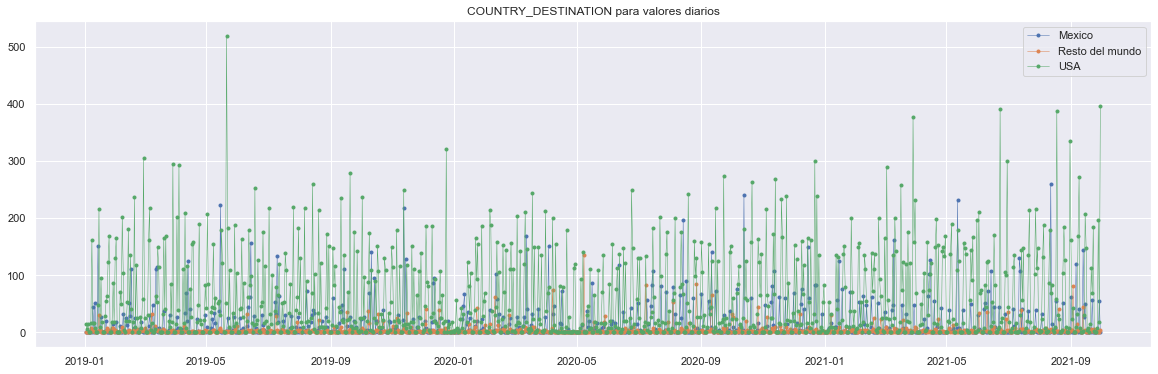

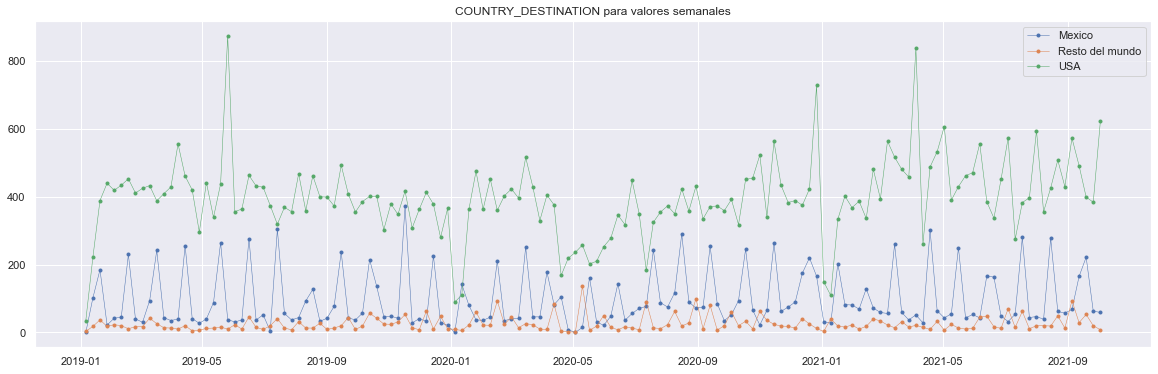

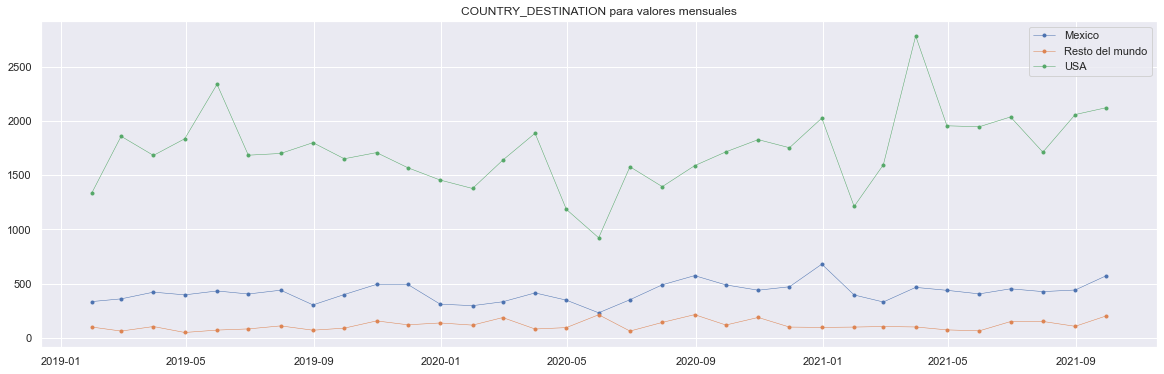

In [91]:
title_country_destination = ['COUNTRY_DESTINATION para valores diarios','COUNTRY_DESTINATION para valores semanales','COUNTRY_DESTINATION para valores mensuales']

# Iteraremos sobre freqs para las frecuencias y sobre title_exp para los titulos de los graficos.
for freq, title in zip(freqs, title_country_destination):
    
    # Vamos a plotear nuestra variable AMOUNT_USD contra la variable tiempo=[dia,semana y mes]
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(Exportaciones_graph_3.resample(freq).sum(),marker='.', linestyle='-', linewidth=0.5)
    ax.set_title(label=title)
    ax.legend(['Mexico', 'Resto del mundo', 'USA'])    
    plt.show()

#### Conclusion, COUNTRY_DESTINATION, RESAMPLING DAILY, WEEKLY Y MONTHLY.

Aclaracion: Aqui no trace las lineas de desvios estandars dado que al haber 3 variables distintas en un grafico, si lo hacia de manera general no era representativo de las variables individualmente, y si lo hacia para cada variable iban a ser 6 lineas en el grafico y le iba a quitar legibilidad. Posiblemente un analisis que quedara pendiente y mas acertado sera graficar las variables por separado para las 3 frecuencias temporales, y ahi si utilizar las franjas de 3 desvios estandar de la media para arriba y para abajo.

Conclusiones extraidas del grafico con valores diarios (rolling = 7): 
En el diario podemos ver que a principio de año las ventas son bajas, si bien tenemos informacion continua solo para 2 años (ya que arranca en 2019 y no sabemos como venian en 2018). 
- Un supuesto que se me puede ocurrir es que son productos que los consimudores stackean pero no a gran medida, entonces las empresas capaz las compras tratan de stockearse un poco en la ultima semana de diciembre para que entre en ese ejercicio fiscal, en los graficos podemos ver que antes de la caida para la primera semana de enero se da una subida en las ultimas de diciembre, asi que seria una buena primer hipotesis para investigar, entre otras.
- Otra Hipotesis al porque las ventas bajan al principio de año y suben un poco los dias anteriores, puede venir por el lado de la cadena logistica de exportacion, menos personal a lo largo de la cadena haciendo que esta sea mas lenta y que los clientes eviten comprar a principio de año y se stockeen los dias anteriores.

Podemos observar que el valor diario del promedio de los ultimos 7 dias es estable, se encuentra en el rango entre 50.000 y 150.000 dolares mayormente, si sacamos los outliers de los principios de año y el que se da cercano a mayo 2020 (Posiblemente relacionado con el COVID y sus efectos), el rango lo respeta para casi todo el periodo.

Conclusiones extraidas del grafico con valores semanales: 
- Son parecidas al diario con rolling mean de 7 dias. Lo que si se diferencia que aqui la media se encuentra encerrada en general en un rango menor (menor varianza pareciera), y ese rango es inferior ya que va desde los 60.000 dolares a los 80.000 dolares, aunque no es tan respetado como el rango que habiamos fijado para el grafico diario, lo cual tiene sentido porque es un rango notablemente inferior.

Conclusiones extraidas del grafico con valores mensuales: 
- En este grafico ya no es visible aunque a simple vista que las ventas suben a fin de año y bajan a principio de año. Capaz si para 2021 pero no para 2020.
- Podemos observar una caida en Abril, Mayo y Junio 2020, esto muy probablemente este relacionado con el COVID-19.


Estos analisis a nivel agregado los dejaremos aqui, dado que a nivel agregado es una agrupacion de empresas que seguramente fueron respondiendo de distintas maneras a distintos estimulos, entonces puede ser que haya distinto shocks de fondo para cada empresa e incluso otros shocks que estan tapados al verlo a nivel general (Por ejemplo si 'x' empresa cayo pero 'y' empresa subio estos efectos pueden contrarestarse aunque sea parcialmente y a nivel agregado no haber cambios). Al mismo tiempo para entender estos puntos que fuimos marcando, me parece siempre mas productivo tratar de entender individualmente que le fue pasando a cada empresa.


## Exportaciones.

###  Exportaciones, generales.

In [74]:
# Las variables que configuraremos a continuacion, nos ayudaran a mejorar la legibilidad de los axis de los graficos hechos posteriormente.

# Seteamos la variable locator.
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)

# Seteamos la variable formatter.
formatter = mdates.ConciseDateFormatter(locator)

# Seteamos la variable date_form para que nos de el nombre del mes.
date_form = DateFormatter("%b")

#### Exportaciones, generales, por Facturacion.

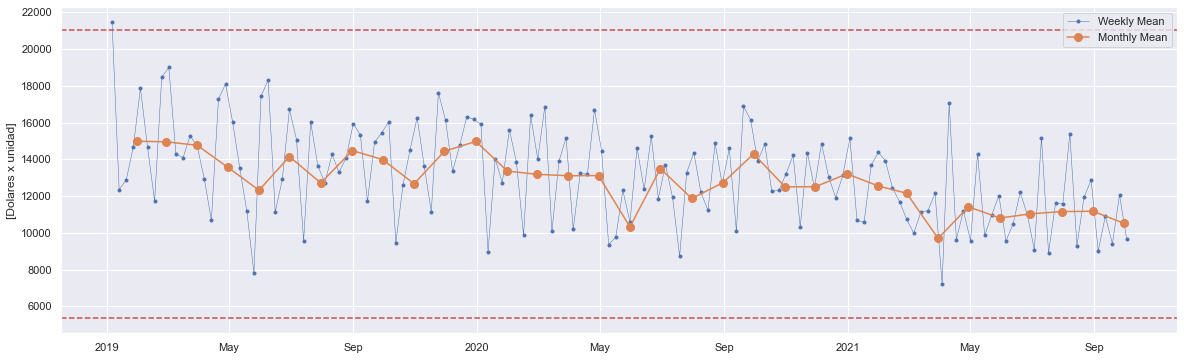

In [103]:
# Seteamos el tamaño y el formato de los subplots.
fig, ax = plt.subplots(figsize=(20, 6))

# Ploteamos el grafico de media semanal de AMOUNT_USD.
ax.plot(Exportaciones_index['AMOUNT_USD'].resample('W').mean(),marker='.', linestyle='-', linewidth=0.5, label='Weekly Mean')

# Ploteamos el grafico de media mensual de AMOUNT_USD.
ax.plot(Exportaciones_index['AMOUNT_USD'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean')

# Seteamos el label para el eje y.
ax.set_ylabel('[Dolares x unidad]')

# Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3. Estas estaran basadas en el resampling Weekly.
ax.axhline(np.mean(Exportaciones_index['AMOUNT_USD'].resample('W').mean()) + Exportaciones_index['AMOUNT_USD'].resample('W').mean().std() * 3.0, ls='--', c='r')
ax.axhline(np.mean(Exportaciones_index['AMOUNT_USD'].resample('W').mean()) - Exportaciones_index['AMOUNT_USD'].resample('W').mean().std() * 3.0, ls='--', c='r')

# Seteamos el formato de nuestra axis x, utilizando las variables previamente definidas formatter y date_form.
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(date_form)

# Hacemos visible la leyenda.
ax.legend()

##### Conclusion, Exportaciones, generales, por Facturacion.

Aclaracion: Si hubiera tenido mas tiempo hubiera intentado hacer un grafico iterativo con Dash y Plotly, donde puedas ir cambiando la fecha o el cursor sobre los datos y te diga la informacion, no es algo que maneje a la perfeccion pero es algo que conozco.



#### Exportaciones, generales, por cantidad de ordenes de productos.

In [78]:
Exportaciones_index_2 = Exportaciones_index.copy()
Exportaciones_index_2 = Exportaciones_index_2.reset_index()
Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'] = Exportaciones_index_2.groupby('DATE')['EMPRESAS'].transform('count')
Exportaciones_index_2 = Exportaciones_index_2.set_index('DATE')
Exportaciones_index_2

PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   
...                                            ...         ...   
2019-01-08                       VALVULA SOLENOIDE       10260   
2019-01-15                       VALVULA SOLENOIDE        8469   
2019-01-25                  SPOOL VALVE R70 VCM FR       11385   
2019-01-29                      HERRAJES METALICOS         219   
2019-01-14                         TUERCA DE ACERO          18   

                 DESTINATION_COUNTRY  EMPRESAS  CANTIDAD_DE_OPERACIONES  
DATE                                                                     
2021-09-03                    MEXICO         4                      126  
2021-09-30  UNITED STATES OF AMERICA         1                      403  
2021-09-30  UNITED STATES OF AMERICA         3                      403  
2021-09-01  UNITED STATES OF AMERICA         5                      230  
2021-09-06                    MEXICO         3                      130  
...                              ...       ...                      ...  
2019-01-08  UNITED STATES OF AMERICA         1                      167  
2019-01-15  UNITED STATES OF AMERICA         1                      249  
2019-01-25  UNITED STATES OF AMERICA         1                      174  
2019-01-29  UNITED STATES OF AMERICA         5                      107  
2019-01-14                    MEXICO         3                      202  

[74561 rows x 5 columns]

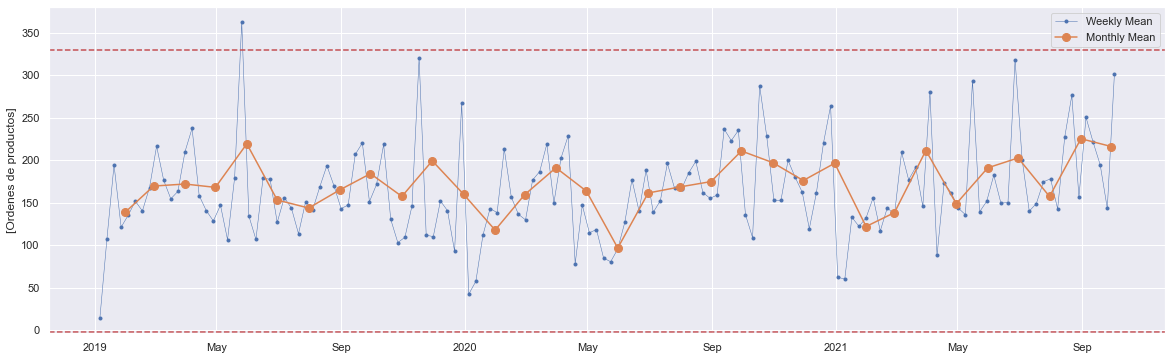

In [104]:
# Seteamos el tamaño y el formato de los subplots.
fig, ax = plt.subplots(figsize=(20, 6))

# Ploteamos el grafico de media semanal de CANTIDAD_DE_OPERACIONES.
ax.plot(Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('W').mean(),marker='.', linestyle='-', linewidth=0.5, label='Weekly Mean')

# Ploteamos el grafico de media mensual de CANTIDAD_DE_OPERACIONES.
ax.plot(Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean')

# Vamos a crear dos franjas, basados en la media para toda la serie, +/- el desvio estandar * 3. Estas estaran basadas en el resampling Weekly.
ax.axhline(np.mean(Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('W').mean()) + Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('W').mean().std() * 3.0, ls='--', c='r')
ax.axhline(np.mean(Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('W').mean()) - Exportaciones_index_2['CANTIDAD_DE_OPERACIONES'].resample('W').mean().std() * 3.0, ls='--', c='r')

# Seteamos el label para el eje y.
ax.set_ylabel('[Ordenes de productos]')

# Seteamos el formato de nuestra axis x, utilizando las variables previamente definidas formatter y date_form.
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(date_form)

# Hacemos visible la leyenda.
ax.legend()

##### Conclusion, Exportaciones, generales, por cantidad de ordenes de productos.

### Exportaciones, por empresas.

Analizaremos las exportaciones a nivel empresas, tanto por cantidad de operaciones como por monto total de facturacion.

#### Cantidad de operaciones por Empresa.
Tenemos 74.561 operaciones en total de las cuales corresponden: 
- 17.142 a la empresa 1, 
- 14.664 a la empresa 2, 
- 13.612 a la empresa 3, 
- 11.570 a la empresa 4, 
- 11.344 a la empresa 5 y 
- 6.229 a la empresa 6.

In [105]:
# Cantidad de operaciones por empresa.
Exportaciones.EMPRESAS.value_counts()

1    17142
2    14664
3    13612
4    11570
5    11344
6     6229
Name: EMPRESAS, dtype: int64

In [106]:
# Cantidad de operaciones en total.
Exportaciones.EMPRESAS.value_counts().sum()

74561

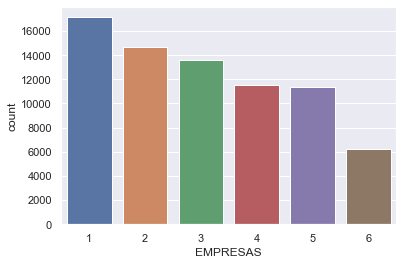

In [107]:
# Grafico contabilizando transacciones por empresas.
fig = sns.countplot(x = Exportaciones.EMPRESAS)
plt.show()

In [298]:
# Vamos a hacer un pie chart interactivo del porcentaje que represento cada empresa del total.
fig = px.pie(Exportaciones, values=Exportaciones.EMPRESAS.value_counts(), names=Exportaciones.EMPRESAS.value_counts().index)
fig.show()

# Si clickeamos las empresas a la derecha podemos ver como se compondria la cartera sacando ciertas empresas.

##### Conclusion, Cantidad de operaciones por empresa.

- Por cantidad de ordenes el 50% de los clientes, empresa 1, 2 y 3, representan el 60% de la cantidad de ordenes. Sin embargo sacando la empresa 6 que en cantidad de ordenes es un salto casi del 50% del ultimo valor, el resto de las empresas esta escalonado sin grandes diferencias en cuanto a cantidad de ordenes.
- De todas formas, si bien siempre es interesante saber como se componen las ordenes, creo que en general el analisis de mayor interes es segun facturacion total. 
- No obstante es importante hacer este analisis, porque podemos descubrir datos fuera de lo normal que podrian ser importantes para nuestro negocio, por ejemplo que un cliente sea el 90% de las ordenes pero en cuanto a facturacion presente un bajo porcentaje del total, ese dato seria importante de considerar a la hora de trabajar con el mismo y evaluar los esfuerzos que se hacen en el mismo. 
- Esto es solo un ejemplo pueden pasar muchas situaciones particulares, por eso siempre es importante tratar de analizar todas las variables que tengamos en un dataset, y ver si pueden aportarnos informacion importante para nuestro negocio.
- Tambien es importante siempre antes de empezar a analizar las variables plantear distintas posibles hipotesis, porque si lo hacemos una vez que ya vimos los resultados tenemos mayor probabilidad de sesgar nuestro juicio en ciertas situaciones.

#### Facturacion por empresa.

Tenemos un total facturable en dolares de 946.809.377 los cuales se distribuyen:
- 243.792.444 de la empresa 1,
- 271.812.063 de la empresa 2,
- 36.778.377  de la empreas 3,
- 245.708.847 de la empreas 4,
- 106.173.999 de la empresa 5 y
- 42.543.647  de la empresa 6.

Ordenado por valores decreciente serian:
- 271.812.063 de la empresa 2,
- 245.708.847 de la empreas 4,
- 243.792.444 de la empresa 1,
- 106.173.999 de la empresa 5,
- 42.543.647  de la empresa 6 y
- 36.778.377  de la empreas 3.

In [108]:
# Creamos una tabla pivot para ver el valor de los montos, agrupado por empresas y ordenado por total de facturacion.
USD_por_empresa = Exportaciones.pivot_table(index='EMPRESAS', values='AMOUNT_USD', aggfunc=np.sum)

# Ordenamos los valores segun AMOUNT_USD en order descendiente.
USD_por_empresa.sort_values(by='AMOUNT_USD', ascending=False)

AMOUNT_USD
EMPRESAS            
2          271812063
4          245708847
1          243792444
5          106173999
6           42543647
3           36778377

In [109]:
# Calculamos el total de facturacion.
Total_Expo_USD = np.sum(Exportaciones.AMOUNT_USD)
Total_Expo_USD

946809377

In [304]:
# Hacemos un grafico de barras de las ventas por empresa.
fig = px.bar(USD_por_empresa, y=USD_por_empresa.AMOUNT_USD, x=USD_por_empresa.index)
fig.show()

##### Conclusion, Facturacion por empresa.

- Si bien los porcentajes se van a analizar mas en profundo en la siguiente seccion, se puede ver a simple vista en el grafico de arriba que existen 3 clientes (1,2 y 4) que son notablemente superiores a los otros 3.
- No se observan grandes diferencias entre los 3 principales clientes.
- Entre los 3 clientes con menos facturacion (3,5 y 6), podriamos decir como que 5 estaria un escalon mas arriba si los agruparamos. 
- Para mi una agrupacion a simple vista por facturacion seria: (1, 2 y 4), 5 y (3,6).
- La ultima agrupacion es meramente intuitiva y basada en facturacion. En la practica tambien podriamos ver a que industria pertenece a cada una, si corresponden a la misma industria, que tipo de productos exportan, etc.

#### Proporcion de cartera por empresa.

El orden segun importancia por facturacion fue:
- Empresa 2 con el 28.7%,
- Empresa 4 con el 26.0%,
- Empresa 1 con el 25.7%,
- Empresa 5 con el 11.2%,
- Empresa 6 con el 4.5% y
- Empresa 3 con el 3.9%.

In [112]:
# Calculamos las exportaciones por empresa.
Por_Empresa = Exportaciones.groupby('EMPRESAS').sum('AMOUNT_USD')
Por_Empresa

AMOUNT_USD
EMPRESAS            
1          243792444
2          271812063
3           36778377
4          245708847
5          106173999
6           42543647

In [117]:
# Realizaremos un pie chart con plotly, lo que permitira que el mismo sea interactivo.
fig = px.pie(Por_Empresa, values='AMOUNT_USD', names=Por_Empresa.index, title='Composicion de cartera por empresas, segun facturacion')
fig.show()

# Al ser un grafico de plotly, podemos clickear a la derecha algun cliente, para ver como se compondria nuestra cartera si perdieramos ese cliente.

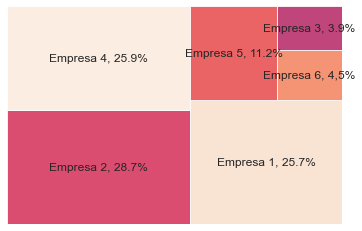

In [119]:
# Hagamos tambien un heatmap de la cartera.
squarify.plot(sizes=np.array([0.287082, 0.259512 , 0.257488, 0.112139, 0.044934, 0.038845]), label=['Empresa 2, 28.7%', 'Empresa 4, 25.9%', 'Empresa 1, 25.7%', 'Empresa 5, 11.2%', 'Empresa 6, 4,5%', 'Empresa 3, 3.9%'], alpha=.8 )
plt.axis('off')
plt.show()

##### Conclusion de la proporcion de cartera por empresa.

- Podemos ver que por facturacion, el 50% de nuestra cartera (Empresas 1, 2 y 4) representan el 80% de la facturacion.
- Al mismo tiempo estas empresas poseen porcentajes similares en un rango entre 25,7% y 28,7% cada una.
- Podemos ver tambien que la Empresa 5, es superior su porcentaje a las otras 2 empresas restantes (6 y 3).

De este analisis podriamos entender que perder a cualquiera de los 3 principales clientes tendria un costo muy alto para Mundi. 
Si bien Mundi no depende exclusivamente de esas ventas, podemos preveer que clientes con mas ventas, siendo este no el unico criterio utilizado, tienen mayor posibilidades de acceder a mayores prestamos lo que dejaria mayores comisiones a Mundi.
Tener la cartera concentrada sin embargo tiene sus beneficios y desventajas:



### Exportaciones, por pais de destino.

Vamos a analizar como se comportan las exportaciones segun destino, tanto como por cantidad de ordenes como por monto facturado.

#### Exportaciones, por pais de destino, por frecuencia.

- La mayoria de las ordenes van a Estados Unidos, significando este el 76,5% del total.
- Le sigue Mexico representando el 18,5% del total.
- El resto de los paises tiene una significancia menor al 1,5% del total.

In [125]:
# Calculamos el total de ordenes.
Total_Expo_cantidad = Exportaciones.DESTINATION_COUNTRY.value_counts().sum()

# Sacamos el total de ordenes por pais.
Expo_por_pais_cantidad = Exportaciones.DESTINATION_COUNTRY.value_counts().sort_values(ascending=False)

# Vemos los valores.
Expo_por_pais_cantidad

UNITED STATES OF AMERICA                                57031
MEXICO                                                  13786
FRANCE                                                    960
SAUDI ARABIA                                              749
CANADA                                                    557
GERMANY                                                   333
JAPAN                                                     217
POLAND                                                    191
BRAZIL                                                    174
CHINA                                                     153
CZECH REPUBLIC                                            132
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND       90
THAILAND                                                   66
SPAIN                                                      32
REPUBLIC OF KOREA                                          25
PORTUGAL                                                   19
ITALY   

In [126]:
# Calculamos el porcentaje que cada pais representa.
Expo_proporcion_pais_cantidad = Expo_por_pais_cantidad / Total_Expo_cantidad

# Le damos formato porcentaje.
Expo_pct_cantidad = Expo_proporcion_pais_cantidad * 100
Expo_pct_cantidad.map('{:,.2f}%'.format)

UNITED STATES OF AMERICA                                76.49%
MEXICO                                                  18.49%
FRANCE                                                   1.29%
SAUDI ARABIA                                             1.00%
CANADA                                                   0.75%
GERMANY                                                  0.45%
JAPAN                                                    0.29%
POLAND                                                   0.26%
BRAZIL                                                   0.23%
CHINA                                                    0.21%
CZECH REPUBLIC                                           0.18%
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND     0.12%
THAILAND                                                 0.09%
SPAIN                                                    0.04%
REPUBLIC OF KOREA                                        0.03%
PORTUGAL                                               

In [127]:
# Obtenemos cuanto suman los paises con menos de 1000 ordenes.
Expo_por_pais_cantidad_menor_1000 = Expo_por_pais_cantidad[Expo_por_pais_cantidad < 1000].sum()
Expo_por_pais_cantidad_menor_1000

3744

In [274]:
fig = px.bar(y = Expo_por_pais_cantidad[Expo_por_pais_cantidad > 1000], 
                x = Expo_por_pais_cantidad[Expo_por_pais_cantidad > 1000].index,
                labels={'y':'Dolares x Unidad','x':'Pais'})
fig.show()

#### Exportaciones, por pais de destino, por facturacion.

- La mayoria de las facturaciones son realizadas a Estados Unidos, significando el 91,5% del total.
- Le sigue Mexico representando el 6,5% del total.
- El resto de los paises tiene una significancia menor al 1% segun facturacion.

In [129]:
# Calculamos el total facturable de exportaciones.
Total_Expo_USD = Exportaciones.AMOUNT_USD.sum()
Total_Expo_USD


946809377

In [130]:
Expo_por_pais_USD = Exportaciones.groupby('DESTINATION_COUNTRY')['AMOUNT_USD'].sum().sort_values(ascending=False)
Expo_por_pais_USD

DESTINATION_COUNTRY
UNITED STATES OF AMERICA                                866752691
MEXICO                                                   61079063
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND      8700701
CANADA                                                    2799669
CHINA                                                     2317466
JAPAN                                                     1376078
FRANCE                                                    1269406
BRAZIL                                                    1153299
GERMANY                                                    347947
REPUBLIC OF KOREA                                          341178
POLAND                                                     251081
SAUDI ARABIA                                               152760
CZECH REPUBLIC                                              83258
SPAIN                                                       60585
THAILAND                                                

In [131]:
Expo_proporcion_pais_USD = Expo_por_pais_USD / Total_Expo_USD
Expo_pct_USD = Expo_proporcion_pais_USD * 100
Expo_pct_USD.map('{:,.2f}%'.format)

DESTINATION_COUNTRY
UNITED STATES OF AMERICA                                91.54%
MEXICO                                                   6.45%
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND     0.92%
CANADA                                                   0.30%
CHINA                                                    0.24%
JAPAN                                                    0.15%
FRANCE                                                   0.13%
BRAZIL                                                   0.12%
GERMANY                                                  0.04%
REPUBLIC OF KOREA                                        0.04%
POLAND                                                   0.03%
SAUDI ARABIA                                             0.02%
CZECH REPUBLIC                                           0.01%
SPAIN                                                    0.01%
THAILAND                                                 0.01%
TAIWAN, PROVINCE OF CHINA          

In [238]:
fig = px.scatter(Expo_por_pais_USD, x="AMOUNT_USD", y=Expo_por_pais_USD.index)
fig.show()

In [132]:
Expo_por_pais_RDM = Total_Expo_USD - np.sum(Expo_por_pais_USD[Expo_por_pais_USD >= 61079063])
Expo_por_pais_RDM

18977623

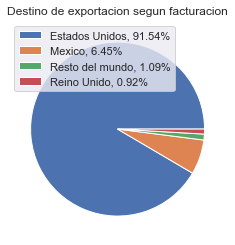

In [133]:
Proporcion_empresa = np.array([0.9154, 0.0645, (1 - np.sum([0.9154, 0.0645 , 0.0092])) , 0.0092])
plt.pie(Proporcion_empresa)
plt.legend(['Estados Unidos, 91.54%', 'Mexico, 6.45%', 'Resto del mundo, 1.09%', 'Reino Unido, 0.92%'], loc=2)
plt.title('Destino de exportacion segun facturacion')
plt.show()

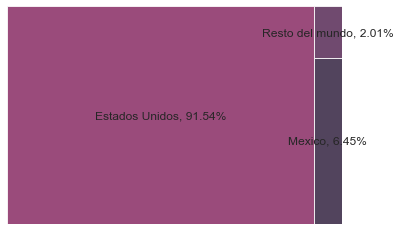

In [134]:
# Hagamos un heatmap de los destinos de exportacion segun facturacion.
squarify.plot(sizes=np.array([0.9154, 0.0645, (1 - np.sum([0.9154, 0.0645]))]), label=['Estados Unidos, 91.54%', 'Mexico, 6.45%', 'Resto del mundo, 2.01%'], alpha=.8 )
plt.axis('off')
plt.show()

## Los 5 productos mas vendidos.

Vamos a analizar cuales son los 5 productos mas vendidos, segun cantidad de ordenes y por facturacion total.

### Los 5 productos mas vendidos, por cantidad de ordenes.

- Manguera de Caucho con refuerzo textil con accesorios : 3808
- Termistor : 3131
- Contenedor PLastico : 2891
- Valvula Solenoide : 2522
- Charola de plastico : 2248

In [135]:
Exportaciones.PRODUCT_DESCRIPTION.value_counts().sort_values(ascending=False)

MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS                                                                                          3808
TERMISTOR                                                                                                                                      3131
CONTENEDOR DE PLASTICO                                                                                                                         2891
VALVULA SOLENOIDE                                                                                                                              2522
CHAROLA DE PLASTICO                                                                                                                            2248
                                                                                                                                               ... 
TORQUIMETRO MARCA: CDI TORQUE MODELO: 1001-0-ETT SERIE: 0908980383                                              

In [136]:
cantidad_a_ventas_usd = []
cantidad_a_ventas_usd.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS']['AMOUNT_USD'].sum())
cantidad_a_ventas_usd.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'TERMISTOR']['AMOUNT_USD'].sum())
cantidad_a_ventas_usd.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'CONTENEDOR DE PLASTICO']['AMOUNT_USD'].sum())
cantidad_a_ventas_usd.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'VALVULA SOLENOIDE']['AMOUNT_USD'].sum())
cantidad_a_ventas_usd.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'CHAROLA DE PLASTICO']['AMOUNT_USD'].sum())
cantidad_a_ventas_usd

[206759747, 32227405, 1027159, 113585847, 2248]

In [137]:
Productos_mas_vendidos_frecuencia = {'MANGUERA DE CAUCHO...':3808,
'TERMISTOR':3131,
'CONTENEDOR DE PLASTICO':2891,
'VALVULA SOLENOIDE':2522,
'CHAROLA DE PLASTICO':2248}

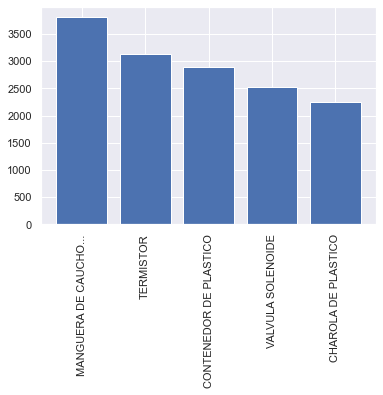

In [138]:
plt.bar(*zip(*Productos_mas_vendidos_frecuencia.items()))
plt.xticks(rotation=90)
plt.show()

### Los 5 productos mas vendidos, por facturacion.

- Manguera de caucho con refuerzo textil con accesorios : 206.759.747
- Valvula solenoide: 113.585.847
- Cuerpo de aceleracion: 76.675.460
- Lineas sanguineas ID:03-2722-9 : 49.096.507
- Inyector de gasolina : 43.775.977

In [139]:
Exportaciones.groupby('PRODUCT_DESCRIPTION').AMOUNT_USD.sum().sort_values(ascending=False).head(5)

PRODUCT_DESCRIPTION
MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS    206759747
VALVULA SOLENOIDE                                        113585847
CUERPO DE ACELERACION                                     76675460
LINEAS SANGUINEAS ID:03-2722-9                            49096507
INYECTOR DE GASOLINA                                      43775977
Name: AMOUNT_USD, dtype: int64

In [140]:
ventas_usd_a_cantidad = []
ventas_usd_a_cantidad.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS']['PRODUCT_DESCRIPTION'].value_counts())
ventas_usd_a_cantidad.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'VALVULA SOLENOIDE']['PRODUCT_DESCRIPTION'].value_counts())
ventas_usd_a_cantidad.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'CUERPO DE ACELERACION']['PRODUCT_DESCRIPTION'].value_counts())
ventas_usd_a_cantidad.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'LINEAS SANGUINEAS ID:03-2722-9']['PRODUCT_DESCRIPTION'].value_counts())
ventas_usd_a_cantidad.append(Exportaciones[Exportaciones.PRODUCT_DESCRIPTION == 'INYECTOR DE GASOLINA']['PRODUCT_DESCRIPTION'].value_counts())
ventas_usd_a_cantidad

[MANGUERA DE CAUCHO CON REFUERZO TEXTIL CON ACCESORIOS    3808
 Name: PRODUCT_DESCRIPTION, dtype: int64,
 VALVULA SOLENOIDE    2522
 Name: PRODUCT_DESCRIPTION, dtype: int64,
 CUERPO DE ACELERACION    1177
 Name: PRODUCT_DESCRIPTION, dtype: int64,
 LINEAS SANGUINEAS ID:03-2722-9    1119
 Name: PRODUCT_DESCRIPTION, dtype: int64,
 INYECTOR DE GASOLINA    342
 Name: PRODUCT_DESCRIPTION, dtype: int64]

In [141]:
Productos_mas_vendidos_facturacion  = {"MANGUERA DE CAUCHO": 206759747,
     "VALVULA SOLENOIDE": 113585847,
     "CUERPO DE ACELERACION": 76675460,
     "LINEAS SANGUINEAS ID:03-2722-9": 49096507,
     "INYECTOR DE GASOLINA": 43775977
}


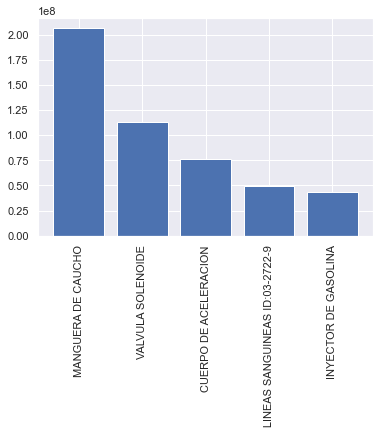

In [142]:
plt.bar(*zip(*Productos_mas_vendidos_facturacion.items()))
plt.xticks(rotation=90)
plt.show()

## Cantidad de distintos productos exportados, por empresa.

Para todas las conclusiones hechas en esta seccion, faltaria hacer un analisis mas profundo para ver si estos productos son realmente unicos, o el mismo producto con distintos nombres. Seria bueno agregar tambien un clustering de productos.

### Cantidad de distintos productos exportados, por empresa, durante todo el periodo.

Primero analizaremos cuantos productos distintos exporto cada empresa a lo largo de todo el periodo.

La cantidad de productos distintos que exporto cada empresa en orden descendiente fue:
- Empresa 2: 1903 productos.
- Empresa 5: 391 productos.
- Empresa 3: 381 productos.
- Empresa 4: 192 productos.
- Empresa 6: 183 productos.
- Empresa 1: 160 productos.

El valor sumado de todas estas variables nos da mayor a la cantidad de productos unicos que tenemos, esto significa que hay distintas empresas que exportan el mismo item y lo reportan con el mismo nombre.

In [143]:
# Creamos un dict vacio.
productos_exportados_todo_el_periodo = {}

# Iteramos del 1 al 6 para obtener la frecuencia correspondiente a cada empresa
for i in range(1,7):
    productos_exportados_todo_el_periodo[i] = Exportaciones[Exportaciones['EMPRESAS'] == i].PRODUCT_DESCRIPTION.nunique()
productos_exportados_todo_el_periodo

{1: 160, 2: 1903, 3: 381, 4: 192, 5: 391, 6: 183}

In [144]:
np.sum(list(productos_exportados_todo_el_periodo.values()))

3210

In [145]:
Exportaciones.PRODUCT_DESCRIPTION.nunique()

3139

<AxesSubplot:>

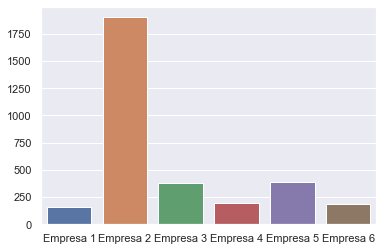

In [146]:
# Graficamos la frecuencia promedio mensual de las variables.
sns.barplot(y=list(productos_exportados_todo_el_periodo.values()), x=['Empresa 1','Empresa 2','Empresa 3','Empresa 4','Empresa 5','Empresa 6'])

### Cantidad de distintos productos exportados, por empresa, promedio anual.

### Cantidad de distintos productos exportados, por empresa, promedio mensual.

Analizaremos cuantos productos distintos exporto cada empresa en promedio por mes, a lo largo de todo el periodo.

La cantidad de productos distintos que exporto cada empresa en orden descendiente fue:
- Empresa 2: 129 productos.
- Empresa 5: 99 productos.
- Empresa 3: 60 productos.
- Empresa 1: 29 productos.
- Empresa 4 y 6: 27 productos.

In [147]:
productos_exportados_por_mes = {}
for i in range(1,7):
    productos_exportados_por_mes[i] = np.round(Exportaciones_Monthly[Exportaciones_Monthly['EMPRESAS'] == i].groupby('MONTHLY').PRODUCT_DESCRIPTION.nunique().mean(),0)
productos_exportados_por_mes

{1: 29.0, 2: 129.0, 3: 60.0, 4: 27.0, 5: 99.0, 6: 27.0}

<AxesSubplot:>

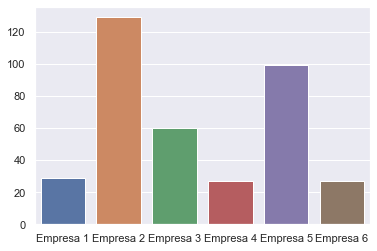

In [148]:
sns.barplot(y=list(productos_exportados_por_mes.values()), x=['Empresa 1','Empresa 2','Empresa 3','Empresa 4','Empresa 5','Empresa 6'])

In [149]:
""" Exportaciones_Date_Time = Exportaciones.set_index('DATE')
Exportaciones_1 = Exportaciones_Date_Time.groupby('EMPRESAS').resample('M').sum()
Exportaciones_1 """

" Exportaciones_Date_Time = Exportaciones.set_index('DATE')\nExportaciones_1 = Exportaciones_Date_Time.groupby('EMPRESAS').resample('M').sum()\nExportaciones_1 "

In [150]:
### Exportaciones_2 = Exportaciones_1.reset_index()
### Exportaciones_2 = Exportaciones_2.astype({'EMPRESAS':'category'})

In [151]:
""" sns.set()
g = sns.PairGrid(Exportaciones_1, x_vars = Exportaciones_1.index, y_vars= 'AMOUNT_USD', hue = 'EMPRESAS')
g.map(sns.lineplot)
plt.show()"""

" sns.set()\ng = sns.PairGrid(Exportaciones_1, x_vars = Exportaciones_1.index, y_vars= 'AMOUNT_USD', hue = 'EMPRESAS')\ng.map(sns.lineplot)\nplt.show()"

In [152]:
""" sns.set()
ax = sns.lineplot(data = Exportaciones_1[Exportaciones_1['EMPRESAS'] == '1'], x = 'DATE', y = 'AMOUNT_USD')
plt.xticks(rotation=45)
plt.show() """

### PRESENTAR ASI PARA TODAS LAS EMPRESAS, cambiar el Y label algo mas leible.

" sns.set()\nax = sns.lineplot(data = Exportaciones_1[Exportaciones_1['EMPRESAS'] == '1'], x = 'DATE', y = 'AMOUNT_USD')\nplt.xticks(rotation=45)\nplt.show() "

## Exportaciones mensuales.

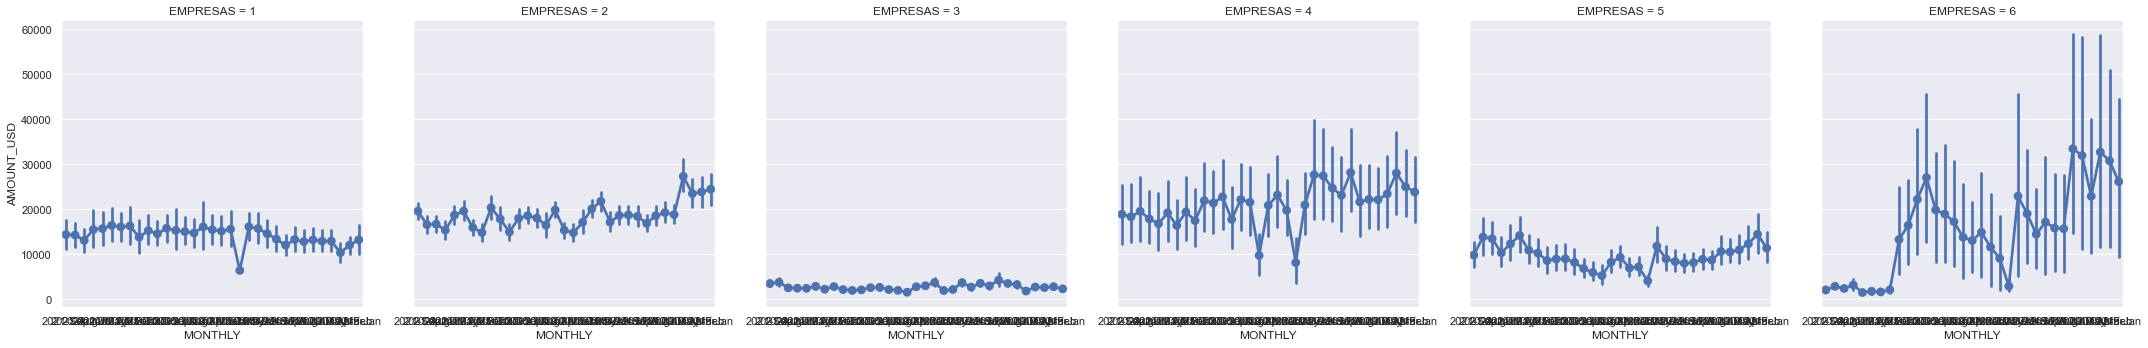

In [153]:
asd = Exportaciones_Monthly.reset_index()
sns.catplot(kind='point', data=asd, col='EMPRESAS', x='MONTHLY', y='AMOUNT_USD')

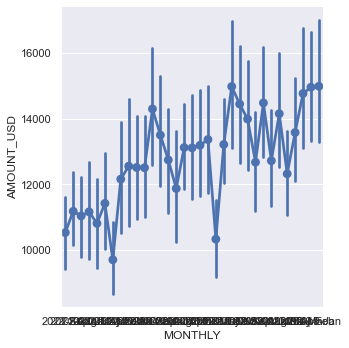

In [154]:
sns.catplot(kind='point', data=asd, x='MONTHLY', y='AMOUNT_USD')

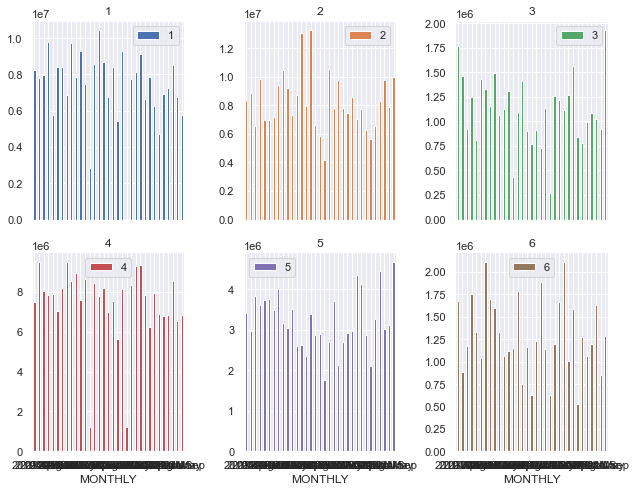

In [155]:
dfp = asd.pivot_table(index='MONTHLY', columns='EMPRESAS', values='AMOUNT_USD', aggfunc='sum')

ax1 = dfp.plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [156]:
# Veamos las exportaciones por mes, para cada empresa.
Exportaciones_Monthly.groupby(['MONTHLY','EMPRESAS']).sum()

AMOUNT_USD
MONTHLY  EMPRESAS            
2019-Apr 1            8251012
         2            8369238
         3            1765102
         4            7498485
         5            3409488
...                       ...
2021-Sep 2           10014006
         3            1928657
         4            6849606
         5            4674445
         6            1283213

[198 rows x 1 columns]

##### Maximo exportador del mes.

Chequear si esta funcionando bien.

In [157]:
a = Exportaciones_Monthly[['MONTHLY','EMPRESAS','AMOUNT_USD']].loc[Exportaciones_Monthly.groupby("MONTHLY")["AMOUNT_USD"].idxmax()]
a

MONTHLY  EMPRESAS  AMOUNT_USD
45864  2019-Apr         4      432974
54191  2019-Aug         4      544012
53162  2019-Dec         4      614829
27590  2019-Feb         4      533580
74453  2019-Jan         4      430607
35708  2019-Jul         4      627772
35958  2019-Jun         4      546276
55389  2019-Mar         4      575821
64366  2019-May         4      524342
24949  2019-Nov         4      587786
72299  2019-Oct         4      520619
6766   2019-Sep         4      625770
60692  2020-Apr         6      305468
23080  2020-Aug         4      703010
24563  2020-Dec         4      544181
33110  2020-Feb         4      469773
33238  2020-Jan         4      392983
14021  2020-Jul         4      521296
22771  2020-Jun         1      587412
61014  2020-Mar         4      592549
43333  2020-May         4      265833
58924  2020-Nov         4      642709
31223  2020-Oct         4      569452
3575   2020-Sep         4      545845
1784   2021-Apr         4      613752
66087  2021-Aug         4      501226
21704  2021-Feb         4      531709
30378  2021-Jan         4      578465
10802  2021-Jul         4      491828
864    2021-Jun         4      685638
21231  2021-Mar         4      698834
57683  2021-May         4      589017
225    2021-Sep         4      498073

## Ver dias sin ventas - NO TERMINADO.

Buscar en que dia no hubo ventas, tratar de explicar porque paso esto, fue feriado, sospechamos faltante de data, o que podemos obtener.

In [158]:
DIAS_EXISTENTES = np.arange(datetime.date(2019,1,1), datetime.date(2021,9,30), 1)
DIAS_EXISTENTES

array(['2019-01-01', '2019-01-02', '2019-01-03', ..., '2021-09-27',
       '2021-09-28', '2021-09-29'], dtype='datetime64[D]')

In [159]:
""" Exportaciones[Exportaciones['DATE'] in DIAS_EXISTENTES] """

" Exportaciones[Exportaciones['DATE'] in DIAS_EXISTENTES] "

## Estacionalidad.

Seria importante tratar de ver si hay estacionalidad en las ventas.

## PRODUCT_DESCRIPTION, busqueda de terminos similares.

## Chequear si Product description y Destination country, tienen alta correlacion para ver si son variables latentes.

## Prediccion de exportaciones por empresa.

Se realizaran distintos modelos de machine learning, para tratar de predecir las ventas por empresa para los meses 10, 11 y 12 del año 2021.

In [160]:
Exportaciones_encod = Exportaciones.copy()
Exportaciones_encod.head()

TAX_ID        DATE  \
0  949d5fa4ec6782418fda5a841e1479c8  2021-09-03   
1  49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30   
2  abe1b325d14500ddc774f2141d46637b  2021-09-30   
3  bec208a809498df9383f33067c6afbc3  2021-09-01   
4  abe1b325d14500ddc774f2141d46637b  2021-09-06   

                      PRODUCT_DESCRIPTION  AMOUNT_USD  \
0  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                      PALETA DE PLASTICO           1   
2                     CIRCUITOS MODULARES         216   
3          CONEXIONES AISLADAS - ROSCADAS          23   
4                CAJA DE CARTON CORRUGADO          59   

        DESTINATION_COUNTRY  EMPRESAS  
0                    MEXICO         4  
1  UNITED STATES OF AMERICA         1  
2  UNITED STATES OF AMERICA         3  
3  UNITED STATES OF AMERICA         5  
4                    MEXICO         3

In [161]:
Exportaciones_encod['DATE'] = pd.to_datetime(Exportaciones_encod['DATE'], errors='ignore')
# Set the date as index 
Exportaciones_encod.set_index('DATE', inplace=True)
# Drop TAX_ID
Exportaciones_encod.drop('TAX_ID', inplace =True, axis=1, errors='ignore')

Exportaciones_encod

PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   
...                                            ...         ...   
2019-01-08                       VALVULA SOLENOIDE       10260   
2019-01-15                       VALVULA SOLENOIDE        8469   
2019-01-25                  SPOOL VALVE R70 VCM FR       11385   
2019-01-29                      HERRAJES METALICOS         219   
2019-01-14                         TUERCA DE ACERO          18   

                 DESTINATION_COUNTRY  EMPRESAS  
DATE                                            
2021-09-03                    MEXICO         4  
2021-09-30  UNITED STATES OF AMERICA         1  
2021-09-30  UNITED STATES OF AMERICA         3  
2021-09-01  UNITED STATES OF AMERICA         5  
2021-09-06                    MEXICO         3  
...                              ...       ...  
2019-01-08  UNITED STATES OF AMERICA         1  
2019-01-15  UNITED STATES OF AMERICA         1  
2019-01-25  UNITED STATES OF AMERICA         1  
2019-01-29  UNITED STATES OF AMERICA         5  
2019-01-14                    MEXICO         3  

[74561 rows x 4 columns]

In [162]:
Exportaciones_encod['CANTIDAD_DE_ORDENES'] = Exportaciones_encod['EMPRESAS'].replace(to_replace=[2,3,4,5,6], value=1)
Exportaciones_encod

PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   
...                                            ...         ...   
2019-01-08                       VALVULA SOLENOIDE       10260   
2019-01-15                       VALVULA SOLENOIDE        8469   
2019-01-25                  SPOOL VALVE R70 VCM FR       11385   
2019-01-29                      HERRAJES METALICOS         219   
2019-01-14                         TUERCA DE ACERO          18   

                 DESTINATION_COUNTRY  EMPRESAS  CANTIDAD_DE_ORDENES  
DATE                                                                 
2021-09-03                    MEXICO         4                    1  
2021-09-30  UNITED STATES OF AMERICA         1                    1  
2021-09-30  UNITED STATES OF AMERICA         3                    1  
2021-09-01  UNITED STATES OF AMERICA         5                    1  
2021-09-06                    MEXICO         3                    1  
...                              ...       ...                  ...  
2019-01-08  UNITED STATES OF AMERICA         1                    1  
2019-01-15  UNITED STATES OF AMERICA         1                    1  
2019-01-25  UNITED STATES OF AMERICA         1                    1  
2019-01-29  UNITED STATES OF AMERICA         5                    1  
2019-01-14                    MEXICO         3                    1  

[74561 rows x 5 columns]

In [163]:
Exportaciones_encod_M = Exportaciones_encod.copy()

Exportaciones_encod_M

PRODUCT_DESCRIPTION  AMOUNT_USD  \
DATE                                                             
2021-09-03  MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
2021-09-30                      PALETA DE PLASTICO           1   
2021-09-30                     CIRCUITOS MODULARES         216   
2021-09-01          CONEXIONES AISLADAS - ROSCADAS          23   
2021-09-06                CAJA DE CARTON CORRUGADO          59   
...                                            ...         ...   
2019-01-08                       VALVULA SOLENOIDE       10260   
2019-01-15                       VALVULA SOLENOIDE        8469   
2019-01-25                  SPOOL VALVE R70 VCM FR       11385   
2019-01-29                      HERRAJES METALICOS         219   
2019-01-14                         TUERCA DE ACERO          18   

                 DESTINATION_COUNTRY  EMPRESAS  CANTIDAD_DE_ORDENES  
DATE                                                                 
2021-09-03                    MEXICO         4                    1  
2021-09-30  UNITED STATES OF AMERICA         1                    1  
2021-09-30  UNITED STATES OF AMERICA         3                    1  
2021-09-01  UNITED STATES OF AMERICA         5                    1  
2021-09-06                    MEXICO         3                    1  
...                              ...       ...                  ...  
2019-01-08  UNITED STATES OF AMERICA         1                    1  
2019-01-15  UNITED STATES OF AMERICA         1                    1  
2019-01-25  UNITED STATES OF AMERICA         1                    1  
2019-01-29  UNITED STATES OF AMERICA         5                    1  
2019-01-14                    MEXICO         3                    1  

[74561 rows x 5 columns]

### DICT.

In [164]:
# Obtenemos el nombre de las empresas.
Empresas_names = Exportaciones_encod_M.EMPRESAS.unique()

# Creamos un dict para las empresas.
Empresas_dict = {elem : pd.DataFrame() for elem in Empresas_names}

# Iteramos sobre el dict para unir cada key con su empresa correspondiente.
for key in Empresas_dict.keys():
    Empresas_dict[key] = Exportaciones_encod_M[:][Exportaciones_encod_M.EMPRESAS == key]

# Traemos los datos de la primer empresa.
Empresas_dict[1].resample('M').sum()

AMOUNT_USD  EMPRESAS  CANTIDAD_DE_ORDENES
DATE                                                 
2019-01-31     5750092       434                  434
2019-02-28     9798288       811                  811
2019-03-31     6846614       659                  659
2019-04-30     8251012       636                  636
2019-05-31     9752505       754                  754
2019-06-30     8397144       635                  635
2019-07-31     8404076       654                  654
2019-08-31     7790820       585                  585
2019-09-30     7491077       559                  559
2019-10-31     9312151       772                  772
2019-11-30     7875150       539                  539
2019-12-31     7956358       505                  505
2020-01-31     6740148       432                  432
2020-02-29     8682451       572                  572
2020-03-31     9298623       601                  601
2020-04-30     2837254       176                  176
2020-05-31        6449         1                    1
2020-06-30     5414346       353                  353
2020-07-31     8424805       571                  571
2020-08-31     8589102       570                  570
2020-09-30     9102862       576                  576
2020-10-31     8154314       559                  559
2020-11-30     7773156       508                  508
2020-12-31    10440023       646                  646
2021-01-31     4704498       340                  340
2021-02-28     6239286       382                  382
2021-03-31     8529429       529                  529
2021-04-30     6661643       405                  405
2021-05-31     6765833       430                  430
2021-06-30     7245439       552                  552
2021-07-31     6895564       444                  444
2021-08-31     7884505       551                  551
2021-09-30     5777427       401                  401

In [165]:
for key in Empresas_dict.keys():
    Empresas_dict[key] = Empresas_dict[key].resample('M').sum()
    Empresas_dict[key] = Empresas_dict[key].drop('EMPRESAS', axis=1, errors='ignore')

### Prophet.

#### Prophet, Empresa 1.

### AUTOARIMA.

#### AUTOARIMA, Empresa 1.

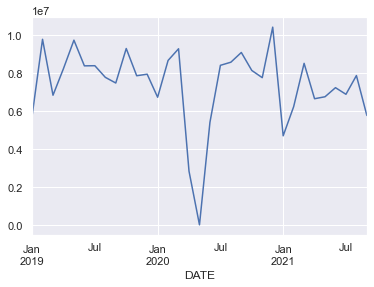

In [166]:
Empresas_dict[1].AMOUNT_USD.plot()
plt.show()

In [167]:
# Analisis descriptivo.
Empresas_dict[1].describe().T

count          mean           std     min        25%  \
AMOUNT_USD            33.0  7.387650e+06  2.060002e+06  6449.0  6740148.0   
CANTIDAD_DE_ORDENES   33.0  5.194545e+02  1.614158e+02     1.0      432.0   

                           50%        75%         max  
AMOUNT_USD           7875150.0  8529429.0  10440023.0  
CANTIDAD_DE_ORDENES      552.0      601.0       811.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

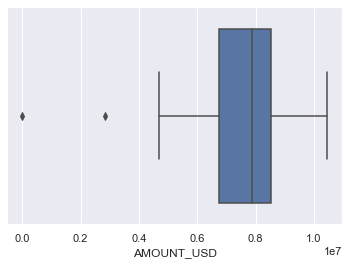

In [168]:
sns.boxplot(Empresas_dict[1].AMOUNT_USD)

In [169]:
z1 = np.abs(stats.zscore(Empresas_dict[1]))
Empresas_dict[1][(z1 > 3).all(axis=1)].AMOUNT_USD


DATE
2020-05-31    6449
Freq: M, Name: AMOUNT_USD, dtype: int64

In [170]:
np.where(Empresas_dict[1].AMOUNT_USD < 4000000)

(array([15, 16]),)

In [171]:
Empresas_dict[1].AMOUNT_USD = np.where(Empresas_dict[1].AMOUNT_USD < 4000000,  np.mean(Empresas_dict[1].AMOUNT_USD), Empresas_dict[1].AMOUNT_USD)

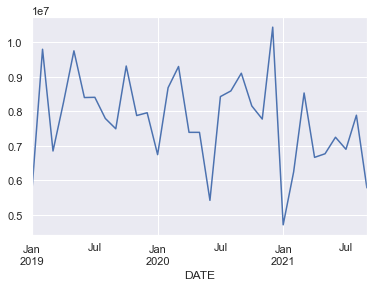

In [172]:
Empresas_dict[1].AMOUNT_USD.plot()
plt.show()

In [173]:
""" # to improve the metric use one hot encoding
# label encoding
cols = ['DESTINATION_COUNTRY', 'PRODUCT_DESCRIPTION']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cols:
    Exportaciones_encod_1[col] = le.fit_transform(Exportaciones_encod[col])
Exportaciones_encod_1.head() """

" # to improve the metric use one hot encoding\n# label encoding\ncols = ['DESTINATION_COUNTRY', 'PRODUCT_DESCRIPTION']\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\nfor col in cols:\n    Exportaciones_encod_1[col] = le.fit_transform(Exportaciones_encod[col])\nExportaciones_encod_1.head() "

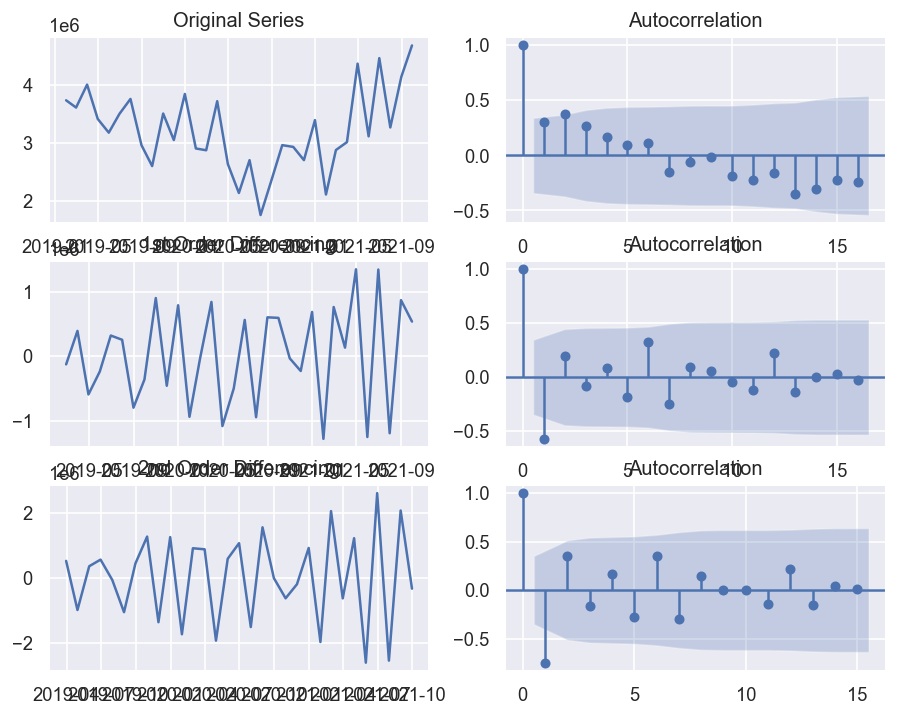

In [174]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[5].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[5].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[5].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[5].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[5].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[5].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [175]:
result1 = adfuller(Empresas_dict[1].AMOUNT_USD)
print('ADF Statistic: {}'.format(result1[0]))
print('p-value: {}'.format(result1[1]))
print('Critical Values:')
for key, value in result1[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.21408849937631
p-value: 5.418726055772914e-08
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


In [176]:
model1 = pm.auto_arima(Empresas_dict[1].AMOUNT_USD, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      randrom_state=23, n_fits=50)

print(model1.summary())
print(model1.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1032.559, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1027.098, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1030.633, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1030.563, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1143.539, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1029.095, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1028.924, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1030.923, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1028.648, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1028.635, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1030.639, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.258 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

In [177]:
modelx = ARIMA(Exportaciones_index[Exportaciones_index['EMPRESAS'] == 1].AMOUNT_USD, order=(1,0,2))
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so wi

                              ARMA Model Results                              
Dep. Variable:             AMOUNT_USD   No. Observations:                17142
Model:                     ARMA(1, 2)   Log Likelihood             -203146.566
Method:                       css-mle   S.D. of innovations          33923.651
Date:                Sat, 09 Apr 2022   AIC                         406303.131
Time:                        01:01:34   BIC                         406341.878
Sample:                             0   HQIC                        406315.903
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.422e+04    376.259     37.798      0.000    1.35e+04     1.5e+04
ar.L1.AMOUNT_USD     0.2764      0.041      6.719      0.000       0.196       0.357
ma.L1.AMOUNT_USD    -0.0247 

In [178]:
model1 = ARIMA(Empresas_dict[1].AMOUNT_USD, order=(1,0,2))
model_fit = model1.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             AMOUNT_USD   No. Observations:                   33
Model:                     ARMA(1, 2)   Log Likelihood                -511.246
Method:                       css-mle   S.D. of innovations        1270542.561
Date:                Sat, 09 Apr 2022   AIC                           1032.492
Time:                        01:01:35   BIC                           1039.974
Sample:                    01-31-2019   HQIC                          1035.009
                         - 09-30-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.749e+06   1.97e+05     39.269      0.000    7.36e+06    8.14e+06
ar.L1.AMOUNT_USD    -0.8657      0.238     -3.642      0.000      -1.332      -0.400
ma.L1.AMOUNT_USD     0.8200 

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [179]:
model1 = pm.auto_arima(Empresas_dict[1].AMOUNT_USD,
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=1, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=False,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=23, n_fits=50)

print(model1.summary())
print(model1.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1143.539, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1054.224, Time=0.01 sec


/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1124.353, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1036.773, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1037.890, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1037.608, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1122.404, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1030.639, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1028.635, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1027.098, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1028.648, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.233 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:                        SARIMAX   Log Likel

#### AUTOARIMA, Empresa 2.

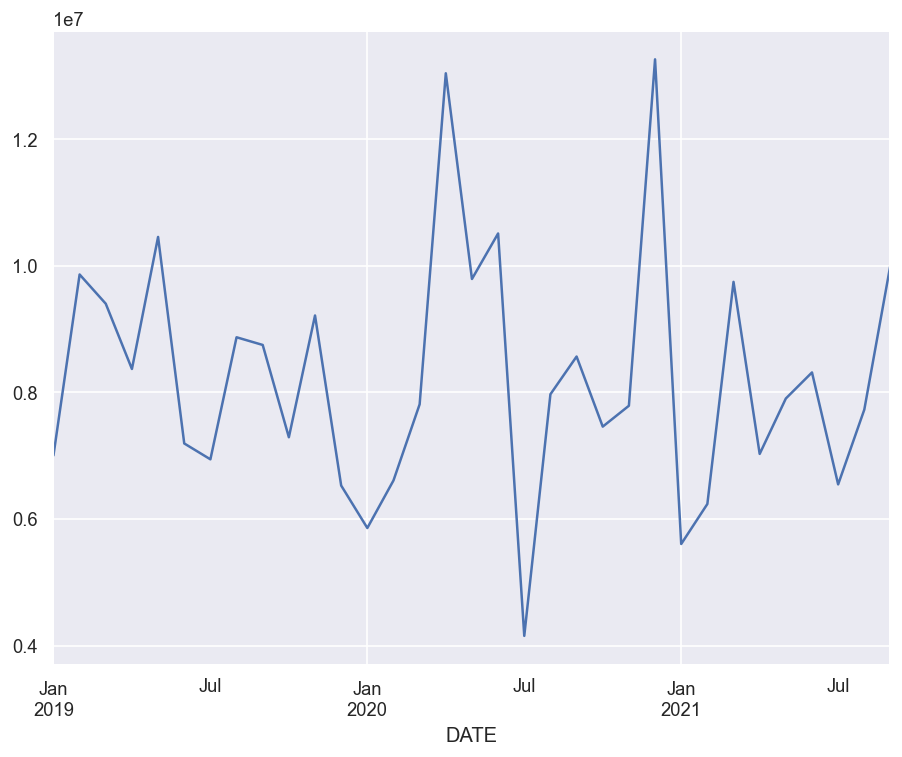

In [180]:
Empresas_dict[2].AMOUNT_USD.plot()
plt.show()

In [181]:
# Analisis descriptivo.
Empresas_dict[2].describe().T

count          mean           std        min        25%  \
AMOUNT_USD            33.0  8.236729e+06  1.950513e+06  4153726.0  7003770.0   
CANTIDAD_DE_ORDENES   33.0  4.443636e+02  9.710330e+01      252.0      380.0   

                           50%        75%         max  
AMOUNT_USD           7902783.0  9399870.0  13260190.0  
CANTIDAD_DE_ORDENES      441.0      498.0       656.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

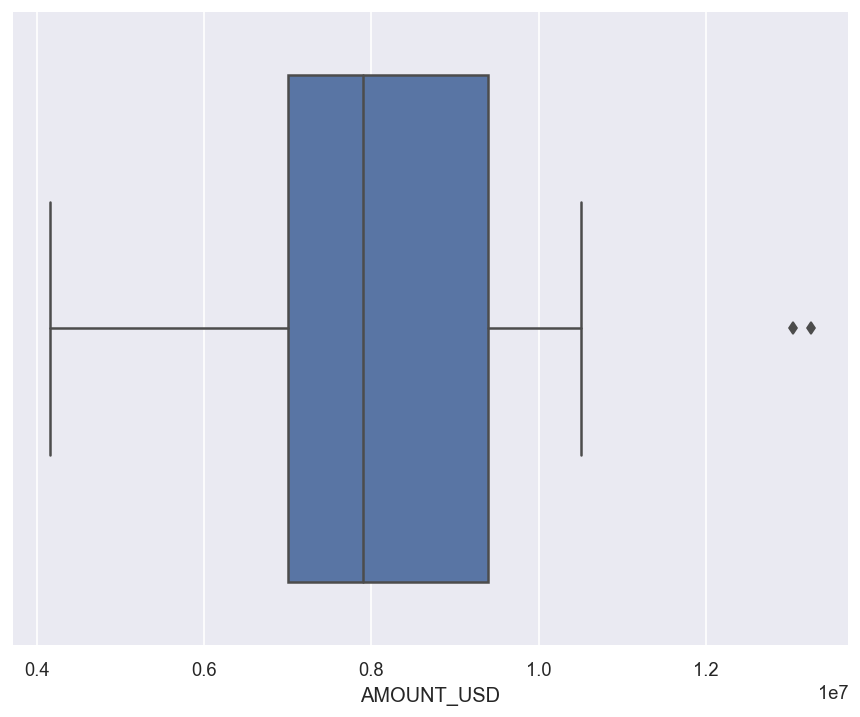

In [182]:
sns.boxplot(Empresas_dict[2].AMOUNT_USD)

In [183]:
z2 = np.abs(stats.zscore(Empresas_dict[2]))
Empresas_dict[2][(z2 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [184]:
result2 = adfuller(Empresas_dict[2].AMOUNT_USD)
print('ADF Statistic: {}'.format(result2[0]))
print('p-value: {}'.format(result2[1]))
print('Critical Values:')
for key, value in result2[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.897665156493541
p-value: 2.8262733014444616e-07
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


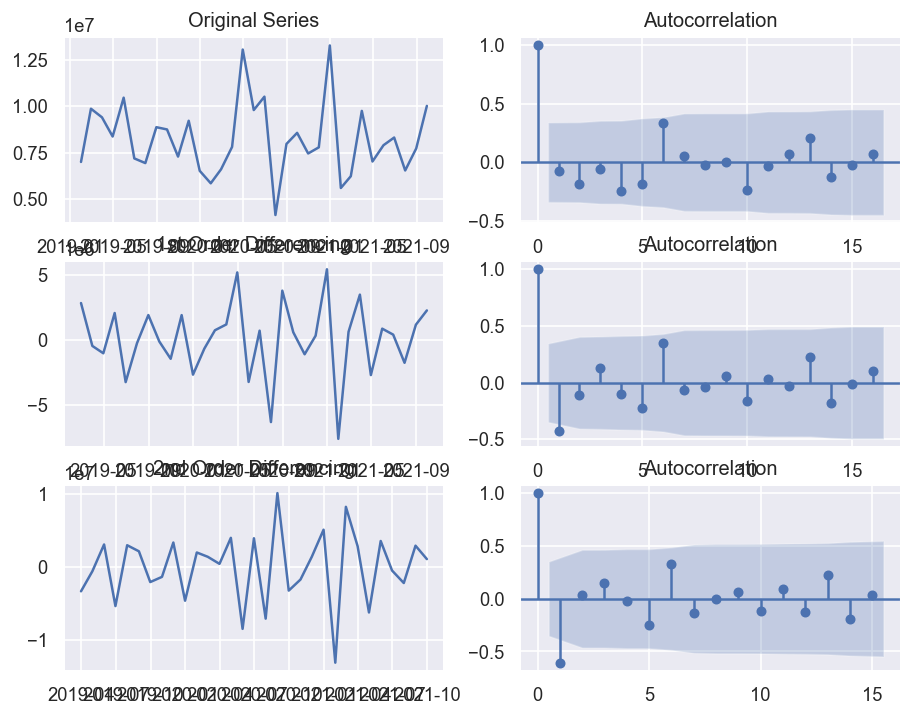

In [185]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[2].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[2].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[2].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[2].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[2].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[2].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [186]:
model2 = pm.auto_arima(Empresas_dict[2].AMOUNT_USD,
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=1, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=True,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=23, n_fits=50)

print(model2.summary())
print(model2.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=662.708, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=648.144, Time=0.05 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=643.046, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=642.342, Time=0.02 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=643.372, Time=0.05 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=645.038, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=634.226, Time=0.02 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=636.100, Time=0.07 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=635.923, Time=0.07 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=637.540, Time=0.10 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=647.200, Time=0.01 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=634.927, Time=0.03 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=633.925, Time=0.04 sec
 ARIMA(1,2,2)(1,1,0)[12]             : AIC=635.081, Time=0.11 sec
 ARIMA(1,2,2)(0,1,1)[12]         

In [187]:
modelx2 = ARIMA(Empresas_dict[2].AMOUNT_USD, order=(0,2,2))
model_fitx2 = modelx2.fit(disp=0)
print(model_fitx2.summary())

                             ARIMA Model Results                              
Dep. Variable:          D2.AMOUNT_USD   No. Observations:                   31
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -498.773
Method:                       css-mle   S.D. of innovations        2009117.240
Date:                Sat, 09 Apr 2022   AIC                           1005.545
Time:                        01:01:39   BIC                           1011.281
Sample:                    03-31-2019   HQIC                          1007.415
                         - 09-30-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 998.7910   7429.288      0.134      0.893   -1.36e+04    1.56e+04
ma.L1.D2.AMOUNT_USD    -1.9847      0.132    -14.990      0.000      -2.244      -1.725
ma.L2.D2.AMOUNT_

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



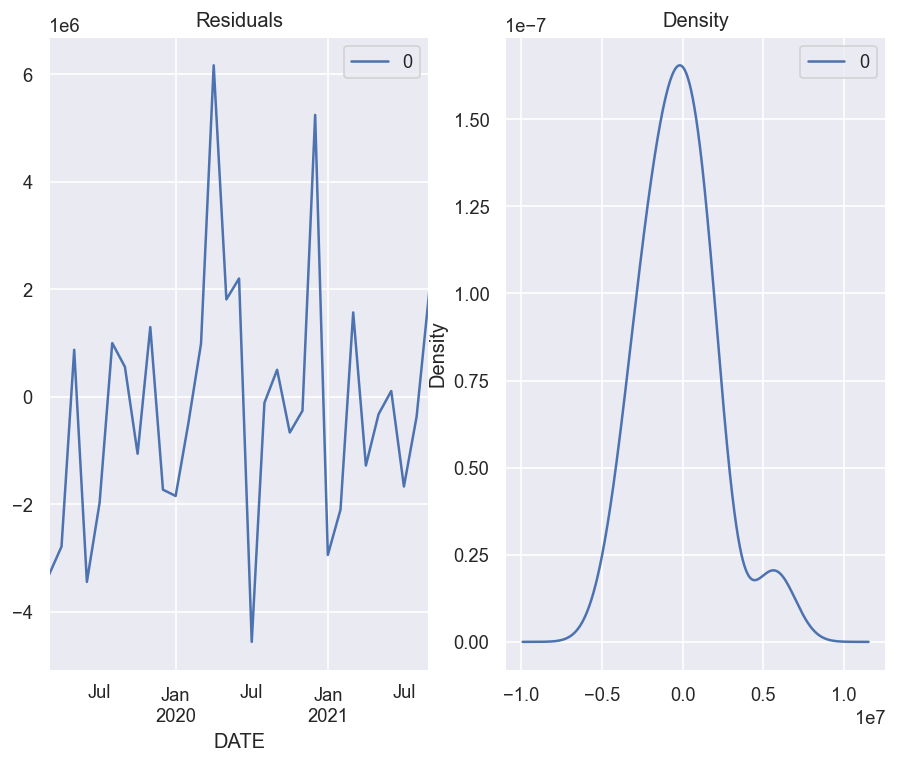

In [188]:
residuals = pd.DataFrame(model_fitx2.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### AUTOARIMA, Empresa 3.

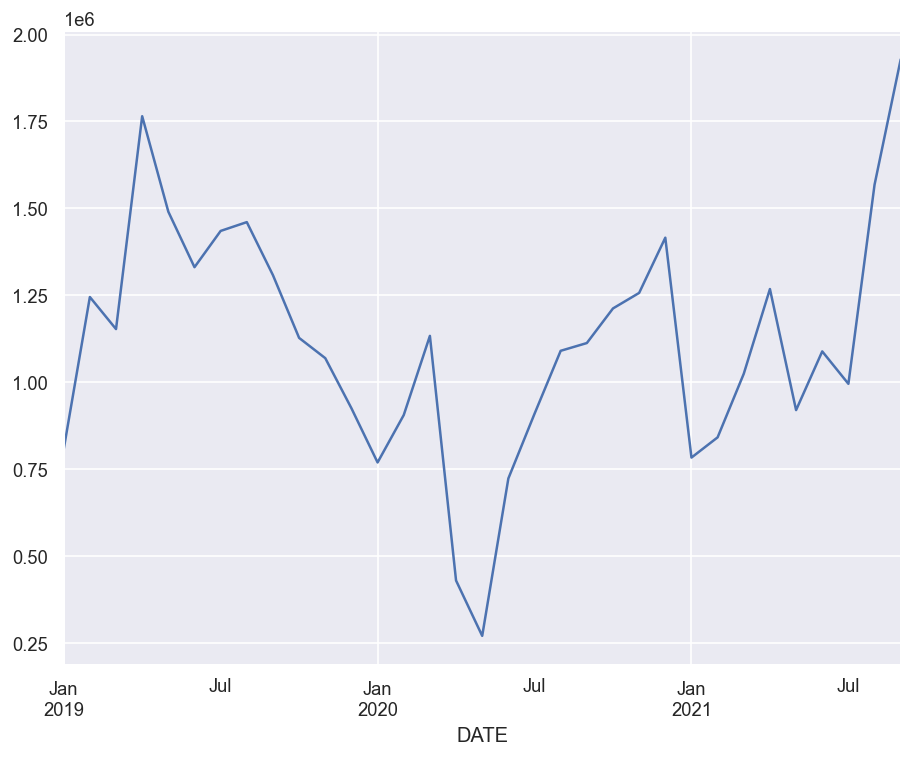

In [189]:
Empresas_dict[3].AMOUNT_USD.plot()
plt.show()

In [190]:
# Analisis descriptivo.
Empresas_dict[3].describe().T

count          mean            std       min       25%  \
AMOUNT_USD            33.0  1.114496e+06  345313.901691  271451.0  909820.0   
CANTIDAD_DE_ORDENES   33.0  4.124848e+02     134.855738     137.0     341.0   

                           50%        75%        max  
AMOUNT_USD           1113131.0  1308198.0  1928657.0  
CANTIDAD_DE_ORDENES      403.0      449.0      797.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

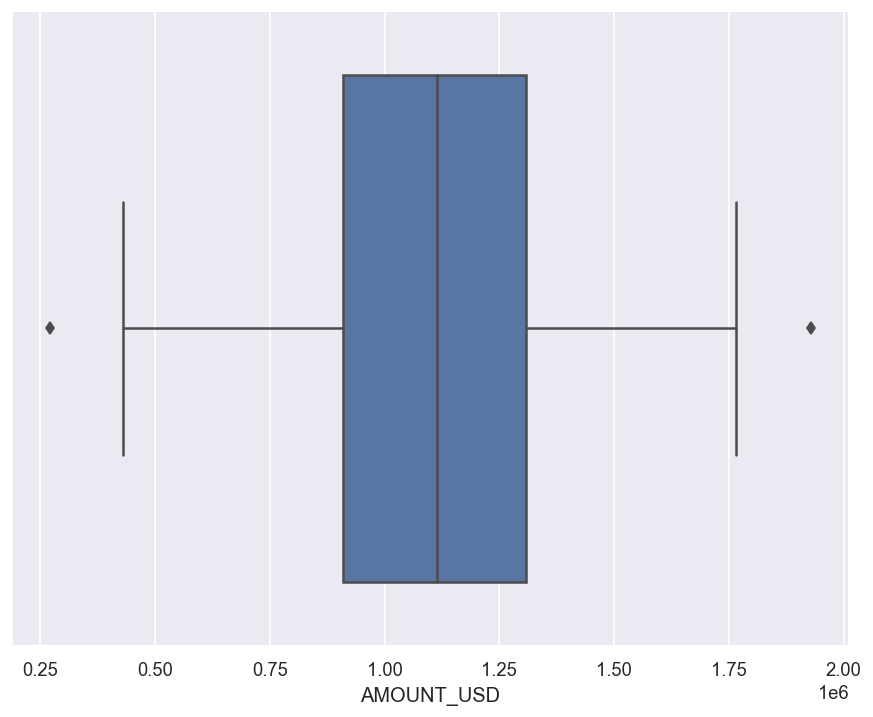

In [191]:
sns.boxplot(Empresas_dict[3].AMOUNT_USD)

In [192]:
z3 = np.abs(stats.zscore(Empresas_dict[3]))
Empresas_dict[3][(z3 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [193]:
print(np.where((Empresas_dict[3].AMOUNT_USD < 300000) | (Empresas_dict[3].AMOUNT_USD > 1800000)))

(array([16, 32]),)


In [194]:
this_mask = Empresas_dict[3].iloc[np.where((Empresas_dict[3].AMOUNT_USD < 300000) | (Empresas_dict[3].AMOUNT_USD > 1800000))].AMOUNT_USD
this_mask

DATE
2020-05-31     271451
2021-09-30    1928657
Freq: 16M, Name: AMOUNT_USD, dtype: int64

In [195]:
np.mean(Empresas_dict[3].AMOUNT_USD)

1114496.2727272727

In [196]:
Empresas_dict[3].loc['2020-05-31', 'AMOUNT_USD'] = 1114496.2727272727
Empresas_dict[3].loc['2021-09-30', 'AMOUNT_USD'] = 1114496.2727272727

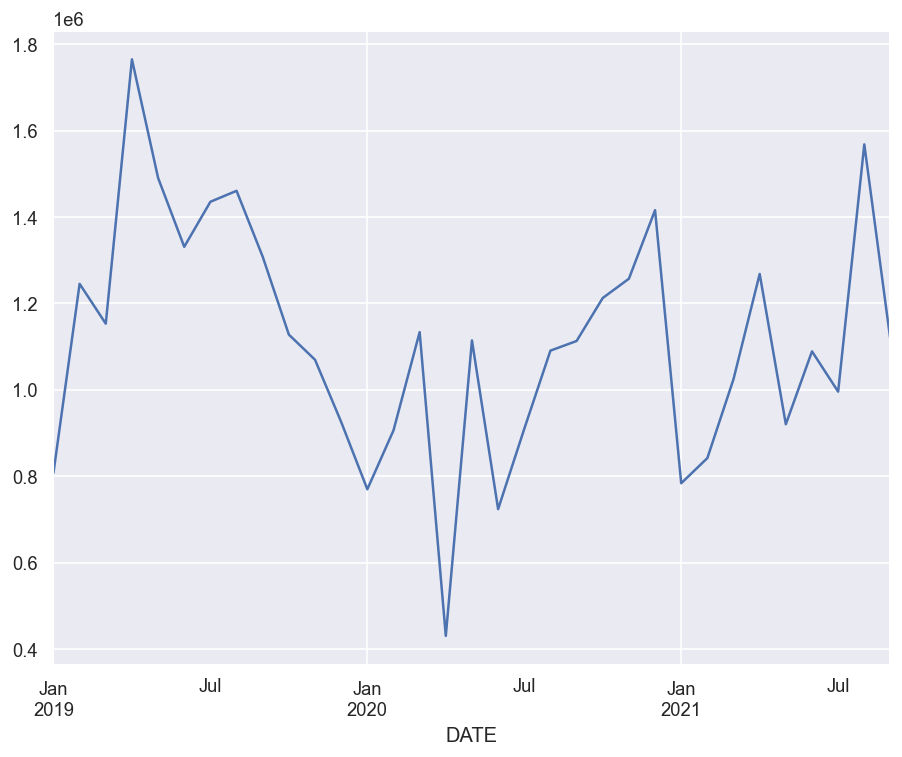

In [197]:
Empresas_dict[3].AMOUNT_USD.plot()
plt.show()

In [198]:
z3 = np.abs(stats.zscore(Empresas_dict[3]))
Empresas_dict[3][(z3 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [199]:
result3 = adfuller(Empresas_dict[3].AMOUNT_USD)
print('ADF Statistic: {}'.format(result3[0]))
print('p-value: {}'.format(result3[1]))
print('Critical Values:')
for key, value in result3[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.058893650641302
p-value: 0.001131658526345549
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


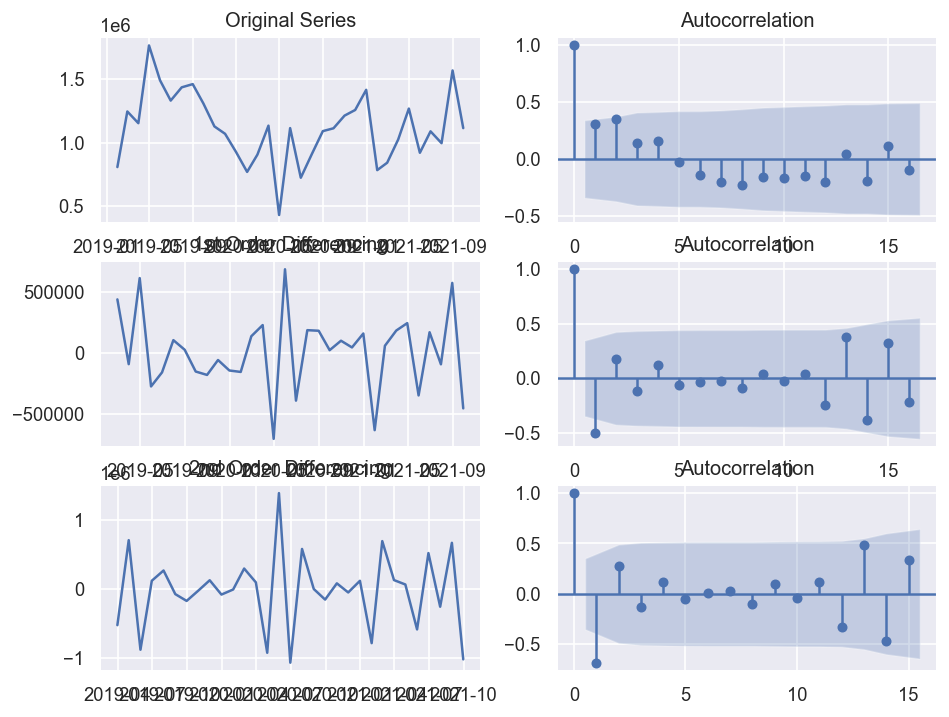

In [200]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[3].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[3].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[3].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[3].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[3].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[3].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [201]:
model3 = pm.auto_arima(Empresas_dict[3].AMOUNT_USD,
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=1, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=True,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=20, n_fits=50)

print(model3.summary())
print(model3.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=590.620, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=577.461, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=576.878, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=585.695, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=578.655, Time=0.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=578.577, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=578.217, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=580.492, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=582.481, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=577.049, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=578.076, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=576.271, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=581.772, Time=0.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=578.219, Time=0.07 sec
 ARIMA(1,1,0)(0,1,2)[12]         

In [202]:
modelx3 = ARIMA(Empresas_dict[3].AMOUNT_USD, order=(1,0,0))
model_fitx3 = modelx3.fit(disp=0)
print(model_fitx3.summary())

                              ARMA Model Results                              
Dep. Variable:             AMOUNT_USD   No. Observations:                   33
Model:                     ARMA(1, 0)   Log Likelihood                -458.074
Method:                       css-mle   S.D. of innovations         257947.327
Date:                Sat, 09 Apr 2022   AIC                            922.148
Time:                        01:01:43   BIC                            926.637
Sample:                    01-31-2019   HQIC                           923.658
                         - 09-30-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.115e+06   6.46e+04     17.264      0.000    9.89e+05    1.24e+06
ar.L1.AMOUNT_USD     0.3142      0.165      1.902      0.057      -0.010       0.638
                            

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




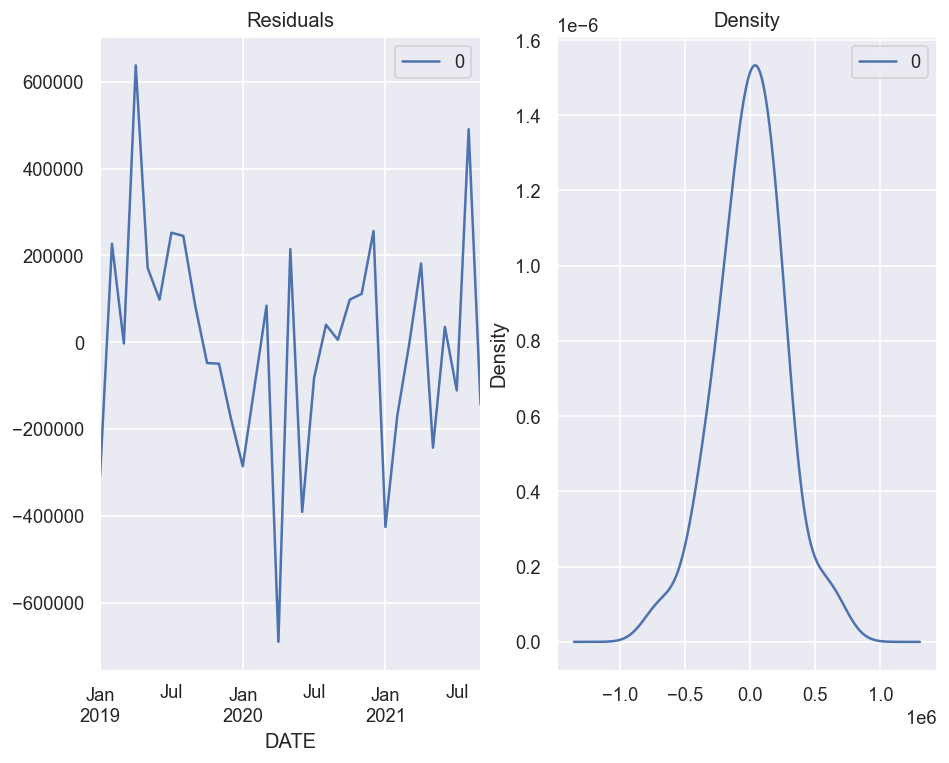

In [203]:
residuals3 = pd.DataFrame(model_fitx3.resid)
fig, ax = plt.subplots(1,2)
residuals3.plot(title="Residuals", ax=ax[0])
residuals3.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### AUTOARIMA, Empresa 4.

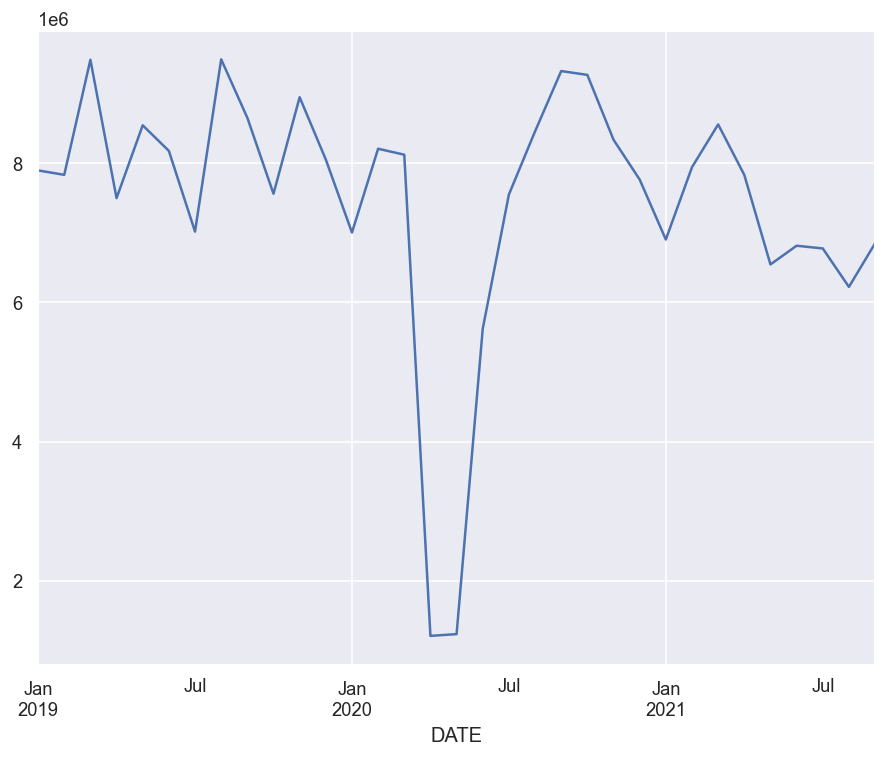

In [204]:
Empresas_dict[4].AMOUNT_USD.plot()
plt.show()

In [205]:
# Analisis descriptivo.
Empresas_dict[4].describe().T

count          mean           std        min        25%  \
AMOUNT_USD            33.0  7.445723e+06  1.861690e+06  1211510.0  6903923.0   
CANTIDAD_DE_ORDENES   33.0  3.506061e+02  6.990348e+01      124.0      327.0   

                           50%        75%        max  
AMOUNT_USD           7833022.0  8457092.0  9491859.0  
CANTIDAD_DE_ORDENES      354.0      386.0      521.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

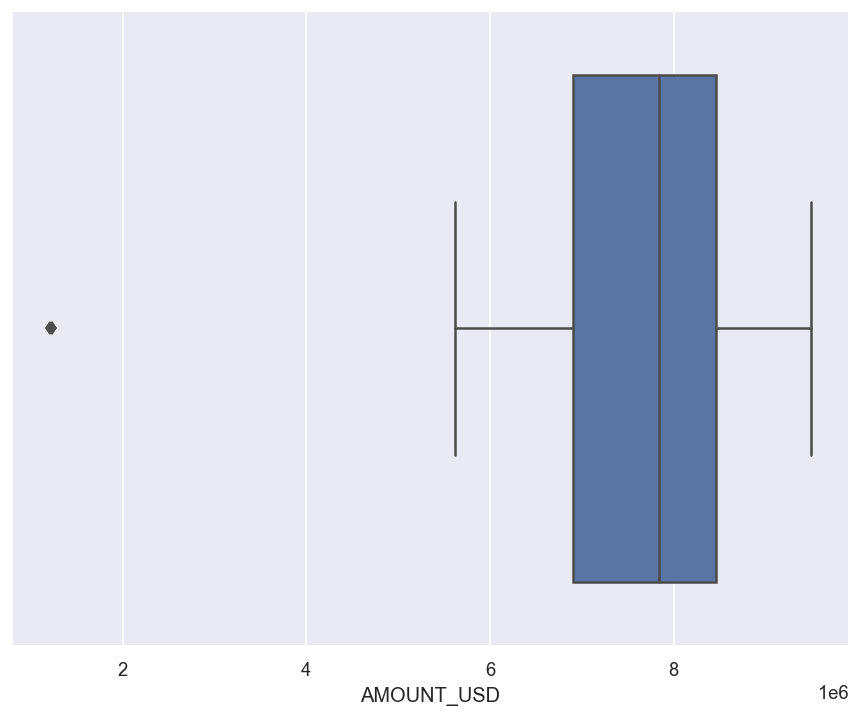

In [206]:
sns.boxplot(Empresas_dict[4].AMOUNT_USD)

In [207]:
z4 = np.abs(stats.zscore(Empresas_dict[4]))
Empresas_dict[4][(z4 > 3).all(axis=1)]

AMOUNT_USD  CANTIDAD_DE_ORDENES
DATE                                       
2020-04-30     1211510                  124

In [208]:
Empresas_dict[4].AMOUNT_USD = np.where(Empresas_dict[4].AMOUNT_USD < 4000000,  np.mean(Empresas_dict[4].AMOUNT_USD), Empresas_dict[4].AMOUNT_USD)

<AxesSubplot:xlabel='DATE'>

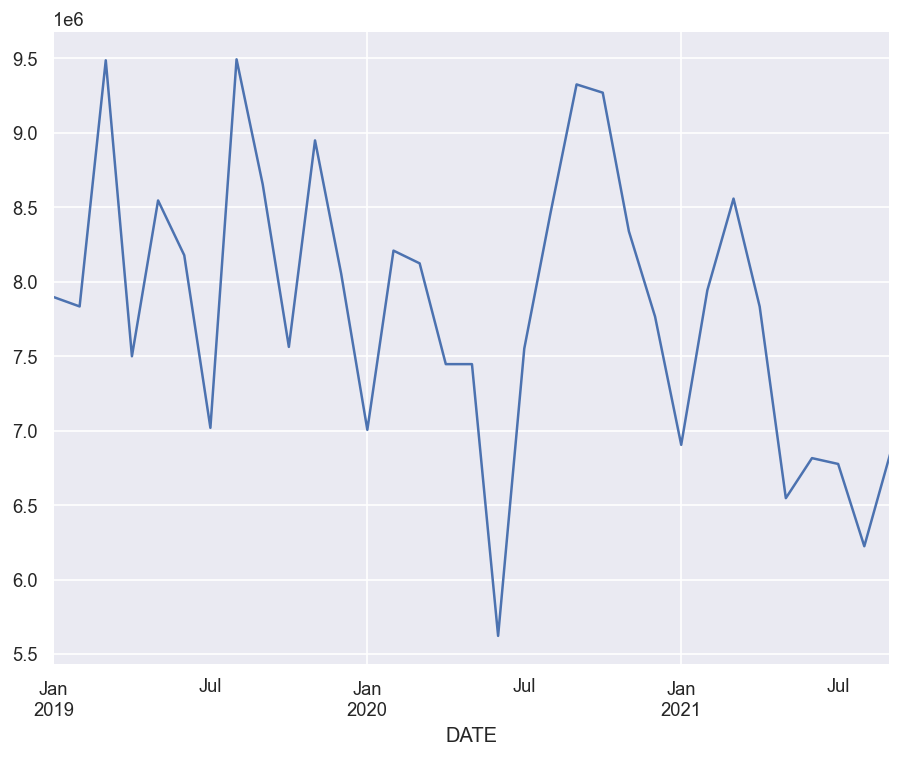

In [209]:
Empresas_dict[4].AMOUNT_USD.plot()

In [210]:
z4 = np.abs(stats.zscore(Empresas_dict[4]))
Empresas_dict[4][(z4 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [211]:
result4 = adfuller(Empresas_dict[4].AMOUNT_USD)
print('ADF Statistic: {}'.format(result4[0]))
print('p-value: {}'.format(result4[1]))
print('Critical Values:')
for key, value in result4[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.788683260297937
p-value: 0.0030252456009656086
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


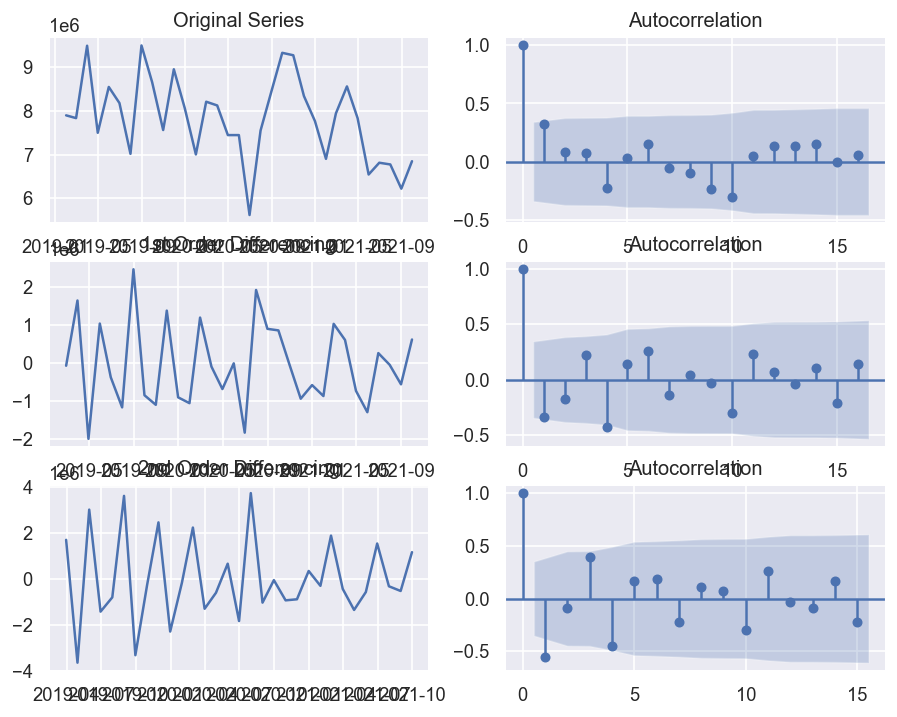

In [212]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[4].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[4].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[4].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[4].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[4].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[4].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [213]:
model4 = pm.auto_arima(Empresas_dict[4].AMOUNT_USD,
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=0, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=True,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=23, n_fits=50)
print(model4.summary())
print(model4.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1004.978, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1005.062, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1005.018, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1143.706, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1006.970, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1005.805, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1007.805, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1003.311, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1004.911, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1006.903, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1005.350, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1005.315, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1003.282, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1005.163, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1

#### AUTOARIMA, Empresa 5.

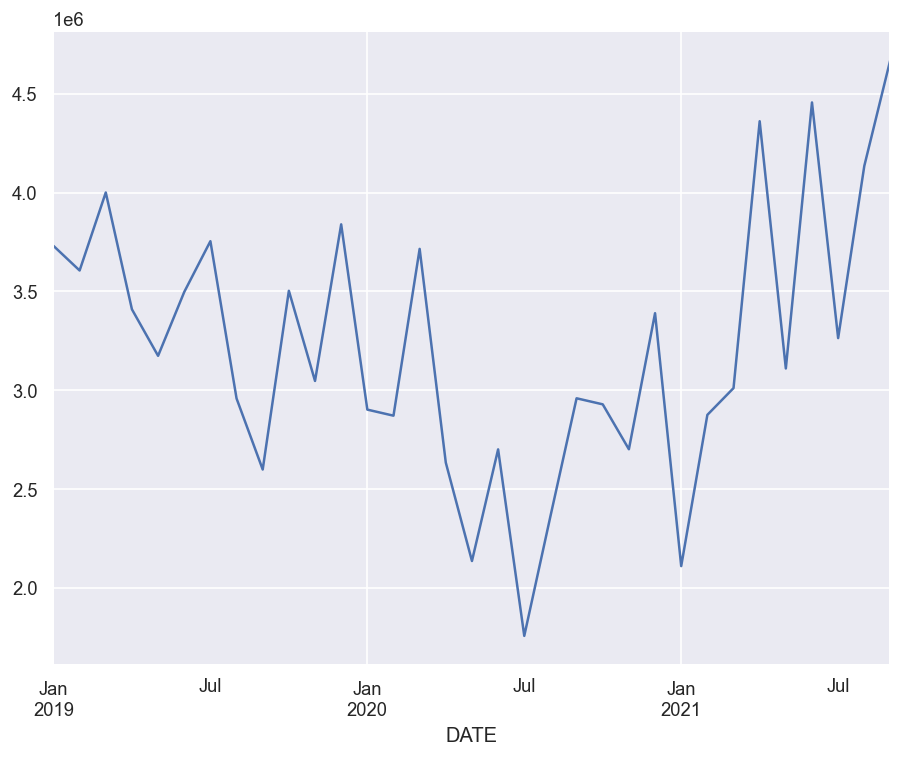

In [214]:
Empresas_dict[5].AMOUNT_USD.plot()
plt.show()

In [215]:
# Analisis descriptivo.
Empresas_dict[5].describe().T

count          mean            std        min        25%  \
AMOUNT_USD            33.0  3.217394e+06  687877.879905  1757087.0  2871244.0   
CANTIDAD_DE_ORDENES   33.0  3.437576e+02      65.243309      244.0      301.0   

                           50%        75%        max  
AMOUNT_USD           3110151.0  3715289.0  4674445.0  
CANTIDAD_DE_ORDENES      327.0      394.0      518.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

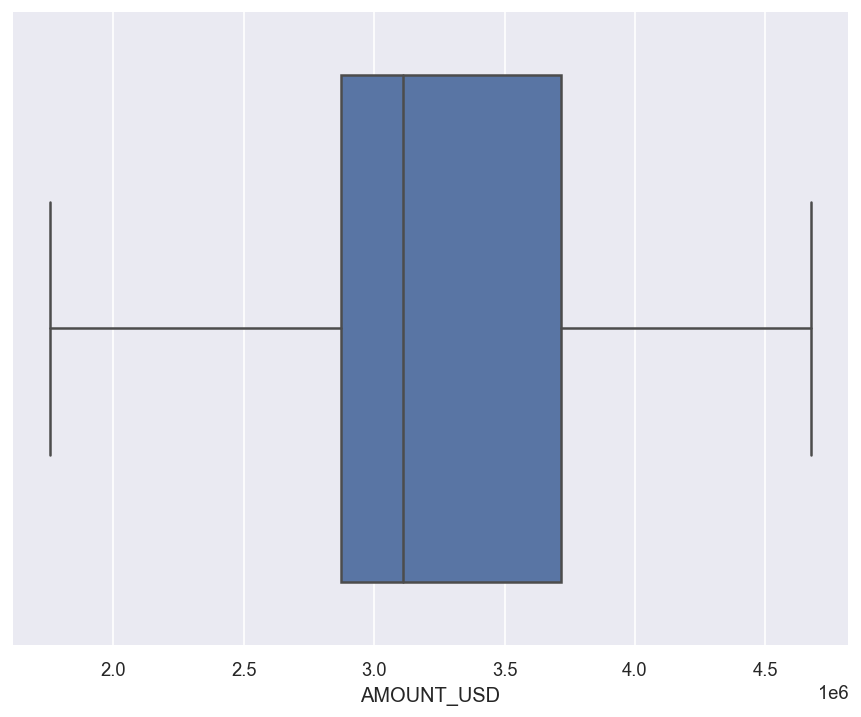

In [216]:
sns.boxplot(Empresas_dict[5].AMOUNT_USD)

In [217]:
z5 = np.abs(stats.zscore(Empresas_dict[5]))
Empresas_dict[5][(z5 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [218]:
result5 = adfuller(Empresas_dict[5].AMOUNT_USD)
print('ADF Statistic: {}'.format(result5[0]))
print('p-value: {}'.format(result5[1]))
print('Critical Values:')
for key, value in result5[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.5381327487143674
p-value: 0.514570413234948
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647


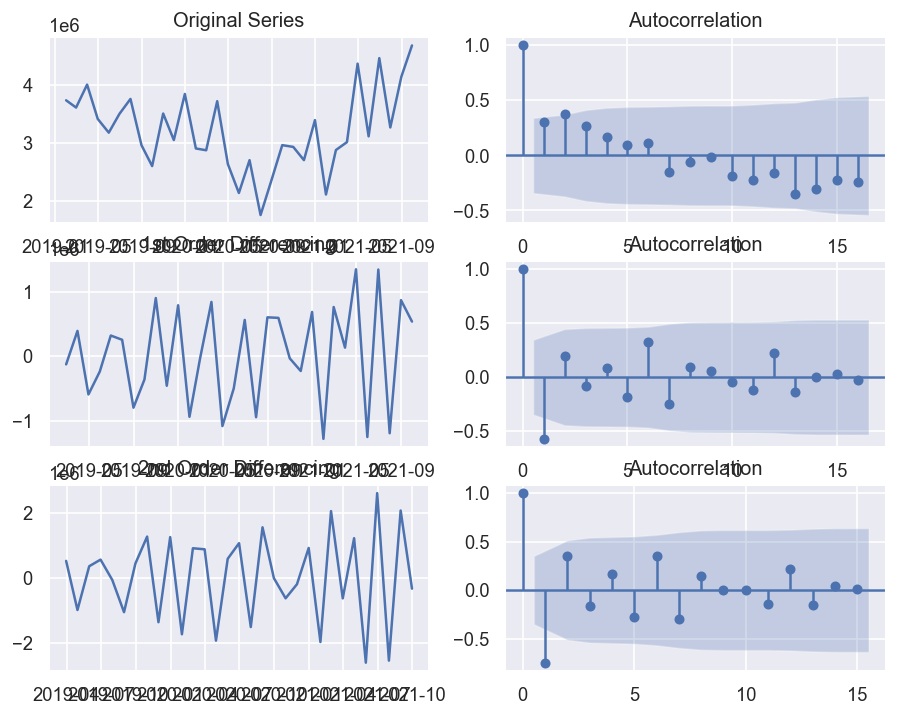

In [219]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[5].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[5].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[5].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[5].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[5].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[5].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [220]:
model5 = pm.auto_arima(Empresas_dict[5].AMOUNT_USD,
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=1, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=True,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=23, n_fits=50)

print(model5.summary())
print(model5.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=592.531, Time=0.01 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=577.895, Time=0.04 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=574.969, Time=0.05 sec
 ARIMA(0,3,1)(0,1,0)[12]             : AIC=572.984, Time=0.02 sec
 ARIMA(0,3,1)(1,1,0)[12]             : AIC=574.972, Time=0.04 sec
 ARIMA(0,3,1)(1,1,1)[12]             : AIC=576.908, Time=0.12 sec
 ARIMA(1,3,1)(0,1,0)[12]             : AIC=inf, Time=0.03 sec
 ARIMA(0,3,2)(0,1,0)[12]             : AIC=560.649, Time=0.04 sec
 ARIMA(0,3,2)(1,1,0)[12]             : AIC=562.603, Time=0.07 sec
 ARIMA(0,3,2)(0,1,1)[12]             : AIC=562.574, Time=0.11 sec
 ARIMA(0,3,2)(1,1,1)[12]             : AIC=564.350, Time=0.11 sec
 ARIMA(1,3,2)(0,1,0)[12]             : AIC=554.582, Time=0.02 sec
 ARIMA(1,3,2)(1,1,0)[12]             : AIC=556.252, Time=0.10 sec
 ARIMA(1,3,2)(0,1,1)[12]             : AIC=556.114, Time=0.09 sec
 ARIMA(1,3,2)(1,1,1)[12]             

In [221]:
modelx5 = ARIMA(Empresas_dict[5].AMOUNT_USD, order=(1,0,2))
model_fitx5 = modelx5.fit(disp=0)
print(model_fitx3.summary())

                              ARMA Model Results                              
Dep. Variable:             AMOUNT_USD   No. Observations:                   33
Model:                     ARMA(1, 0)   Log Likelihood                -458.074
Method:                       css-mle   S.D. of innovations         257947.327
Date:                Sat, 09 Apr 2022   AIC                            922.148
Time:                        01:01:49   BIC                            926.637
Sample:                    01-31-2019   HQIC                           923.658
                         - 09-30-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.115e+06   6.46e+04     17.264      0.000    9.89e+05    1.24e+06
ar.L1.AMOUNT_USD     0.3142      0.165      1.902      0.057      -0.010       0.638
                            

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




#### AUTOARIMA, Empresa 6.

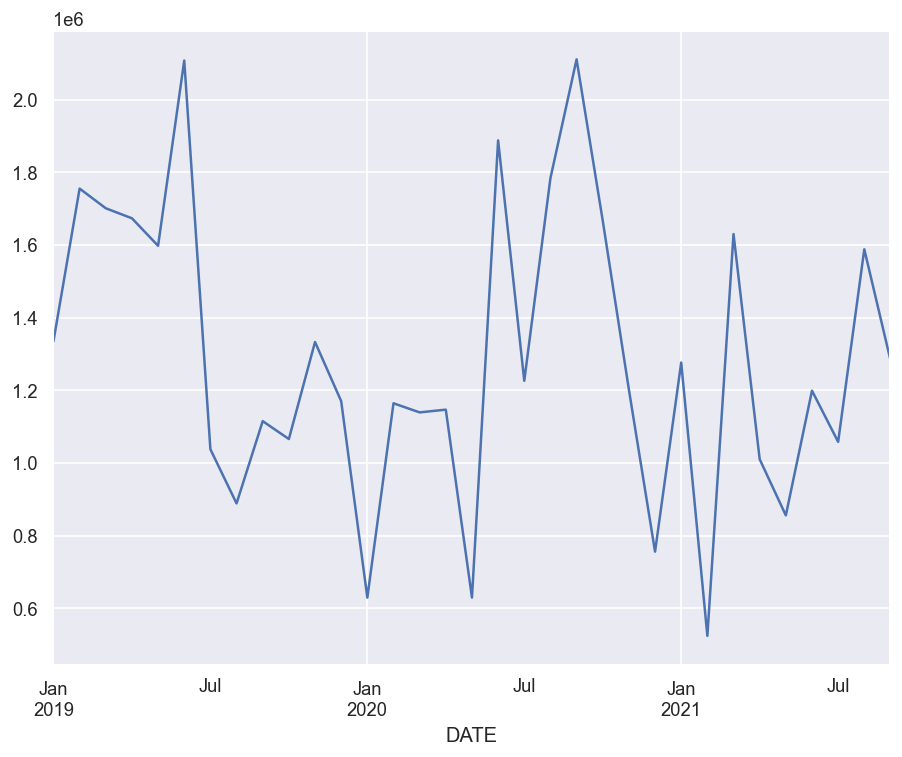

In [222]:
Empresas_dict[6].AMOUNT_USD.plot()
plt.show()

In [223]:
# Analisis descriptivo.
Empresas_dict[6].describe().T

count          mean            std       min        25%  \
AMOUNT_USD            33.0  1.289201e+06  410429.944869  523614.0  1057883.0   
CANTIDAD_DE_ORDENES   33.0  1.887576e+02     226.135058      50.0       63.0   

                           50%        75%        max  
AMOUNT_USD           1201752.0  1630093.0  2111193.0  
CANTIDAD_DE_ORDENES       77.0      245.0      967.0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='AMOUNT_USD'>

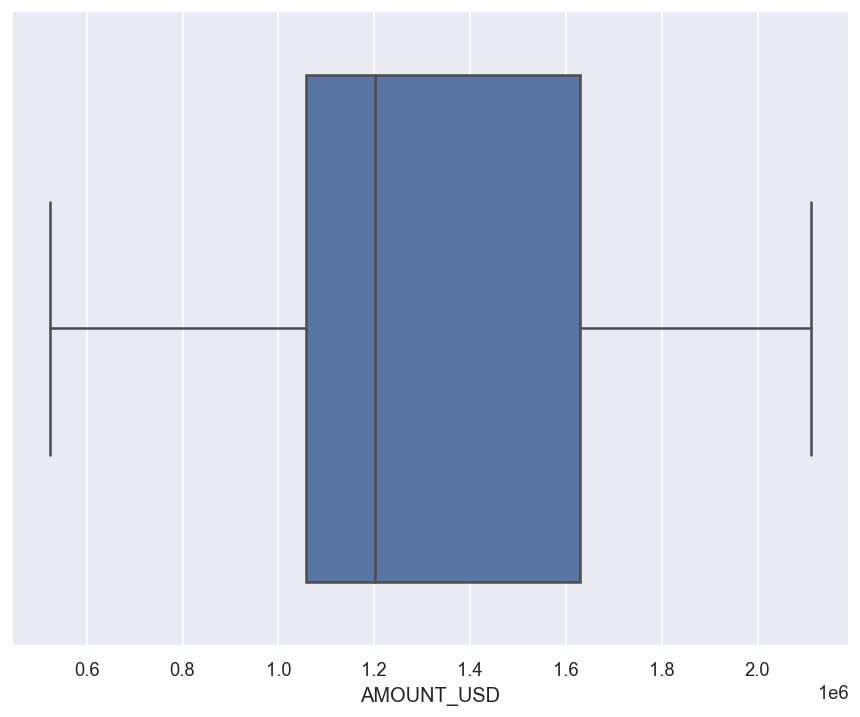

In [224]:
sns.boxplot(Empresas_dict[6].AMOUNT_USD)

In [225]:
z6 = np.abs(stats.zscore(Empresas_dict[6]))
Empresas_dict[6][(z6 > 3).all(axis=1)]

Empty DataFrame
Columns: [AMOUNT_USD, CANTIDAD_DE_ORDENES]
Index: []

In [226]:
result6 = adfuller(Empresas_dict[6].AMOUNT_USD)
print('ADF Statistic: {}'.format(result6[0]))
print('p-value: {}'.format(result6[1]))
print('Critical Values:')
for key, value in result6[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.484780871409738
p-value: 0.00020947326957031462
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


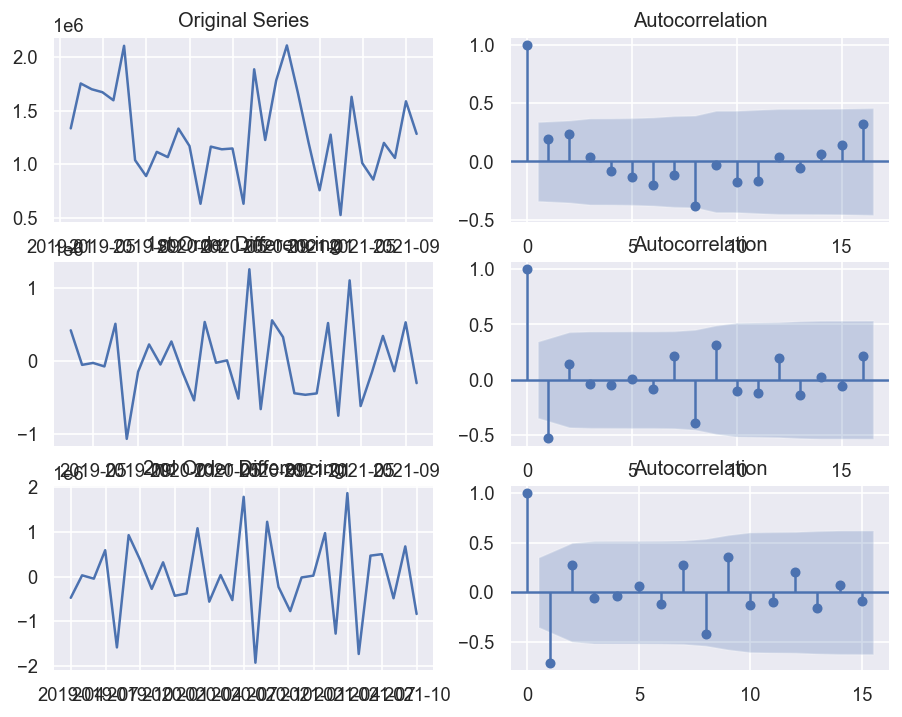

In [227]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Empresas_dict[6].AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Empresas_dict[6].AMOUNT_USD, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(Empresas_dict[6].AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Empresas_dict[6].AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Empresas_dict[6].AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Empresas_dict[6].AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [228]:
model6 = pm.auto_arima(Empresas_dict[6].AMOUNT_USD,                      
                      start_p=0, start_q=0,
                      test='adf',
                      max_p=5, max_q=5, max_d=5, start_P=0,
                      D=1, start_Q=0, max_P=5, max_D=5,
                      max_Q=5, m=12,
                      seasonal=True,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=23, n_fits=50)

print(model6.summary())
print(model6.predict(n_periods=3))

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=582.664, Time=0.01 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=557.390, Time=0.05 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=565.130, Time=0.06 sec
 ARIMA(1,3,0)(0,1,0)[12]             : AIC=558.055, Time=0.01 sec
 ARIMA(1,3,0)(2,1,0)[12]             : AIC=557.593, Time=0.23 sec
 ARIMA(1,3,0)(1,1,1)[12]             : AIC=558.021, Time=0.07 sec
 ARIMA(1,3,0)(0,1,1)[12]             : AIC=556.037, Time=0.05 sec
 ARIMA(1,3,0)(0,1,2)[12]             : AIC=558.011, Time=0.15 sec
 ARIMA(1,3,0)(1,1,2)[12]             : AIC=559.850, Time=0.29 sec
 ARIMA(0,3,0)(0,1,1)[12]             : AIC=575.563, Time=0.03 sec
 ARIMA(2,3,0)(0,1,1)[12]             : AIC=552.692, Time=0.05 sec
 ARIMA(2,3,0)(0,1,0)[12]             : AIC=555.442, Time=0.03 sec
 ARIMA(2,3,0)(1,1,1)[12]             : AIC=554.687, Time=0.08 sec
 ARIMA(2,3,0)(0,1,2)[12]             : AIC=554.682, Time=0.23 sec
 ARIMA(2,3,0)(1,1,0)[12]         

In [229]:
""" # Creamos una copia de nuestro data frame.
Exportaciones_index_2 = Exportaciones.copy()

# Convertimos la variable date en index.
Exportaciones_index_2['DATE'] = pd.to_datetime(Exportaciones_index_2['DATE'])
# Set the date as index 
Exportaciones_index_2.set_index('DATE', inplace=True)
# Select the proper time period for weekly aggreagation
Exportaciones_index_2 = Exportaciones_index_2['2019-01-01':'2021-12-29'].resample('M').sum()
Exportaciones_index_2.head() """

" # Creamos una copia de nuestro data frame.\nExportaciones_index_2 = Exportaciones.copy()\n\n# Convertimos la variable date en index.\nExportaciones_index_2['DATE'] = pd.to_datetime(Exportaciones_index_2['DATE'])\n# Set the date as index \nExportaciones_index_2.set_index('DATE', inplace=True)\n# Select the proper time period for weekly aggreagation\nExportaciones_index_2 = Exportaciones_index_2['2019-01-01':'2021-12-29'].resample('M').sum()\nExportaciones_index_2.head() "

In [230]:
Exportaciones_encod_1 = Exportaciones_encod.copy()
Exportaciones_encod_1 = Exportaciones_encod_1[Exportaciones_encod_1.EMPRESAS == 1]
Exportaciones_encod_1

PRODUCT_DESCRIPTION  AMOUNT_USD       DESTINATION_COUNTRY  \
DATE                                                                       
2021-09-30      PALETA DE PLASTICO           1  UNITED STATES OF AMERICA   
2021-09-30      PALETA DE PLASTICO           1  UNITED STATES OF AMERICA   
2021-09-21       VALVULA SOLENOIDE        9759  UNITED STATES OF AMERICA   
2021-09-30       HOJAS DE PLASTICO           1  UNITED STATES OF AMERICA   
2021-09-30  CONTENEDOR DE PLASTICO           1  UNITED STATES OF AMERICA   
...                            ...         ...                       ...   
2019-01-25       VALVULA SOLENOIDE        4704  UNITED STATES OF AMERICA   
2019-01-25           TAPA PLASTICA           1  UNITED STATES OF AMERICA   
2019-01-08       VALVULA SOLENOIDE       10260  UNITED STATES OF AMERICA   
2019-01-15       VALVULA SOLENOIDE        8469  UNITED STATES OF AMERICA   
2019-01-25  SPOOL VALVE R70 VCM FR       11385  UNITED STATES OF AMERICA   

            EMPRESAS  CANTIDAD_DE_ORDENES  
DATE                                       
2021-09-30         1                    1  
2021-09-30         1                    1  
2021-09-21         1                    1  
2021-09-30         1                    1  
2021-09-30         1                    1  
...              ...                  ...  
2019-01-25         1                    1  
2019-01-25         1                    1  
2019-01-08         1                    1  
2019-01-15         1                    1  
2019-01-25         1                    1  

[17142 rows x 5 columns]

In [231]:
Exportaciones_encod_1 = Exportaciones_encod_1.resample('M').sum()
Exportaciones_encod_1.head()

AMOUNT_USD  EMPRESAS  CANTIDAD_DE_ORDENES
DATE                                                 
2019-01-31     5750092       434                  434
2019-02-28     9798288       811                  811
2019-03-31     6846614       659                  659
2019-04-30     8251012       636                  636
2019-05-31     9752505       754                  754

In [232]:
Exportaciones_latentes = Exportaciones_index.copy()
Exportaciones_latentes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74561 entries, 2021-09-03 to 2019-01-14
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT_DESCRIPTION  74561 non-null  object
 1   AMOUNT_USD           74561 non-null  int64 
 2   DESTINATION_COUNTRY  74561 non-null  object
 3   EMPRESAS             74561 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.8+ MB


In [233]:
# to improve the metric use one hot encoding
# label encoding
cols = ['DESTINATION_COUNTRY', 'PRODUCT_DESCRIPTION']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cols:
    Exportaciones_latentes[col] = le.fit_transform(Exportaciones_latentes[col])
Exportaciones_latentes.head()

PRODUCT_DESCRIPTION  AMOUNT_USD  DESTINATION_COUNTRY  EMPRESAS
DATE                                                                      
2021-09-03                 1645      118170                   12         4
2021-09-30                 1962           1                   24         1
2021-09-30                  621         216                   24         3
2021-09-01                  852          23                   24         5
2021-09-06                  401          59                   12         3

In [234]:
""" from scipy.stats import chisquare

factors_paired = [(i,j) for i in Exportaciones_latentes.PRODUCT_DESCRIPTION.values for j in Exportaciones_latentes.DESTINATION_COUNTRY.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

chi2 = np.array(chi2).reshape((23,23)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=Exportaciones_latentes.PRODUCT_DESCRIPTION.values, columns=Exportaciones_latentes.DESTINATION_COUNTRY.values) # then a df for convenience

SyntaxError: EOF while scanning triple-quoted string literal (1009778002.py, line 17)

In [ ]:
column_1 = Exportaciones_latentes.PRODUCT_DESCRIPTION
column_2 = Exportaciones_latentes.DESTINATION_COUNTRY
correlation = column_1.corr(column_2)
correlation

-0.018977077655709527

In [ ]:
Exportaciones_encod_1.dtypes

AMOUNT_USD             int64
EMPRESAS               int64
CANTIDAD_DE_ORDENES    int64
dtype: object

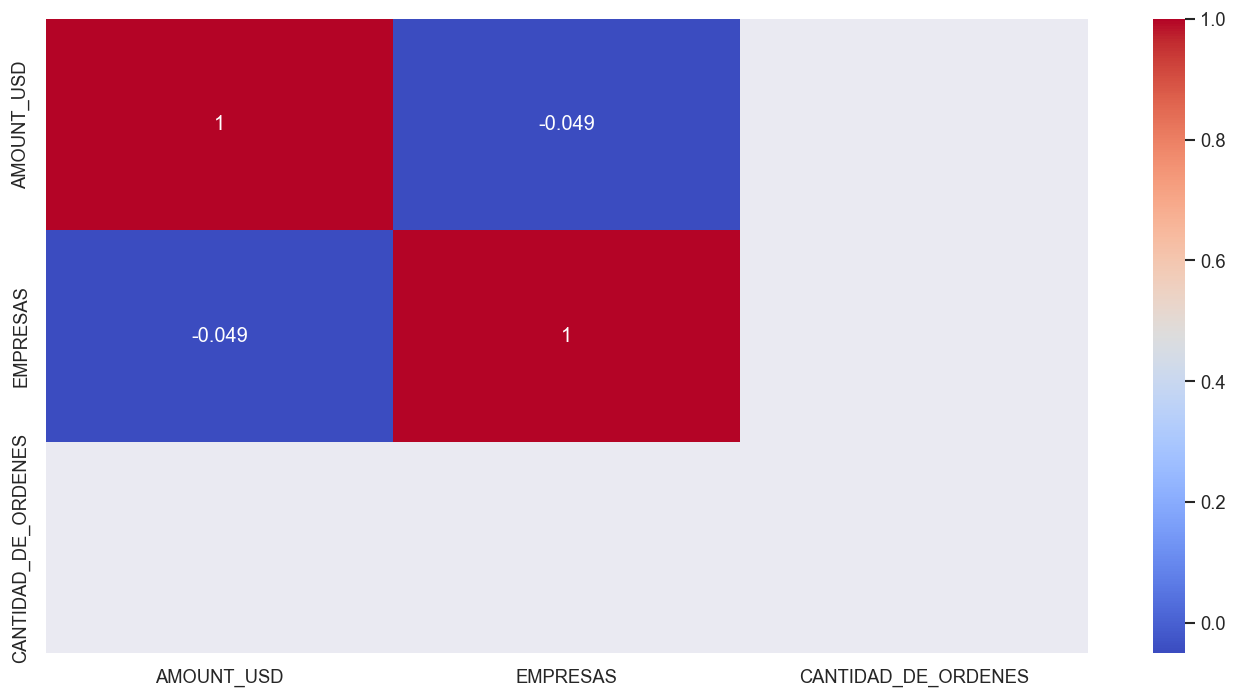

In [ ]:
corr = Exportaciones_encod.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
X = Exportaciones_encod_1.drop(columns=['AMOUNT_USD'])
y = Exportaciones_encod_1['AMOUNT_USD']

In [ ]:
Exportaciones_encod_1.columns

Index(['AMOUNT_USD', 'EMPRESAS', 'CANTIDAD_DE_ORDENES'], dtype='object')

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
def train(model, X, y):
    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)
    model.fit(x_train, y_train)
    
    # predict the results
    pred = model.predict(x_test)
    pred_real = model.predict(X)
    
    # cross validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print("Results")
    print("MSE:", np.sqrt(mean_squared_error(y_test, pred)))
    print("CV Score:", np.sqrt(cv_score))
    print('predicted response:', pred_real, sep='\n')
        #mean_squared_error, r2_score, confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
        #    print(confusion_matrix(y_test, pred))
    #  print(accuracy_score(y_test, pred))

## SIN TERMINAR.

#### Empresa 1, con resample = Month

##### Linear Regression

Results
MSE: 669834.0640263958
CV Score: 1048210.2218787371
predicted response:
[ 6330720.33039939 10998076.983609    9116278.01467568  8831532.11806077
 10292402.37025901  8819151.86168621  9054376.73280288  8200139.04295814
  7878252.37721955 10515246.98500111  7630647.24972832  7209718.53299324
  6305959.81765026  8039195.71008885  8398223.14495112  3136614.18576257
   970069.32021434  5327919.56405992  8026815.45371429  8014435.19733972
  8088716.73558709  7878252.37721955  7246859.30211692  8955334.68180638
  5166976.23119062  5686946.9989222   7506844.68598271  5971692.89553711
  6281199.30490114  7791590.58259762  6454522.894145    7779210.32622306
  5922171.87003886]
R2 score: 0.8538000265827707


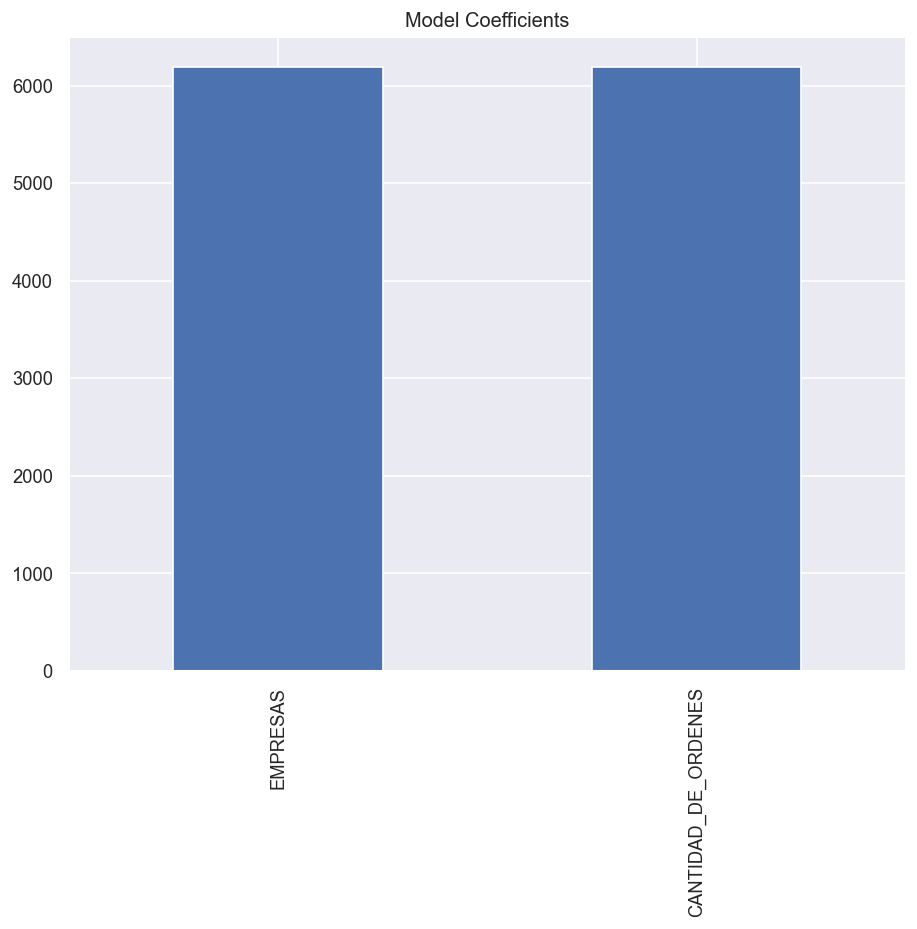

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
train(model, X, y)
print('R2 score:', model.score(X,y))
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')
plt.show()

##### Modelo OLS

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             AMOUNT_USD   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     184.0
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.40e-14
Time:                        09:00:48   Log-Likelihood:                -494.12
No. Observations:                  33   AIC:                             992.2
Df Residuals:                      31   BIC:                             995.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.255e+06   4

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Random Forest Regressor

Results
MSE: 810887.698672067
CV Score: 1325427.7626487971
predicted response:
[6035435.71 8661252.81 7597976.51 8869551.33 8661252.81 8869551.33
 8267685.17 8211346.91 7524078.83 8661252.81 7997107.72 7942599.07
 6490861.47 8665793.93 8211346.91 2267335.02 1389785.47 5636785.13
 8612585.   8612585.   8900010.6  7524078.83 7869318.27 9708102.2
 5636785.13 6013641.35 8323133.   5960085.56 6490861.47 7478157.55
 6530498.67 7708221.31 5960085.56]
R2 score: 0.9211712763936661


<AxesSubplot:title={'center':'Feature Importance'}>

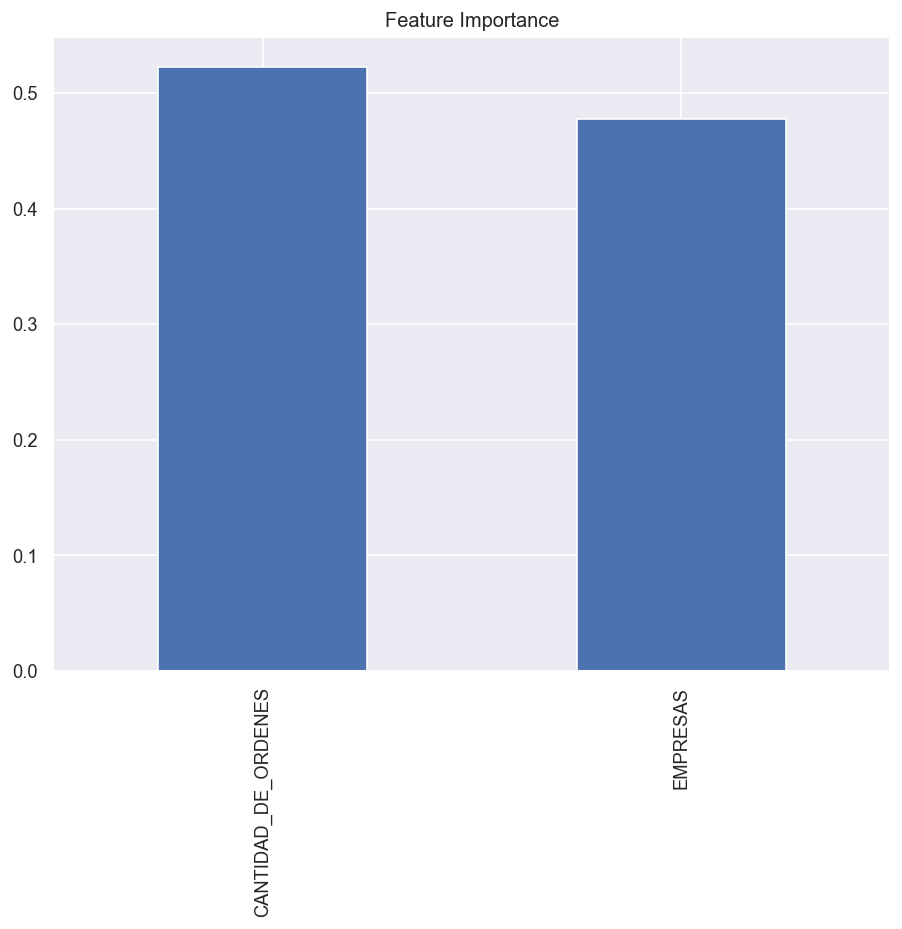

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
train(model, X, y)
print('R2 score:', model.score(X,y))
features = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

##### Gradient Boosting

In [ ]:
# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

NameError: name 'xgb' is not defined

#### Empresa 1, sin resample

##### Linear Regression

##### Modelo OLS

##### Random Forest Regressor

#### Empresa 1, sin resample, con WEEKDAY

#### Resultados modelo Empresa 1

Podemos observar que obtuvimos un R alto y podriamos estar contentos con el modelo. La cuestion pasa porque el modelo predice el monto de facturacion basado en la cantidad de ordenes que tiene la empresa 1, lo cual tiene todo sentido y mucho poder predictivo si tenemos el numero de ordenes que vamos a tener. He aqui la cuestion el modelo, no estaria prediciendo nuestra futura facturacion, solo puede predecir la facturacion para x cantidad de ordenes. Esto nos hace pensar que las variables que tenemos, PRODUCT_DESCRIPTION, DESTINATION_COUNTRY, EMPRESAS (TAX_ID) solo nos pueden ayudar a predecir cual sera el monto estimado de facturacion para determinada cantidad de ordenes, pero no nos ayudan a predecir nada si no sabemos el numero de ordenes que esperamos. Aqui necesitaria nuevas variables de cada empresa para intentar predecir su demanda y la oferta que pueden abastecer. Por ejemplo cantidad de empleados en nomina ese mes, cantidad de maquinas dispponibles, cantidad de clientes, analisis de la demanda de cada cliente y variables de contexto por ejemplo ya que son exportaciones el precio del petroleo y como esto afectaria su competencia en el precio con otras ofertas mas cercanas o lejanas.

In [ ]:
Exportaciones_YM = Exportaciones.copy()
Exportaciones_YM.DATE = pd.to_datetime(Exportaciones_YM.DATE)
Exportaciones_YM['MONTH'] = Exportaciones_YM.DATE.dt.strftime('%b')
Exportaciones_YM['YEAR'] = Exportaciones_YM.DATE.dt.strftime('%Y')

Exportaciones_YM

TAX_ID       DATE  \
0      949d5fa4ec6782418fda5a841e1479c8 2021-09-03   
1      49000cb3c9325f7cdba66c5062ce3ccc 2021-09-30   
2      abe1b325d14500ddc774f2141d46637b 2021-09-30   
3      bec208a809498df9383f33067c6afbc3 2021-09-01   
4      abe1b325d14500ddc774f2141d46637b 2021-09-06   
...                                 ...        ...   
74556  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-08   
74557  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-15   
74558  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-25   
74559  bec208a809498df9383f33067c6afbc3 2019-01-29   
74560  abe1b325d14500ddc774f2141d46637b 2019-01-14   

                          PRODUCT_DESCRIPTION  AMOUNT_USD  \
0      MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                          PALETA DE PLASTICO           1   
2                         CIRCUITOS MODULARES         216   
3              CONEXIONES AISLADAS - ROSCADAS          23   
4                    CAJA DE CARTON CORRUGADO          59   
...                                       ...         ...   
74556                       VALVULA SOLENOIDE       10260   
74557                       VALVULA SOLENOIDE        8469   
74558                  SPOOL VALVE R70 VCM FR       11385   
74559                      HERRAJES METALICOS         219   
74560                         TUERCA DE ACERO          18   

            DESTINATION_COUNTRY  EMPRESAS MONTH  YEAR  
0                        MEXICO         4   Sep  2021  
1      UNITED STATES OF AMERICA         1   Sep  2021  
2      UNITED STATES OF AMERICA         3   Sep  2021  
3      UNITED STATES OF AMERICA         5   Sep  2021  
4                        MEXICO         3   Sep  2021  
...                         ...       ...   ...   ...  
74556  UNITED STATES OF AMERICA         1   Jan  2019  
74557  UNITED STATES OF AMERICA         1   Jan  2019  
74558  UNITED STATES OF AMERICA         1   Jan  2019  
74559  UNITED STATES OF AMERICA         5   Jan  2019  
74560                    MEXICO         3   Jan  2019  

[74561 rows x 8 columns]

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


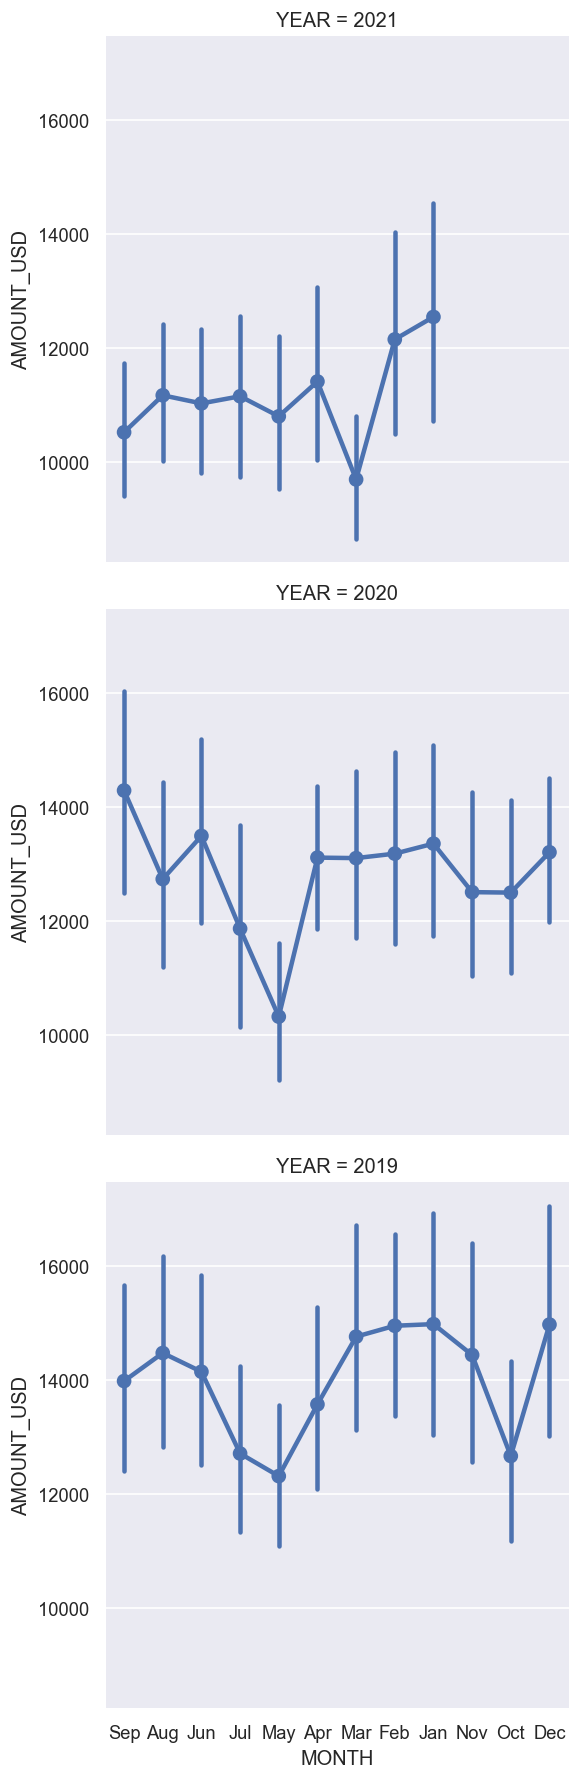

In [ ]:
sns.factorplot(data = Exportaciones_YM, x ="MONTH", y = "AMOUNT_USD", 
               row = "YEAR")

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


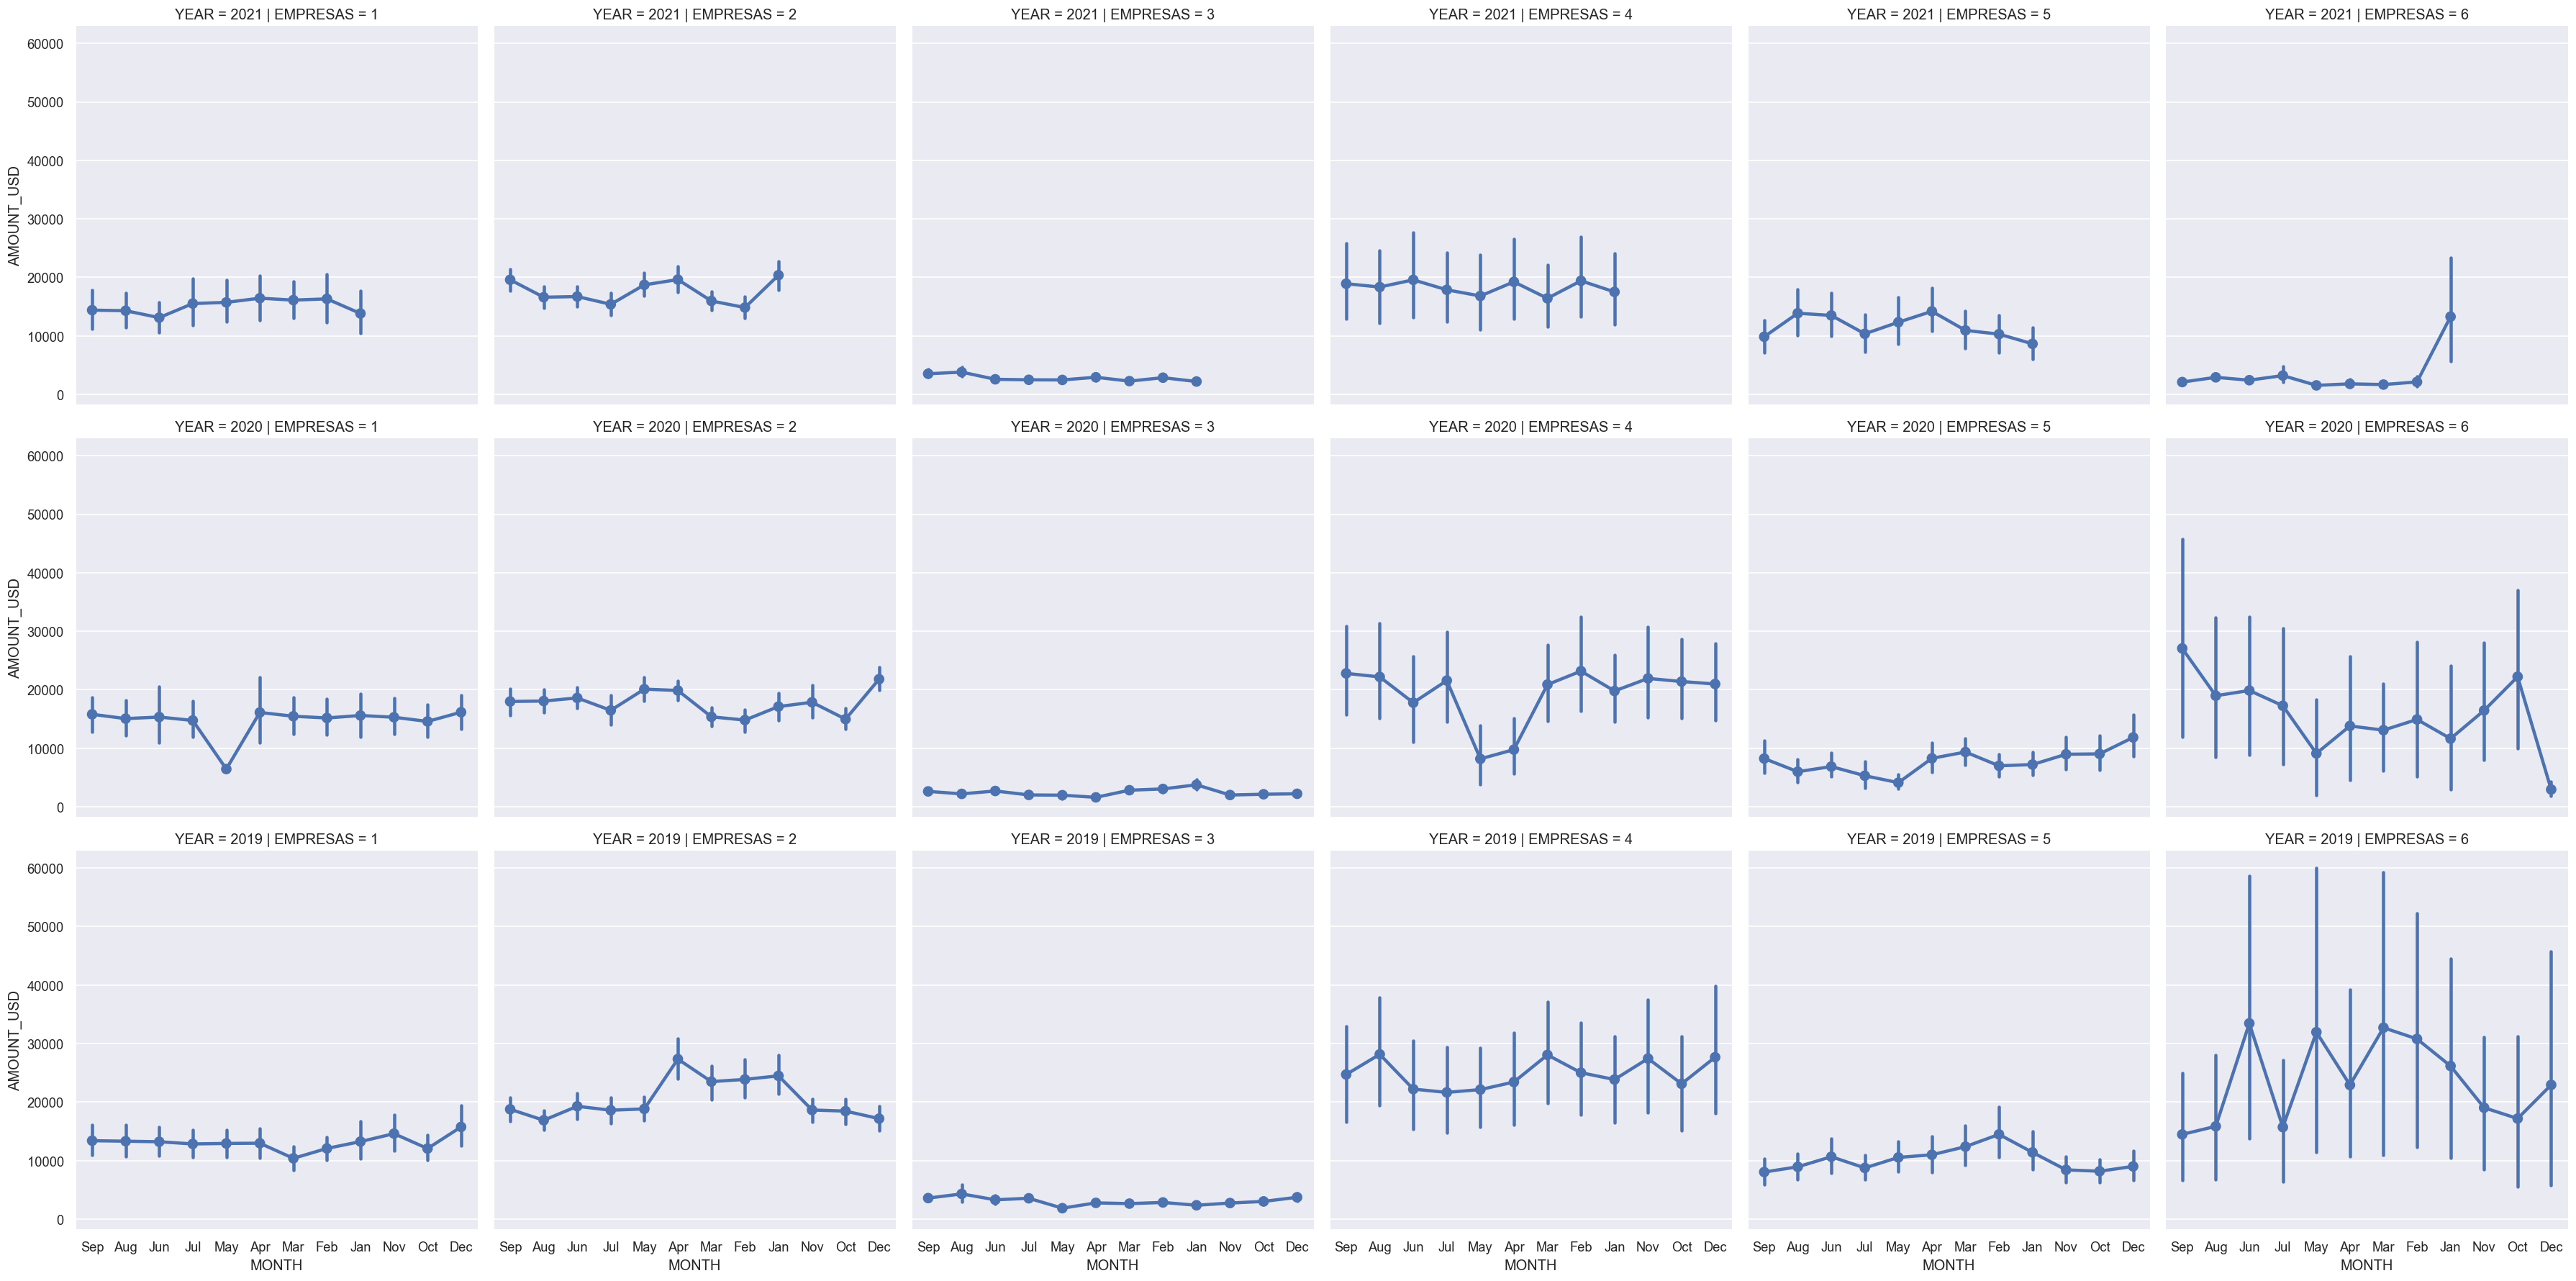

In [ ]:
sns.factorplot(data = Exportaciones_YM, x ="MONTH", y = "AMOUNT_USD", 
               col = 'EMPRESAS', # per store type in cols
               row = "YEAR")

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


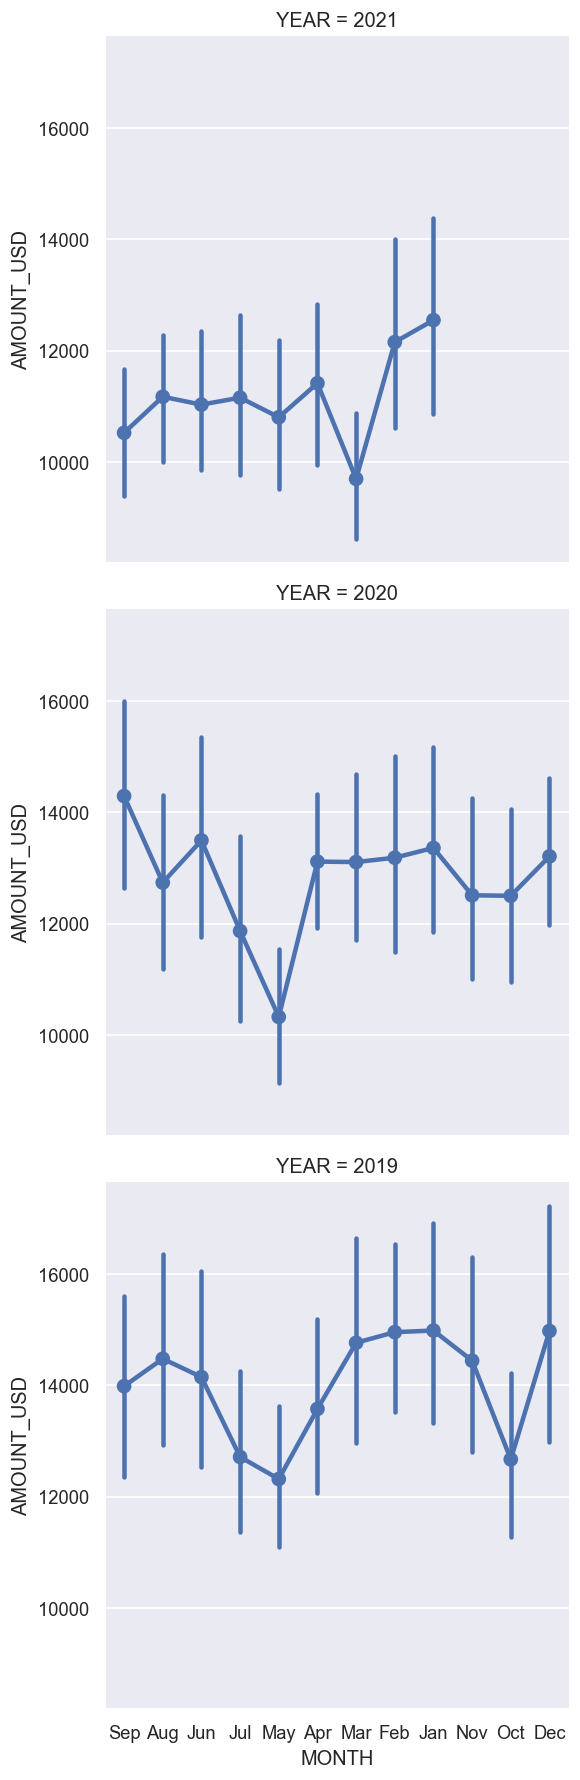

In [ ]:
sns.factorplot(data = Exportaciones_YM, x ="MONTH", y = "AMOUNT_USD", 
               row = "YEAR")

In [ ]:
print(f"Esta base de datos cubre el periodo desde {Exportaciones_YM['DATE'].min()} al {Exportaciones_YM['DATE'].max()}")

Esta base de datos cubre el periodo desde 2019-01-02 00:00:00 al 2021-09-30 00:00:00


In [ ]:
Exportaciones_YM

TAX_ID       DATE  \
0      949d5fa4ec6782418fda5a841e1479c8 2021-09-03   
1      49000cb3c9325f7cdba66c5062ce3ccc 2021-09-30   
2      abe1b325d14500ddc774f2141d46637b 2021-09-30   
3      bec208a809498df9383f33067c6afbc3 2021-09-01   
4      abe1b325d14500ddc774f2141d46637b 2021-09-06   
...                                 ...        ...   
74556  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-08   
74557  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-15   
74558  49000cb3c9325f7cdba66c5062ce3ccc 2019-01-25   
74559  bec208a809498df9383f33067c6afbc3 2019-01-29   
74560  abe1b325d14500ddc774f2141d46637b 2019-01-14   

                          PRODUCT_DESCRIPTION  AMOUNT_USD  \
0      MANGUERA DE CAUCHO CON REFUERZO TEXTIL      118170   
1                          PALETA DE PLASTICO           1   
2                         CIRCUITOS MODULARES         216   
3              CONEXIONES AISLADAS - ROSCADAS          23   
4                    CAJA DE CARTON CORRUGADO          59   
...                                       ...         ...   
74556                       VALVULA SOLENOIDE       10260   
74557                       VALVULA SOLENOIDE        8469   
74558                  SPOOL VALVE R70 VCM FR       11385   
74559                      HERRAJES METALICOS         219   
74560                         TUERCA DE ACERO          18   

            DESTINATION_COUNTRY  EMPRESAS MONTH  YEAR  
0                        MEXICO         4   Sep  2021  
1      UNITED STATES OF AMERICA         1   Sep  2021  
2      UNITED STATES OF AMERICA         3   Sep  2021  
3      UNITED STATES OF AMERICA         5   Sep  2021  
4                        MEXICO         3   Sep  2021  
...                         ...       ...   ...   ...  
74556  UNITED STATES OF AMERICA         1   Jan  2019  
74557  UNITED STATES OF AMERICA         1   Jan  2019  
74558  UNITED STATES OF AMERICA         1   Jan  2019  
74559  UNITED STATES OF AMERICA         5   Jan  2019  
74560                    MEXICO         3   Jan  2019  

[74561 rows x 8 columns]

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


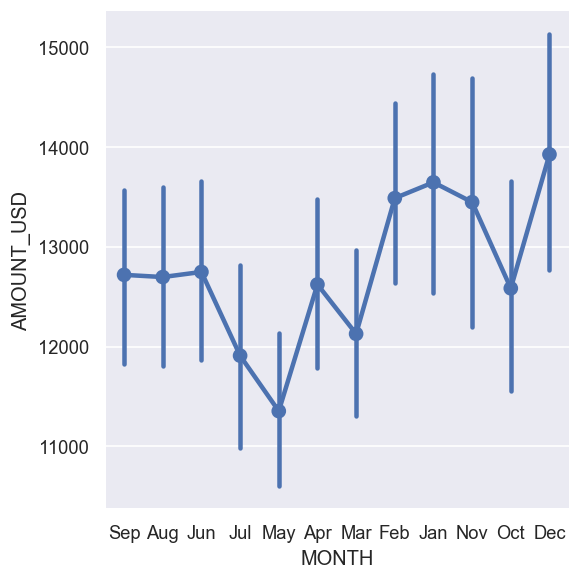

In [ ]:
sns.factorplot(data = Exportaciones_YM, x ="MONTH", y = "AMOUNT_USD")

#### Primer modelo ARMA

In [ ]:
Exportaciones_encod_1

NameError: name 'Exportaciones_encod_1' is not defined

In [ ]:
Exportaciones_Esta = Exportaciones_encod_1.copy()
Exportaciones_Esta = Exportaciones_Esta.drop('EMPRESAS', axis=1, errors='ignore')
Exportaciones_Esta.head()

AMOUNT_USD  CANTIDAD_DE_ORDENES
DATE                                       
2019-01-31     5750092                  434
2019-02-28     9798288                  811
2019-03-31     6846614                  659
2019-04-30     8251012                  636
2019-05-31     9752505                  754

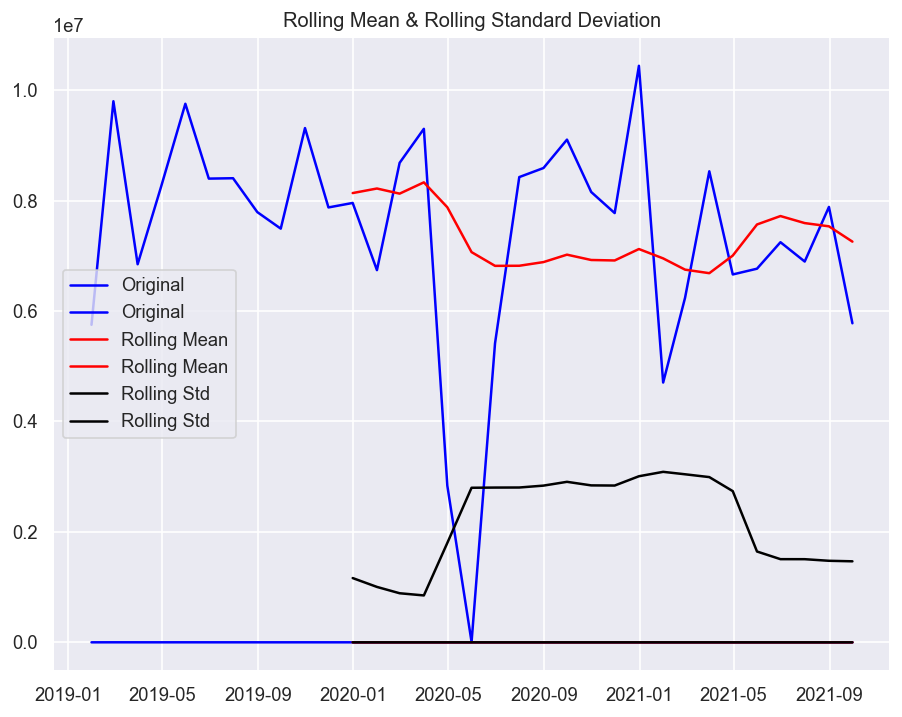

In [ ]:
rolling_mean = Exportaciones_Esta.rolling(window = 12).mean()
rolling_std = Exportaciones_Esta.rolling(window = 12).std()
plt.plot(Exportaciones_Esta, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

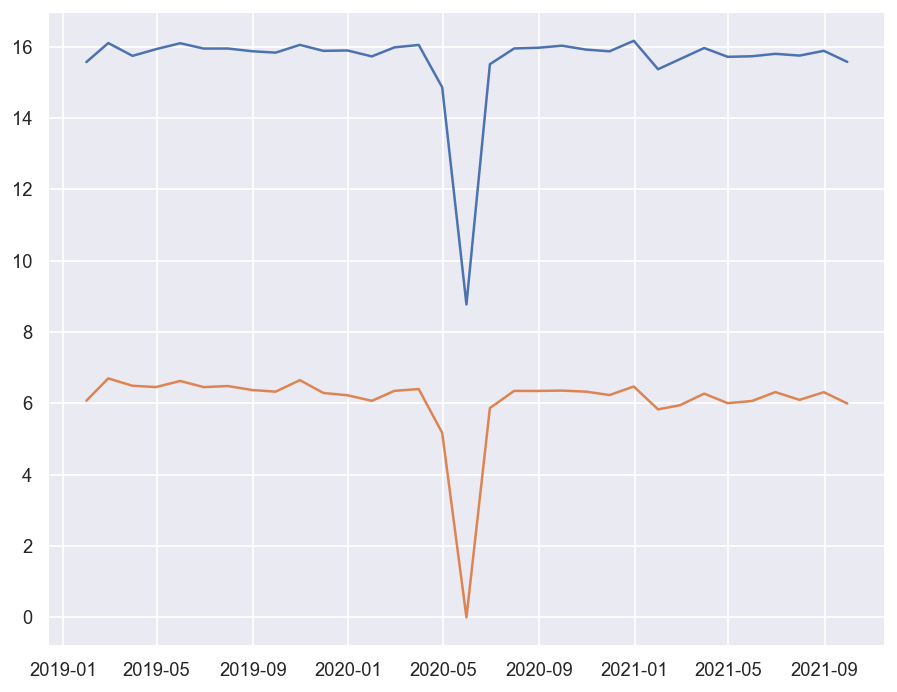

In [ ]:
Exportaciones_Esta_log = np.log(Exportaciones_Esta)
plt.plot(Exportaciones_Esta_log)

In [ ]:
result = adfuller(Exportaciones_Esta_log['AMOUNT_USD'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.73319751329029
p-value: 7.286424600768857e-05
Critical Values:
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['AMOUNT_USD'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

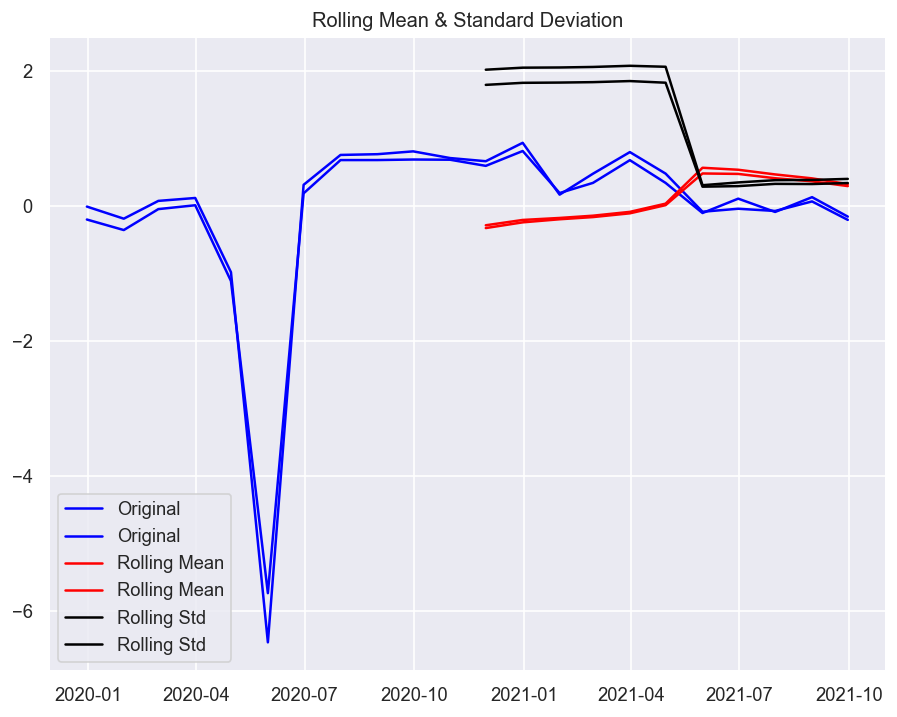

ADF Statistic: -3.2290715940417396
p-value: 0.018362378167368073
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443


In [ ]:
rolling_mean = Exportaciones_Esta_log.rolling(window=12).mean()
Exportaciones_Esta_minus_mean = Exportaciones_Esta_log - rolling_mean
Exportaciones_Esta_minus_mean.dropna(inplace=True)
get_stationarity(Exportaciones_Esta_minus_mean)

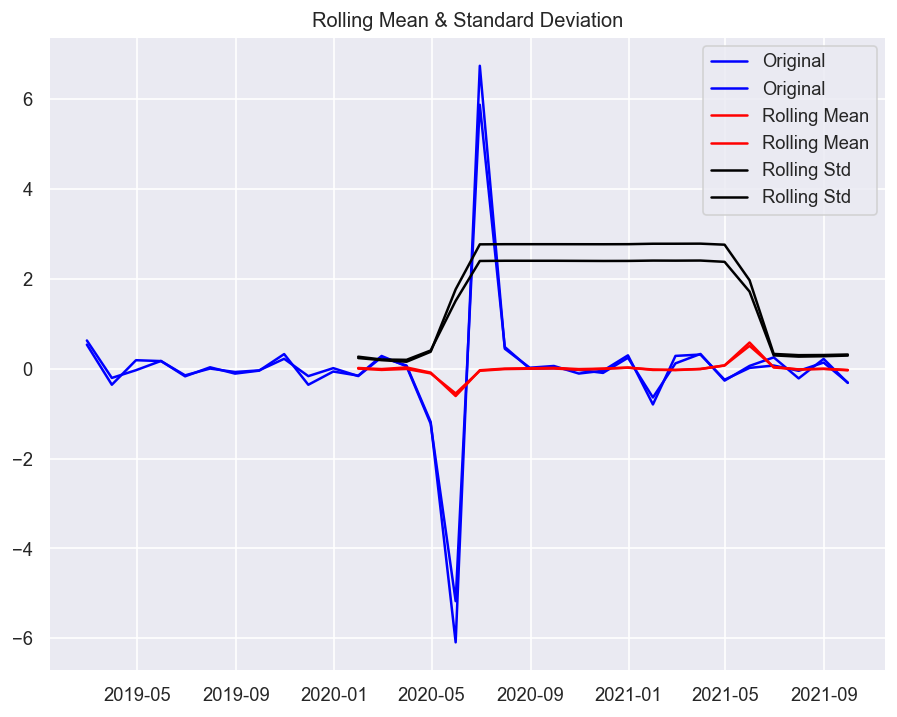

ADF Statistic: -5.9440387953103215
p-value: 2.225951840694752e-07
Critical Values:
	1%: -3.6699197407407405
	5%: -2.9640707407407407
	10%: -2.621171111111111


In [ ]:
df_log_shift = Exportaciones_Esta_log - Exportaciones_Esta_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [ ]:
decomposition = seasonal_decompose(Exportaciones_Esta_log) 
model = ARIMA(Exportaciones_Esta_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(Exportaciones_Esta['AMOUNT_USD'].iloc[0], index=Exportaciones_Esta.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Exportaciones_Esta)
plt.plot(predictions_ARIMA)

NameError: name 'results' is not defined

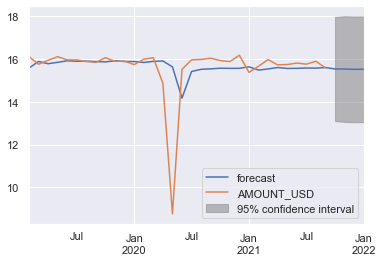

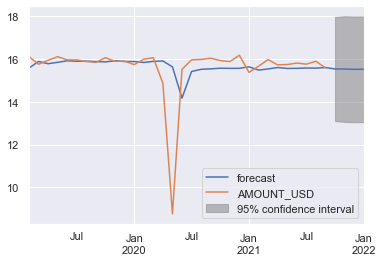

In [ ]:
results.plot_predict(1,36)

#### Segundo Modelo ARMA

In [ ]:
result = adfuller(Exportaciones_encod_1.AMOUNT_USD.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.944360
p-value: 0.001732


In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

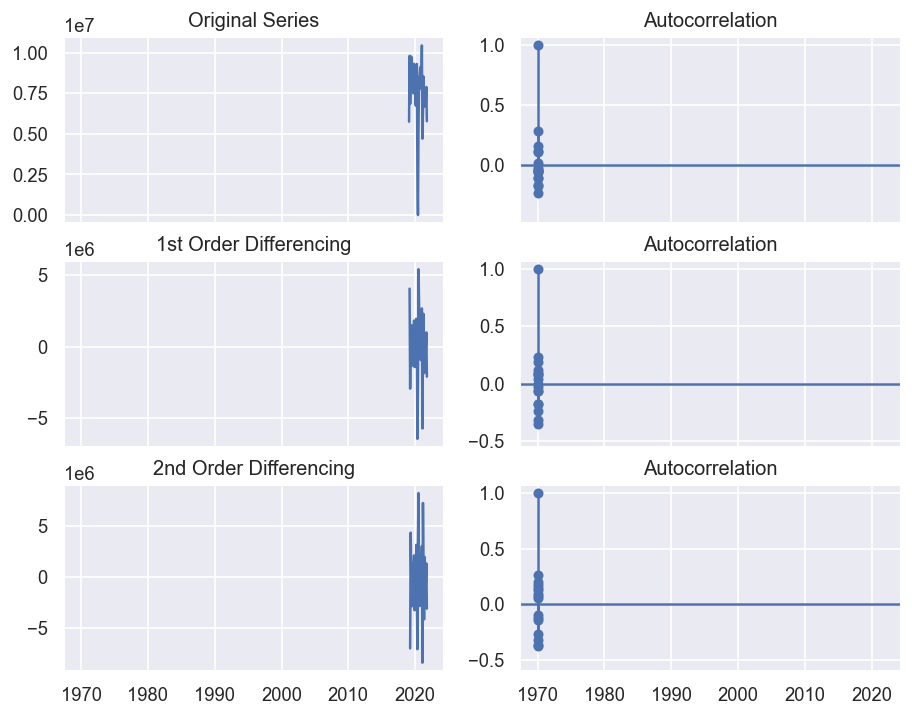

In [ ]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(Exportaciones_encod_1.AMOUNT_USD); axes[0, 0].set_title('Original Series')
plot_acf(Exportaciones_encod_1.AMOUNT_USD, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(Exportaciones_encod_1.AMOUNT_USD.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Exportaciones_encod_1.AMOUNT_USD.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Exportaciones_encod_1.AMOUNT_USD.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Exportaciones_encod_1.AMOUNT_USD.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

INCISO 1:

- Ajuste de distribucion: las compras llegan con una distribucion de Poisson, si o no. Media y el otro parametro. En caso que si hayar la gamma asociada. Que distribucion sigue cada columna historica, por dia, por semana, por mes.
- Intentar plantear algo de series de tiempos. (De a una variable en el eje y, y en el x serie tiempo)
- Proyecto final Python Dash, que yo le dropee un csv, me diga sus rows, clientes, y me deje hacer todo eso automaticamente.
- Dias/semana/año/total: Que dia se vendieron mas producto (cantidad, cliente, montos, pais, que producto fue el top)Analizar matriz de correlacion entre variables (vif, variance inflation factor)Armar con python Dash, tablas de ranking de todas las variables, con filtros de todas las variables.
- Agregar filtro mapa mundi.
- Analizar reduccion de dimensionalidad de las filas.
- Analisis de sensibilidad
- Armar cluster de productos, kneigbords, logistica clasificacion (por ejemplo los mas baratos los mas vendidos).
- Armar cluster del cliente por relevancia / ranking.
- Nueva variable, factor de tamaño (Definir en chico, mediano o grande segun volumen)
- Nueva variable, el gdp del pais, y relevancia para el pais, 


#### Tercer Modelo Auto ARIMA

In [ ]:
Exportaciones_Esta_1 = Exportaciones.copy()
Exportaciones_Esta_1 = Exportaciones_Esta_1[Exportaciones_Esta_1['EMPRESAS'] == 1]

In [ ]:
Exportaciones_Esta_1

TAX_ID        DATE     PRODUCT_DESCRIPTION  \
1      49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30      PALETA DE PLASTICO   
21     49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30      PALETA DE PLASTICO   
24     49000cb3c9325f7cdba66c5062ce3ccc  2021-09-21       VALVULA SOLENOIDE   
26     49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30       HOJAS DE PLASTICO   
46     49000cb3c9325f7cdba66c5062ce3ccc  2021-09-30  CONTENEDOR DE PLASTICO   
...                                 ...         ...                     ...   
74549  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-25       VALVULA SOLENOIDE   
74551  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-25           TAPA PLASTICA   
74556  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-08       VALVULA SOLENOIDE   
74557  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-15       VALVULA SOLENOIDE   
74558  49000cb3c9325f7cdba66c5062ce3ccc  2019-01-25  SPOOL VALVE R70 VCM FR   

       AMOUNT_USD       DESTINATION_COUNTRY  EMPRESAS  
1               1  UNITED STATES OF AMERICA         1  
21              1  UNITED STATES OF AMERICA         1  
24           9759  UNITED STATES OF AMERICA         1  
26              1  UNITED STATES OF AMERICA         1  
46              1  UNITED STATES OF AMERICA         1  
...           ...                       ...       ...  
74549        4704  UNITED STATES OF AMERICA         1  
74551           1  UNITED STATES OF AMERICA         1  
74556       10260  UNITED STATES OF AMERICA         1  
74557        8469  UNITED STATES OF AMERICA         1  
74558       11385  UNITED STATES OF AMERICA         1  

[17142 rows x 6 columns]

In [ ]:
result = adfuller(Exportaciones_encod_1['AMOUNT_USD'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.9443597972575914
p-value: 0.0017315840468833828
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(Exportaciones_encod_1.AMOUNT_USD, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1037.001, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1035.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1037.994, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1037.663, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1033.841, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -515.921
Date:                Sun, 03 Apr 2022   AIC                           1033.841
Time:                        21:01:58   BIC                           1035.307
Sample:                             0   HQIC                          1034.327
                                 - 33                                       

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


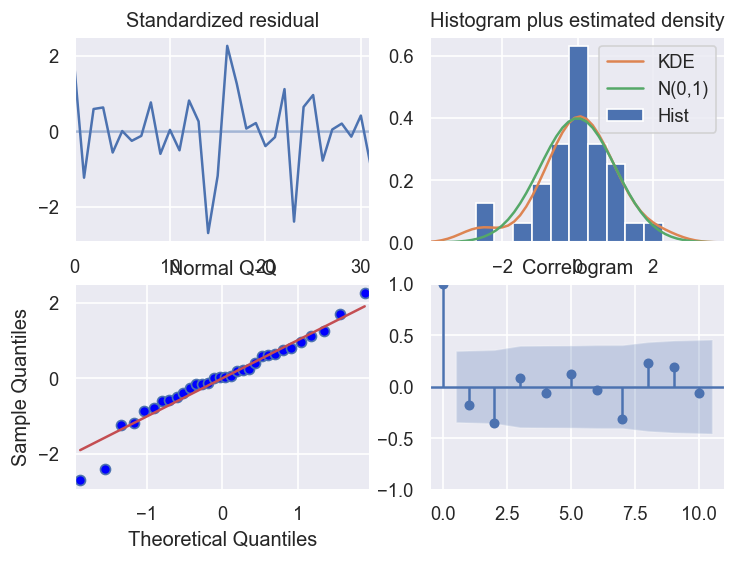

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [ ]:
Exportaciones_encod_1

AMOUNT_USD  EMPRESAS
DATE                            
2019-01-31     5750092       434
2019-02-28     9798288       811
2019-03-31     6846614       659
2019-04-30     8251012       636
2019-05-31     9752505       754
2019-06-30     8397144       635
2019-07-31     8404076       654
2019-08-31     7790820       585
2019-09-30     7491077       559
2019-10-31     9312151       772
2019-11-30     7875150       539
2019-12-31     7956358       505
2020-01-31     6740148       432
2020-02-29     8682451       572
2020-03-31     9298623       601
2020-04-30     2837254       176
2020-05-31        6449         1
2020-06-30     5414346       353
2020-07-31     8424805       571
2020-08-31     8589102       570
2020-09-30     9102862       576
2020-10-31     8154314       559
2020-11-30     7773156       508
2020-12-31    10440023       646
2021-01-31     4704498       340
2021-02-28     6239286       382
2021-03-31     8529429       529
2021-04-30     6661643       405
2021-05-31     6765833       430
2021-06-30     7245439       552
2021-07-31     6895564       444
2021-08-31     7884505       551
2021-09-30     5777427       401

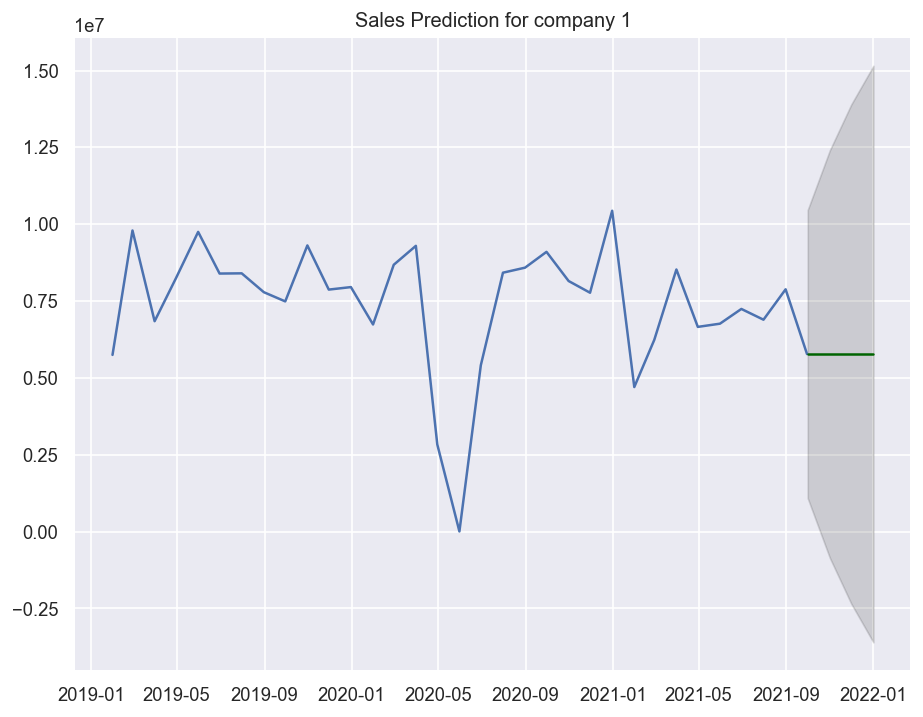

In [ ]:
# Forecast
n_periods = 4
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(Exportaciones_encod_1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Exportaciones_encod_1.AMOUNT_USD)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Sales Prediction for company 1")
plt.show()

In [ ]:
model.predict()

array([5777427., 5777427., 5777427., 5777427., 5777427., 5777427.,
       5777427., 5777427., 5777427., 5777427.])

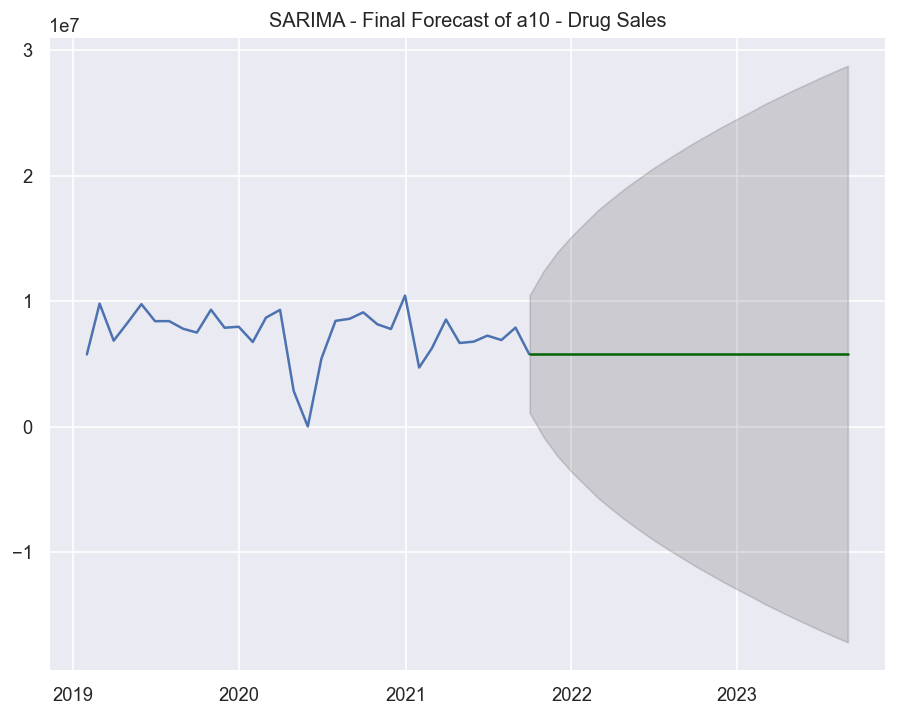

In [ ]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(Exportaciones_encod_1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Exportaciones_encod_1.AMOUNT_USD)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [ ]:
result = adfuller(Exportaciones_Esta_1['AMOUNT_USD'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -47.720627032379525
p-value: 0.0
Critical Values:
	1%: -3.4307317358324454
	5%: -2.861708712266494
	10%: -2.5668598011995916


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(Exportaciones_Esta_1.AMOUNT_USD, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=407337.802, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=410277.641, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=407716.566, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=408400.660, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=5.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=407338.558, Time=1.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=407732.412, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=407378.526, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=407341.764, Time=1.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=406356.596, Time=1.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=406659.551, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=406401.043, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=406315.826, Time=2.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=406315.290, Time=0.66 sec
 ARIMA(3,0,0

/Users/cfontana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


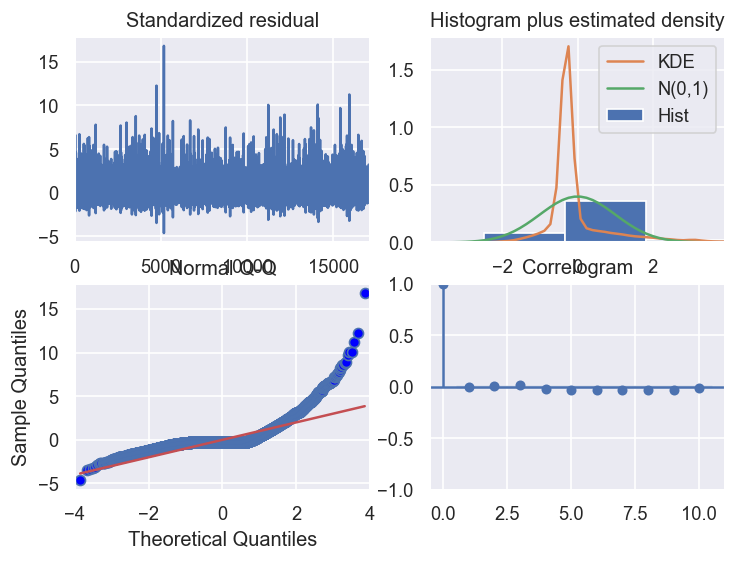

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

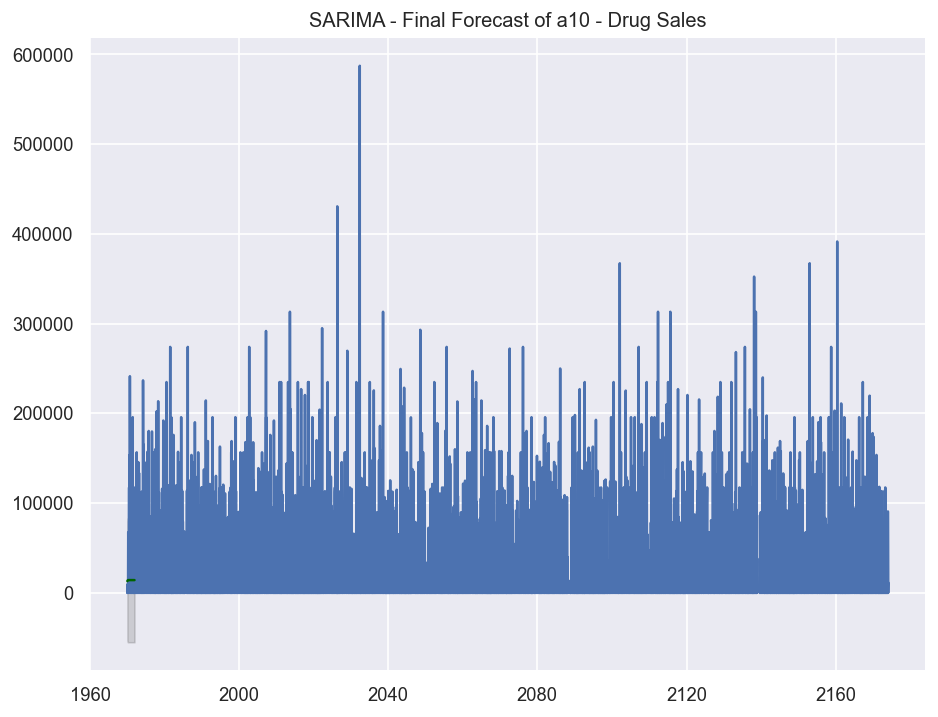

In [ ]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(Exportaciones_Esta_1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Exportaciones_Esta_1.AMOUNT_USD)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()